In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import path, walk, listdir
from os.path import isfile
from statistics import fmean
import re
from tqdm import tqdm

# Constants

In [102]:
RUNTIME_SECONDS = 3600

DIR_Classic = "../bench_data/classic/"
DIR_Modified = "../bench_data/modified/"

REGEX_NODES = r"\d+_nodes"
REGEX_VERSION = r"(modified)|(classic)"
REGEX_DURATION = r"\d+_minutes"
REGEX_RUN = r"run_\d+"
REGEX_PROBABILITY = r"(even)|(biased)"

COLOR_PALETTE = ['#0072B2', '#E1812C', "#009E73", "#CC79A7", "#56B4E9", "#E69F00", "#F0E442"]

# Utility Functions

In [103]:
def find_all_csvs(rootpath : str) -> list[str]:
    csvs = []
    for root, dirs, files in walk(rootpath):
        for dir in dirs:
            dir_path = path.join(root, dir)
            csvs = csvs + [path.normpath(path.abspath(path.join(root, dir, file))) for file in listdir(dir_path) if file.endswith('csv')]
    return csvs

def find_all_csvs_and_join(rootpaths : list[str]) -> list[str]:
    csvs = []
    for path in rootpaths:
        csvs = csvs + find_all_csvs(path)
    return csvs

In [104]:
FILES = find_all_csvs("..\\bench_data")

In [105]:
def open_csv(path : str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[df.leaderId != -1] # Remove the initial dummy entries
    return df

In [106]:
def find_node_count(df : pd.DataFrame) -> int:
    return len(df["serverId"].unique())

In [107]:
def find_quorum_size(df : pd.DataFrame) -> int:
    return find_node_count(df) // 2 + 1

In [108]:
def get_node_count(file : str) -> int:
    num, _ = re.search(REGEX_NODES, file).group().split("_", maxsplit=1)
    return int(num)

def get_duration_minutes(file : str) -> int:
    num, _ = re.search(REGEX_DURATION, file).group().split("_", maxsplit=1)
    return int(num)

def get_algorithm_type(file : str) -> str:
    return re.search(REGEX_VERSION, file).group()

def get_run_id(file : str) -> str:
    return re.search(REGEX_RUN, file).group()

def get_probability_type(file : str) -> str:
    return re.search(REGEX_PROBABILITY, file).group()

# Work per Leader

## Committed entries

In [109]:
def plot_leader_commit_counts(df : pd.DataFrame, title=None):
    leaders = df["leaderId"].value_counts()
    leaders = leaders / len(df)
    # plt.bar(leaders.index, leaders)
    sns.barplot(leaders)
    plt.ylim(0,1)
    if not title is None:
        plt.title(title)
    plt.show()

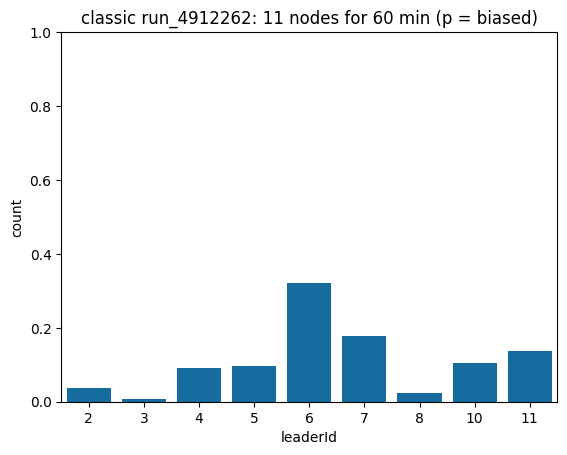

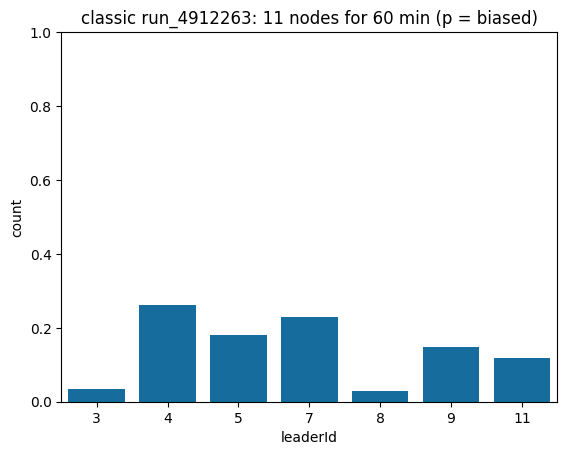

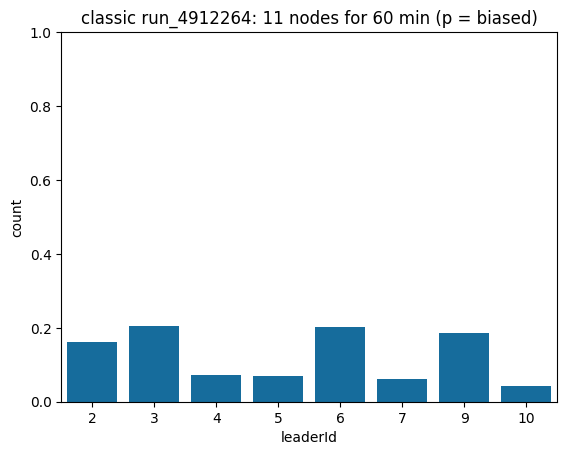

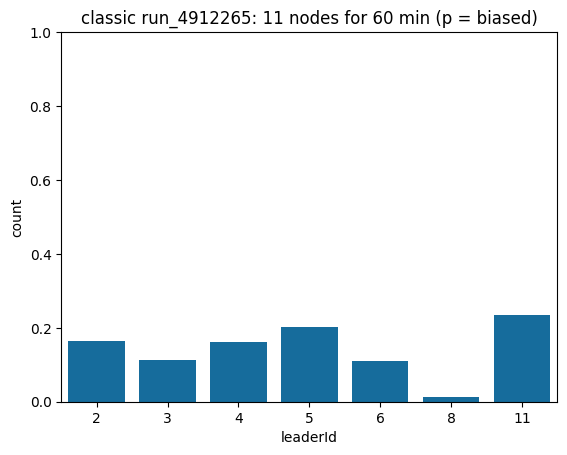

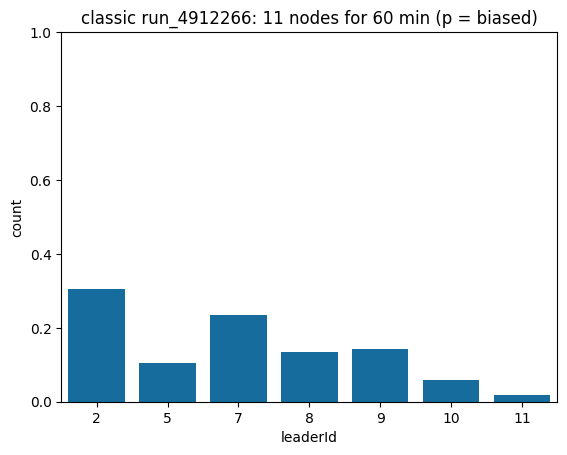

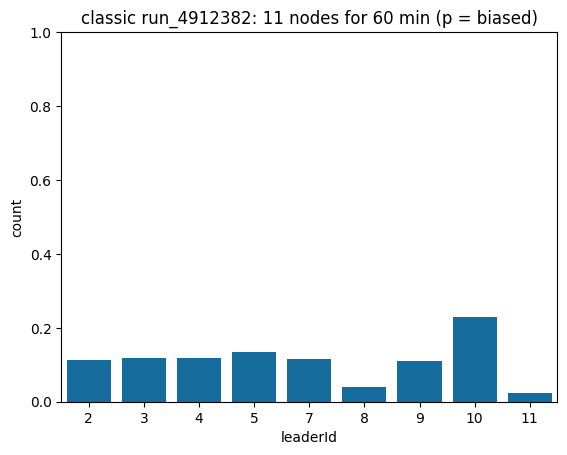

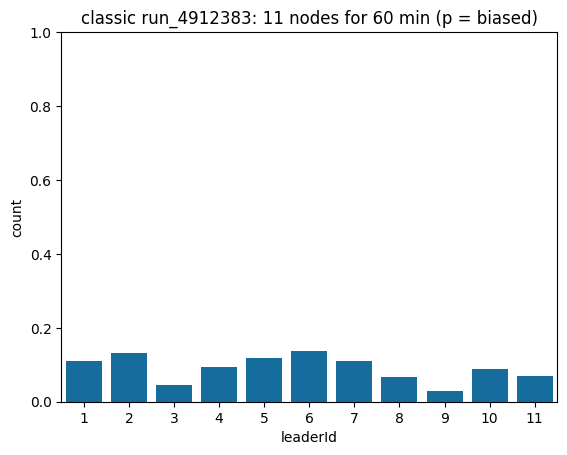

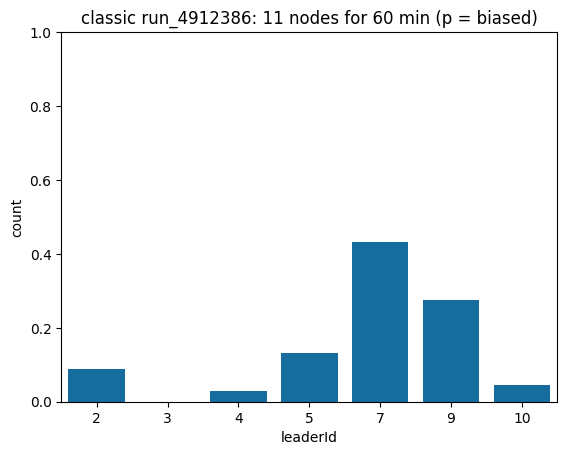

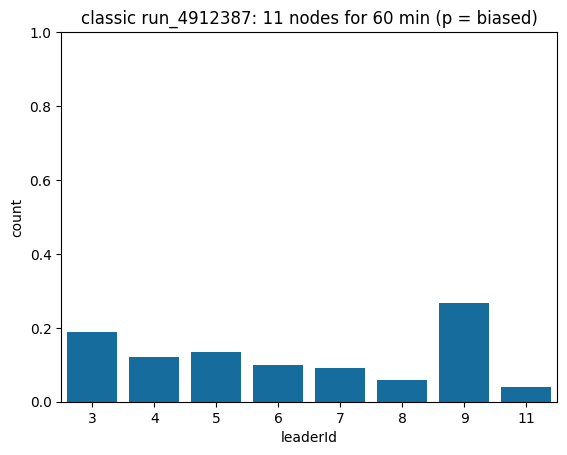

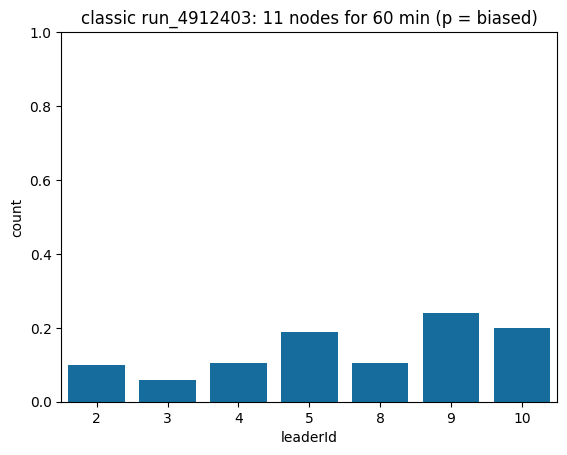

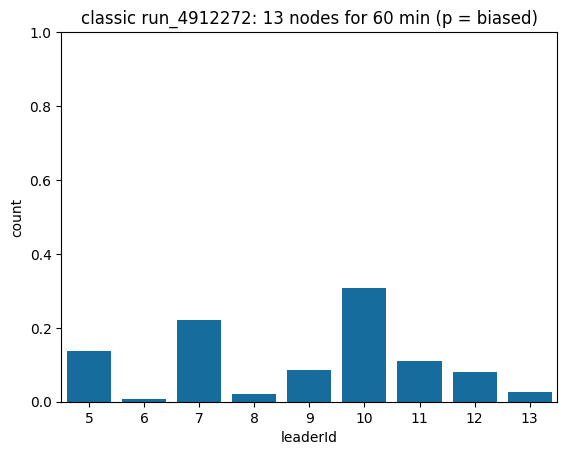

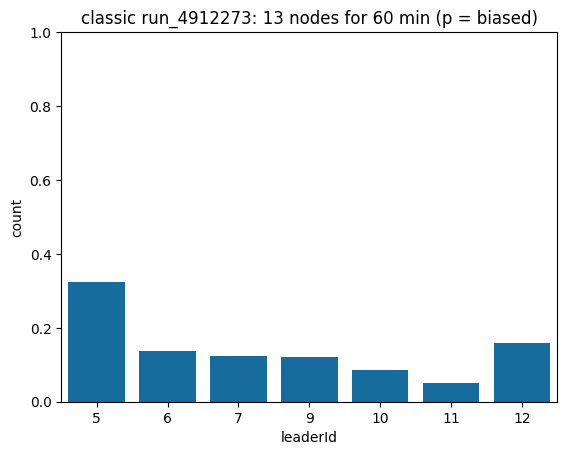

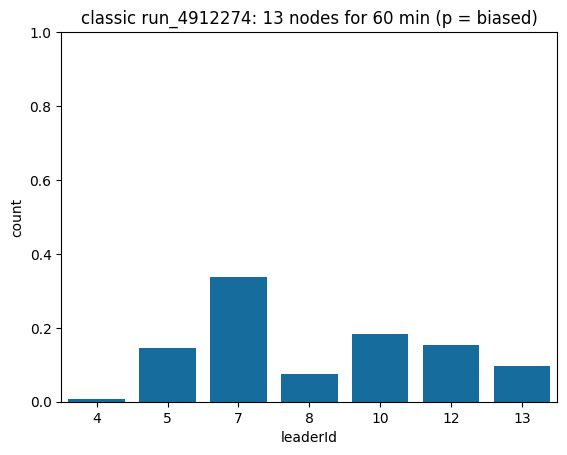

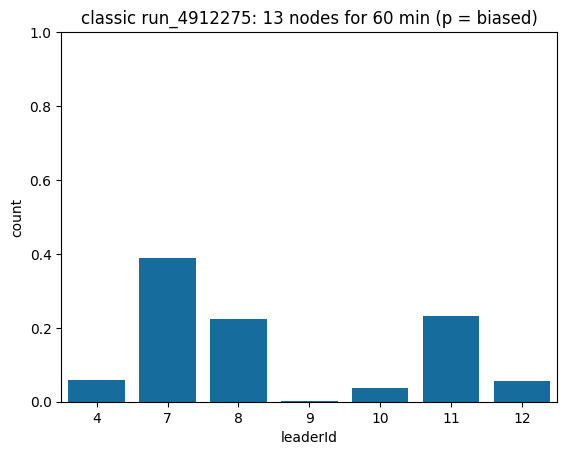

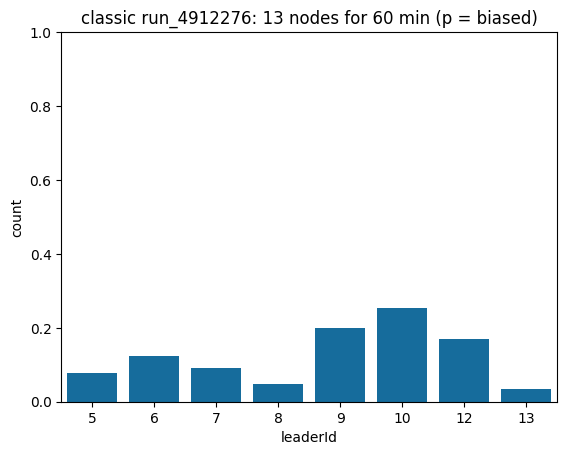

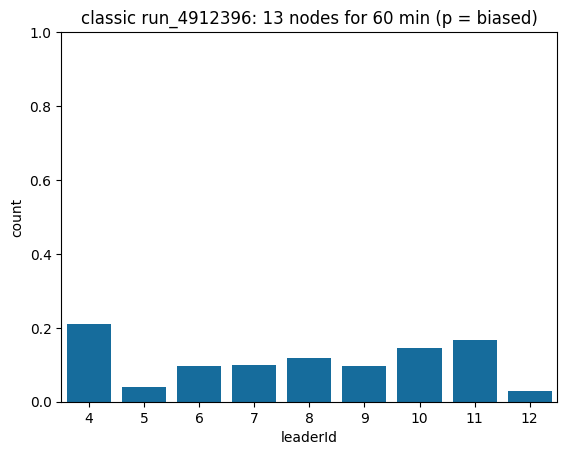

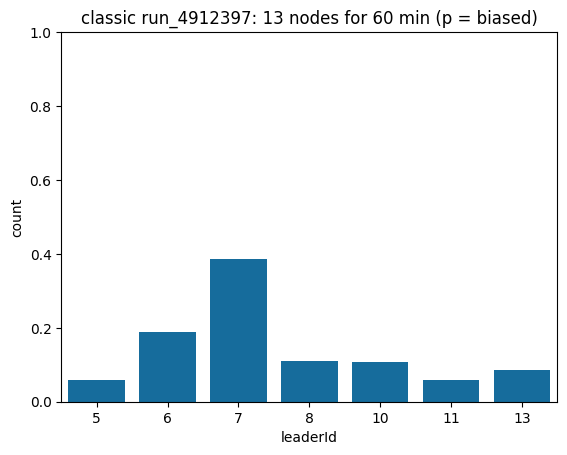

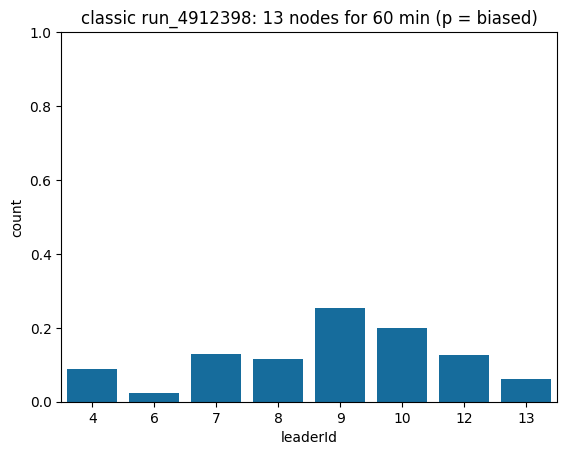

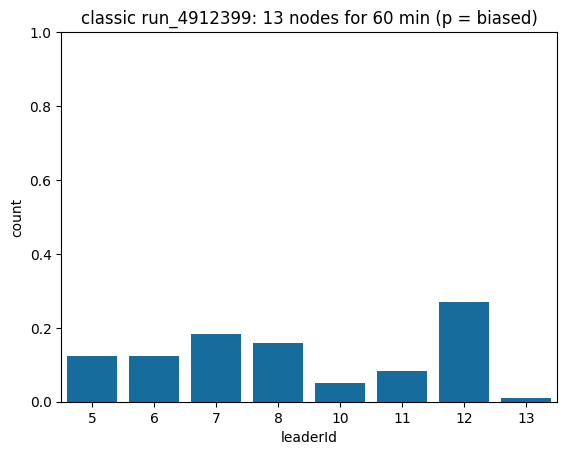

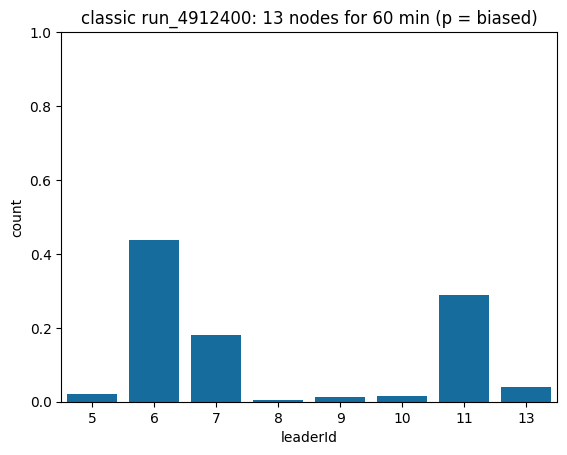

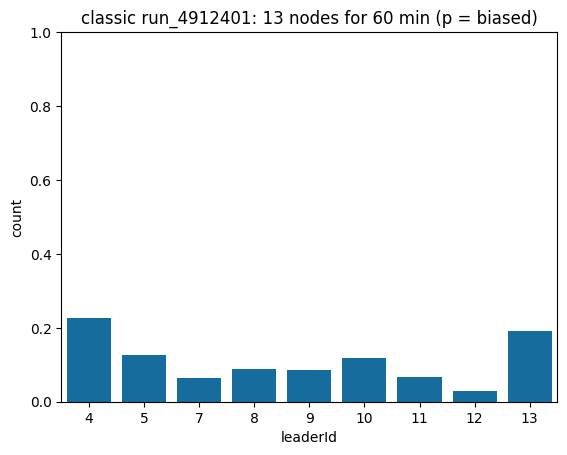

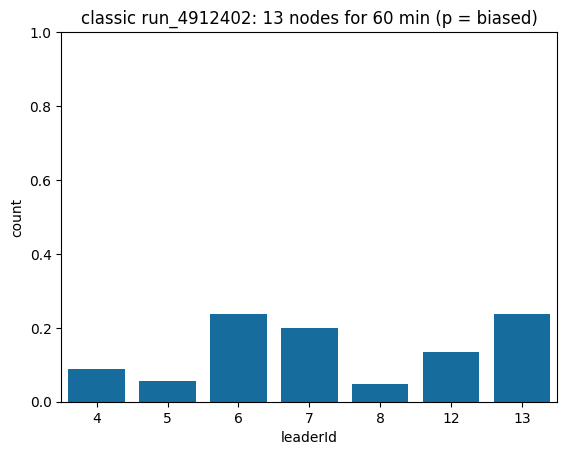

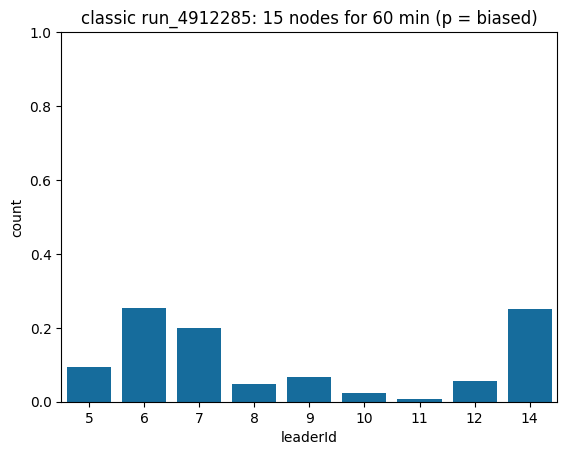

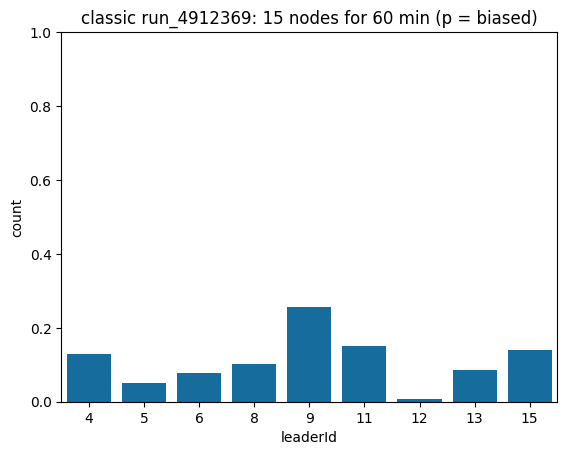

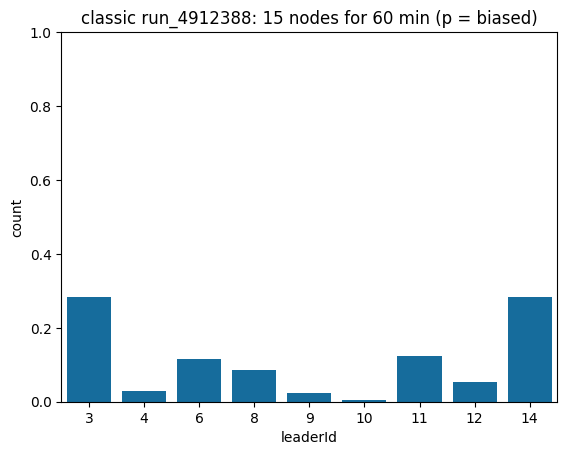

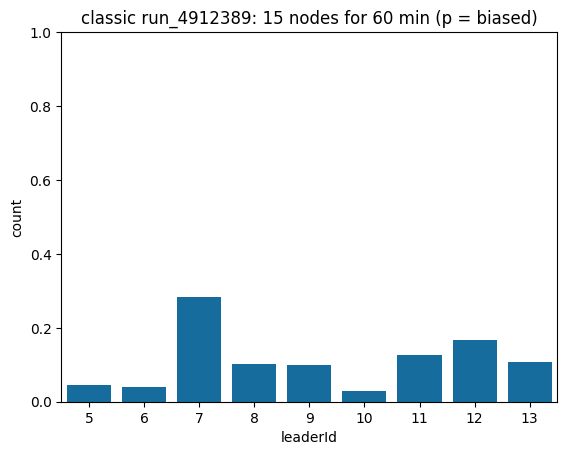

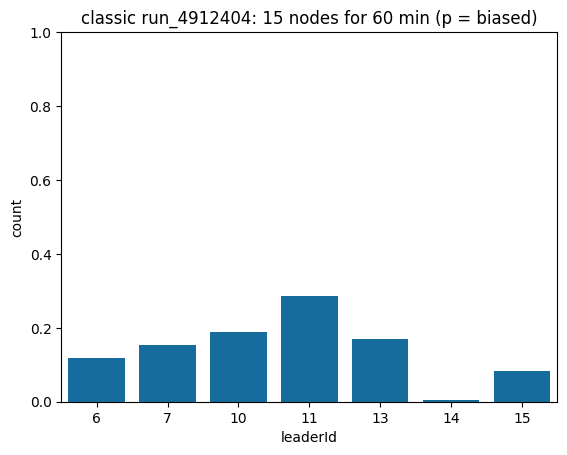

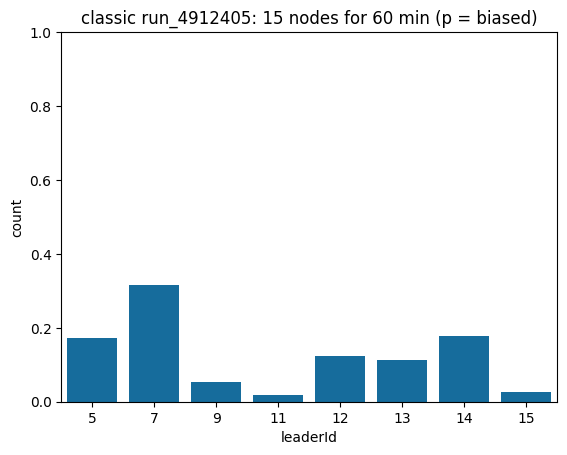

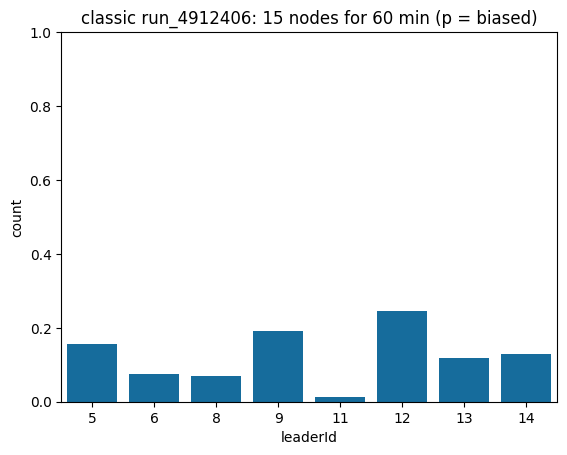

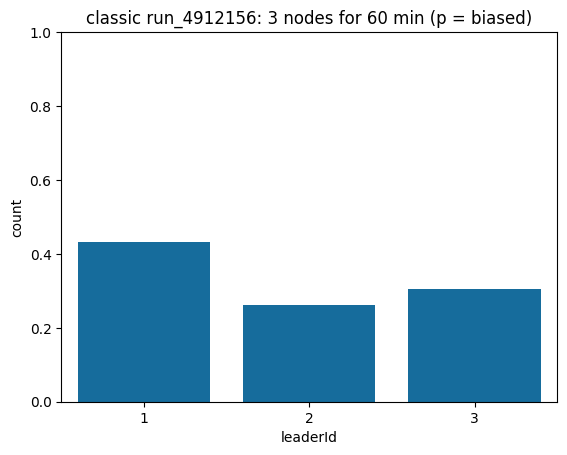

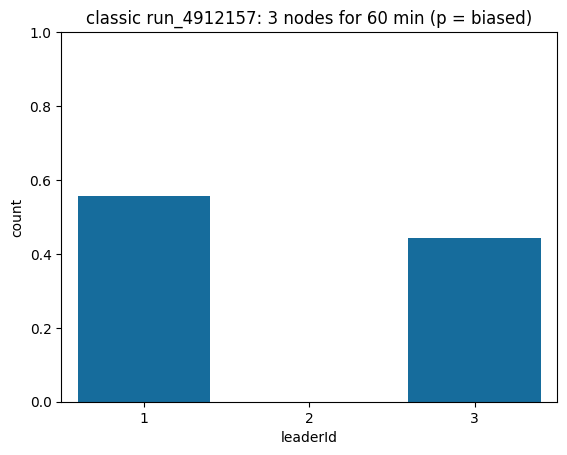

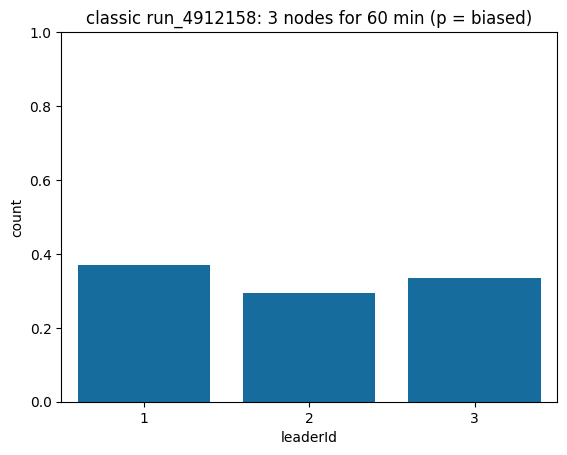

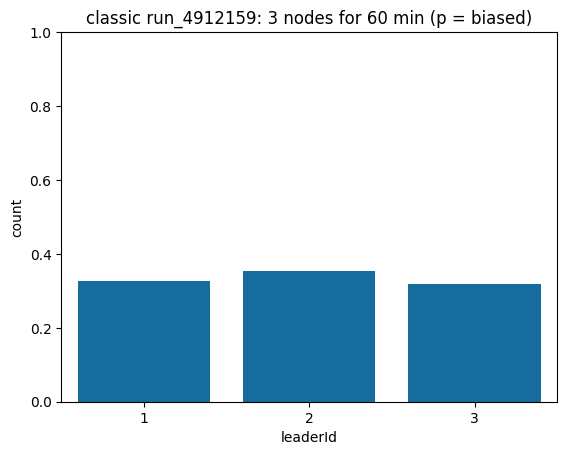

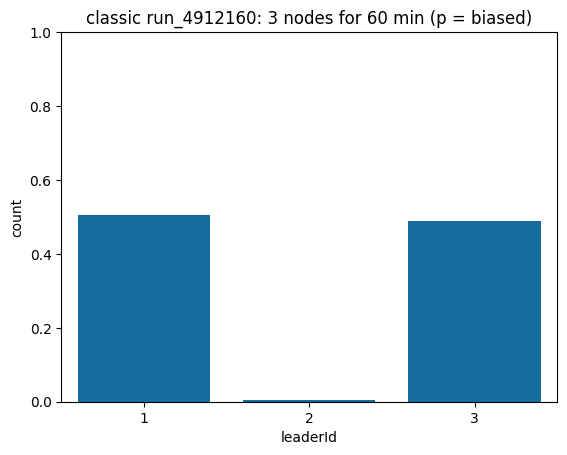

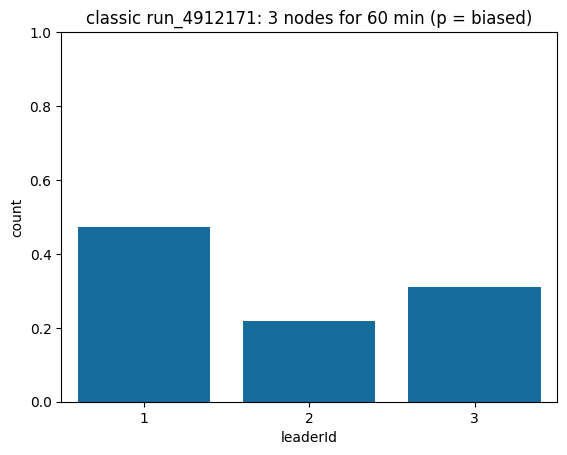

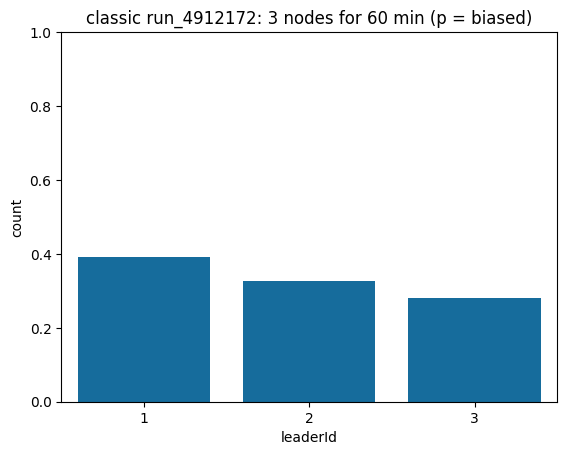

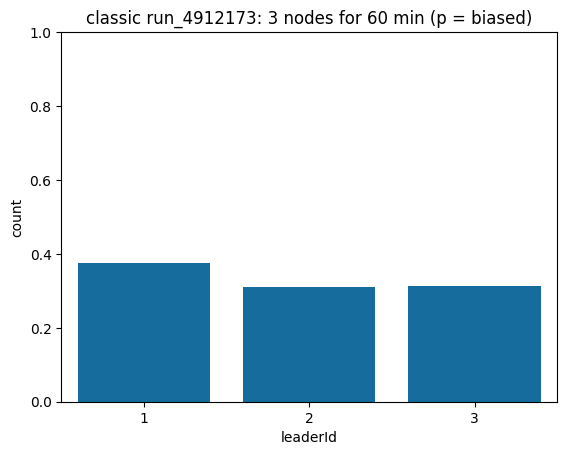

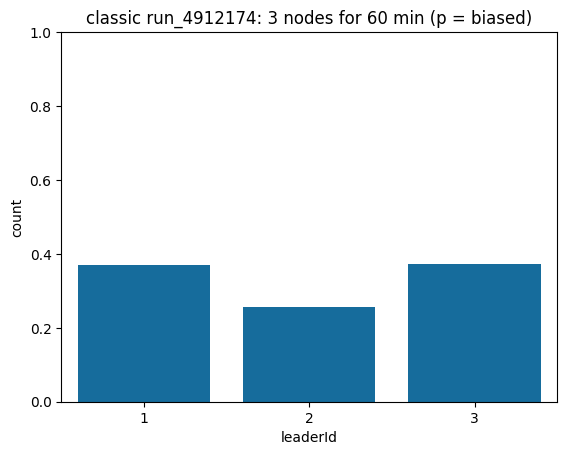

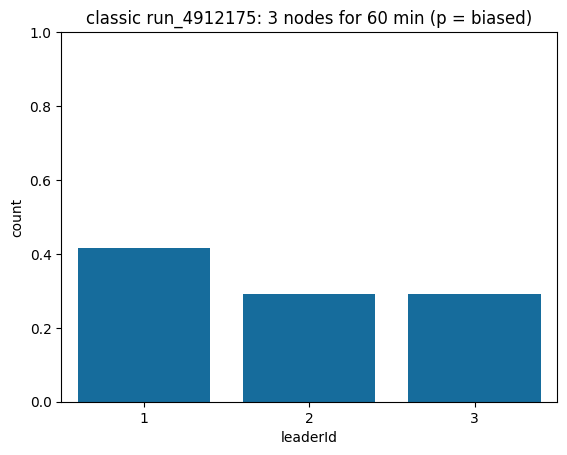

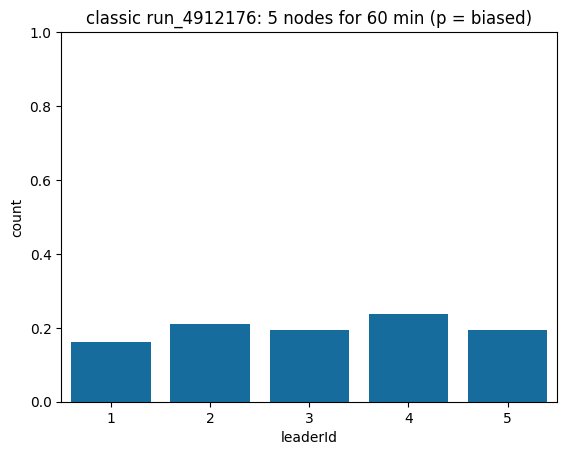

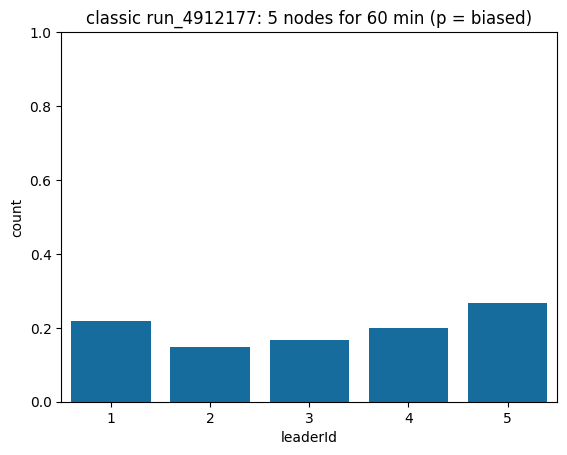

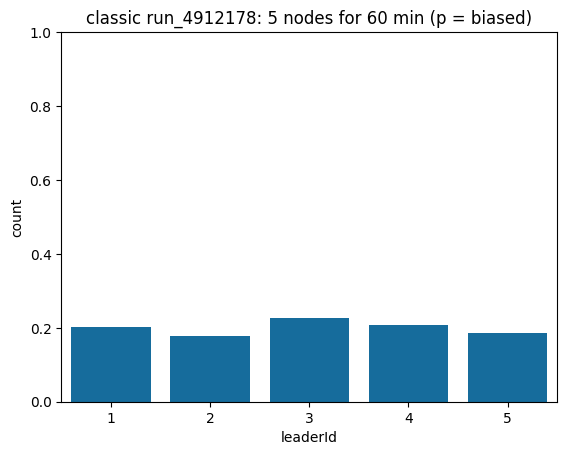

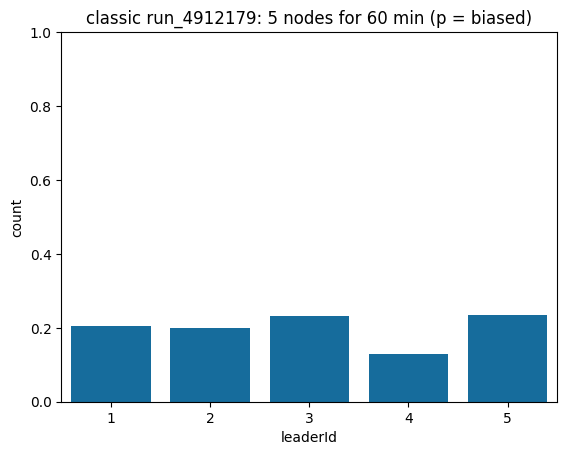

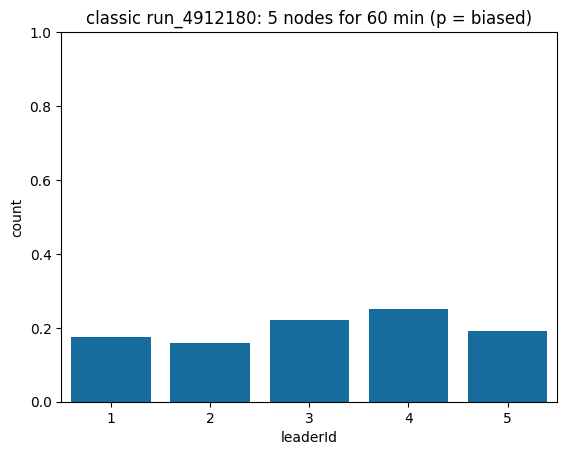

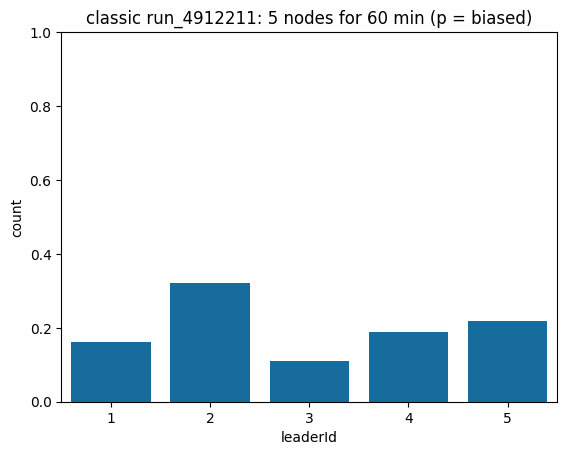

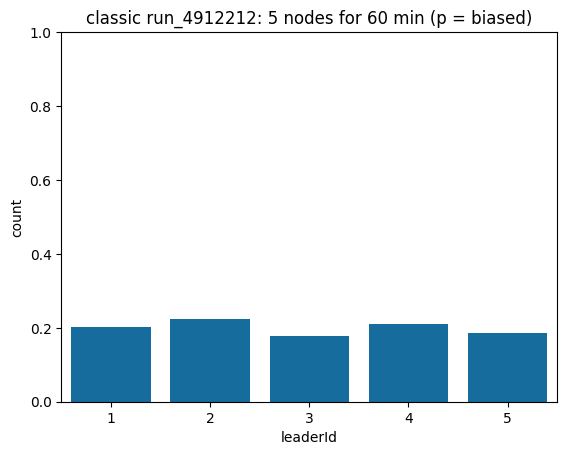

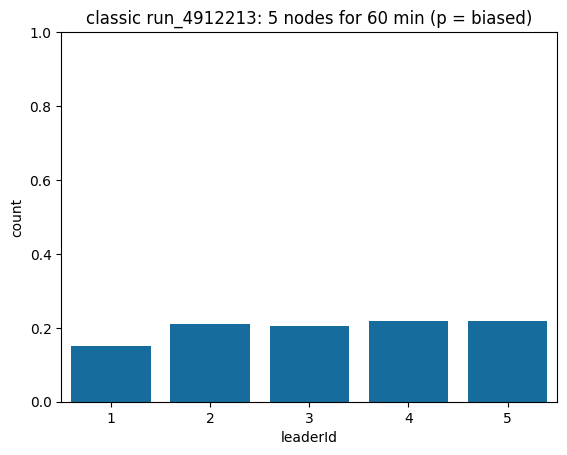

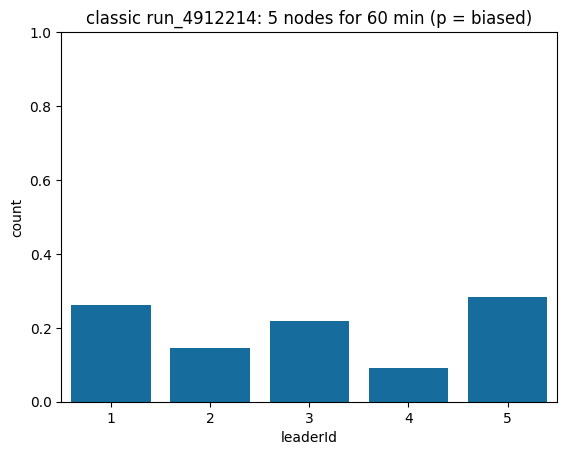

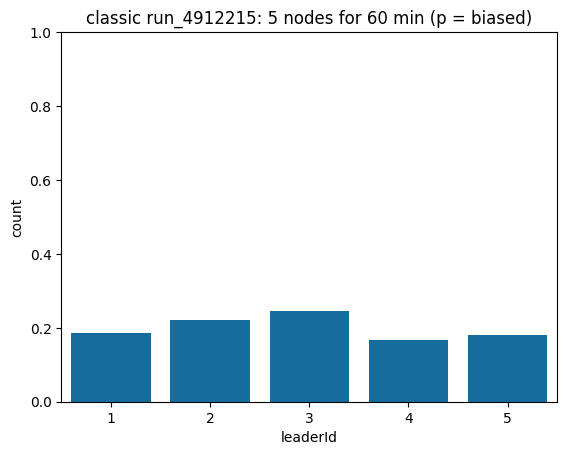

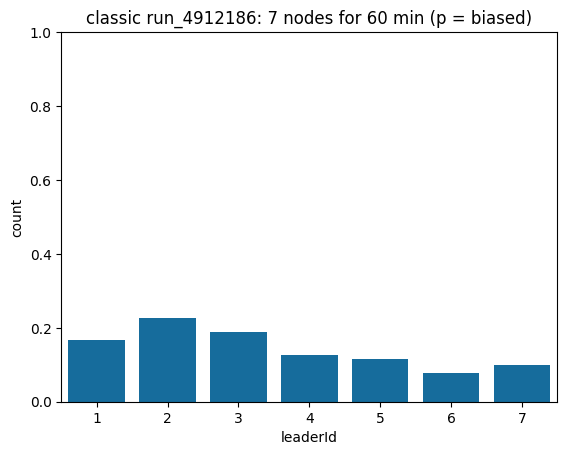

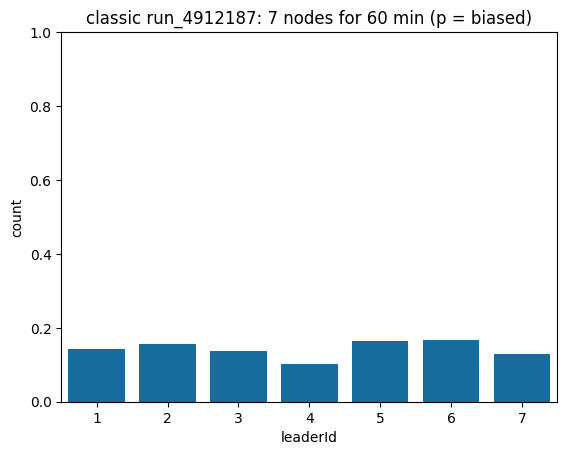

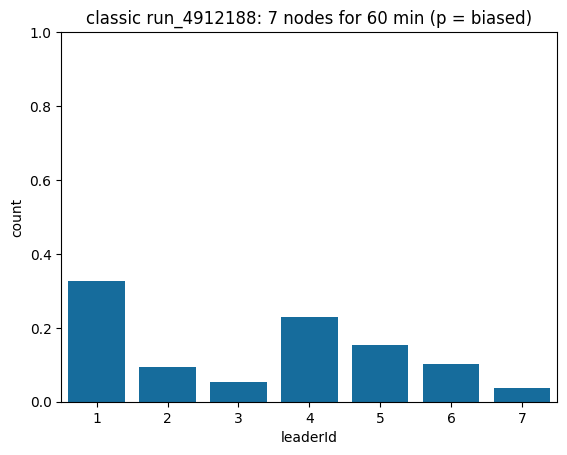

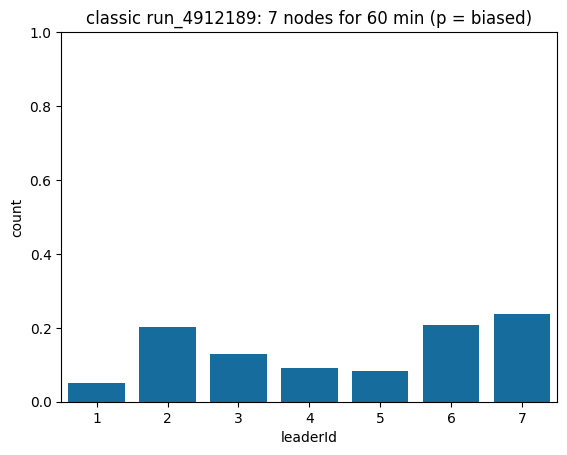

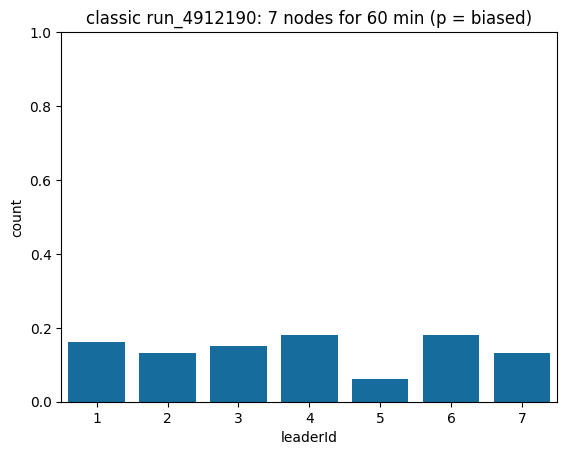

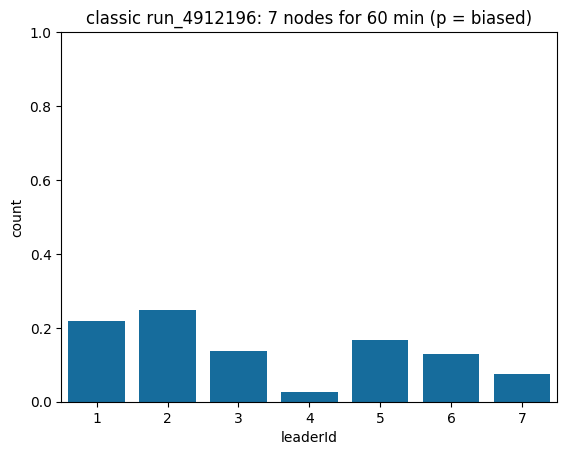

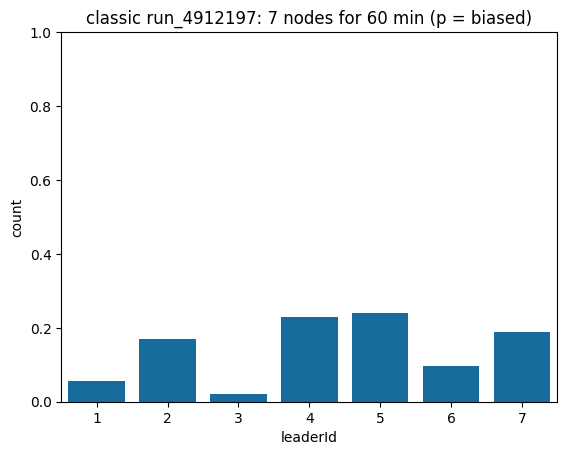

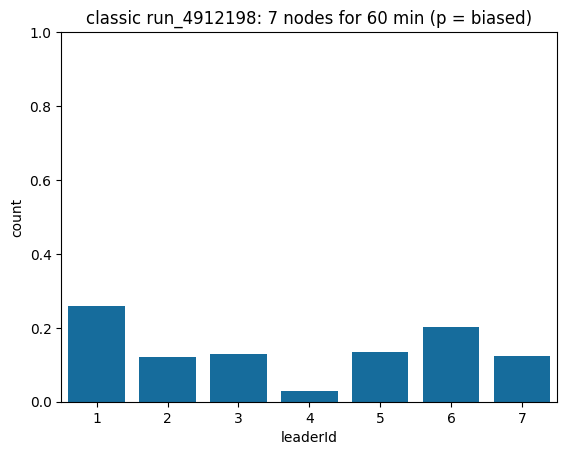

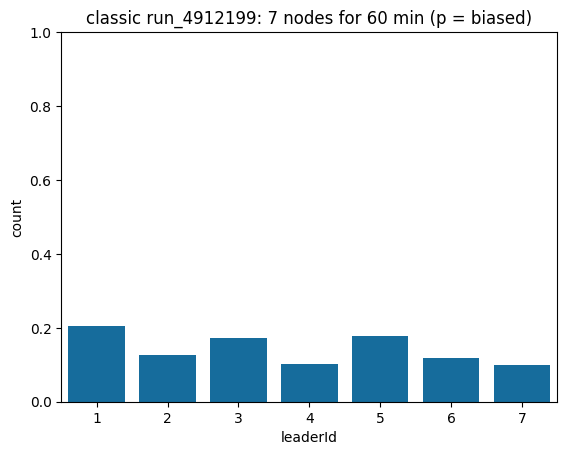

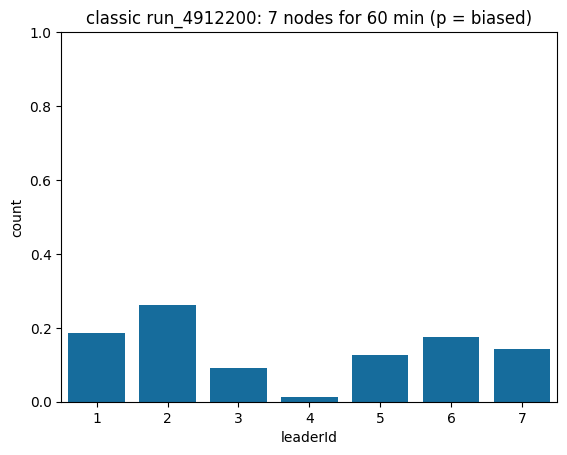

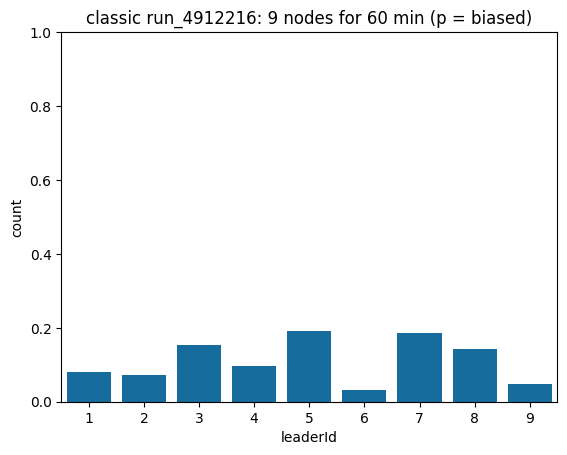

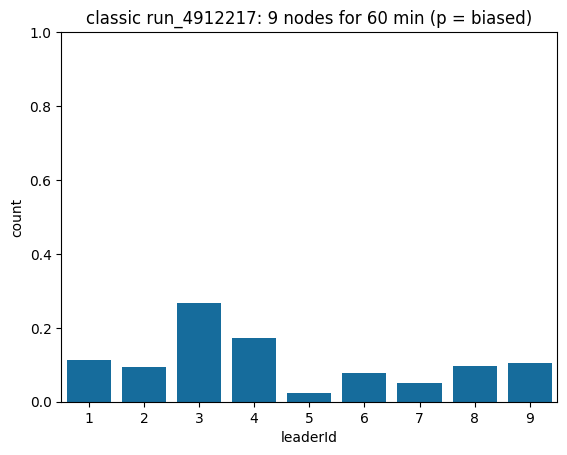

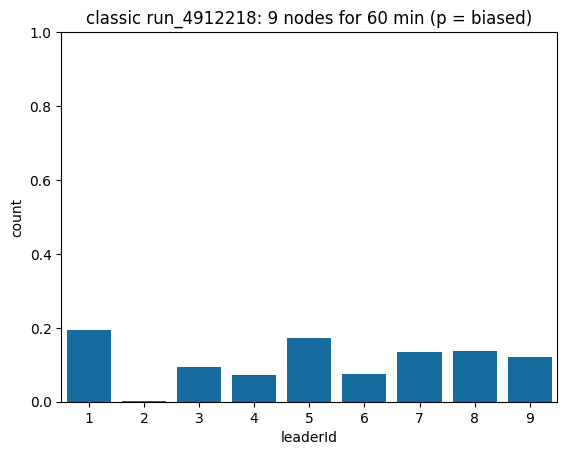

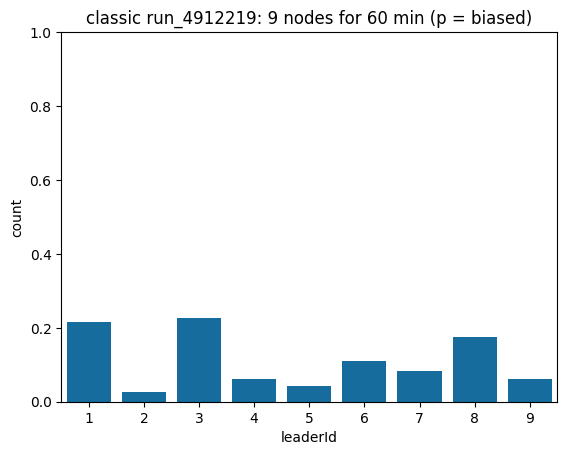

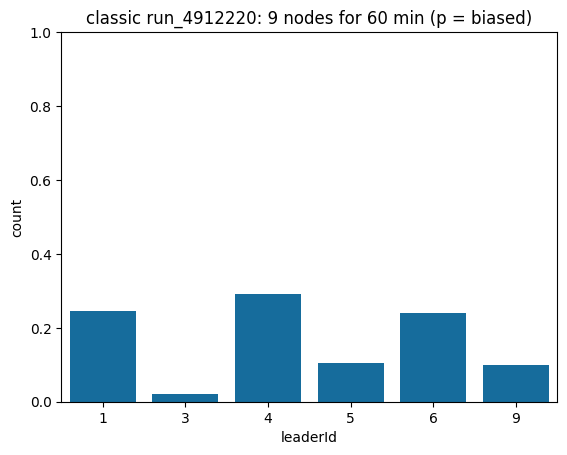

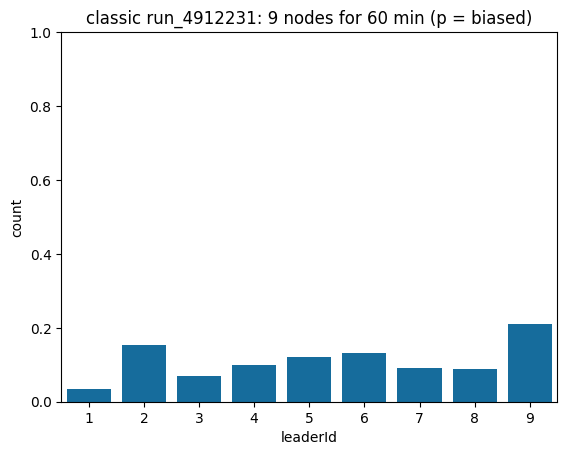

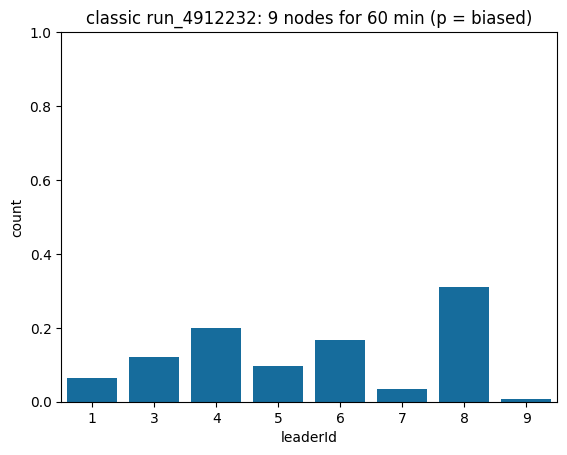

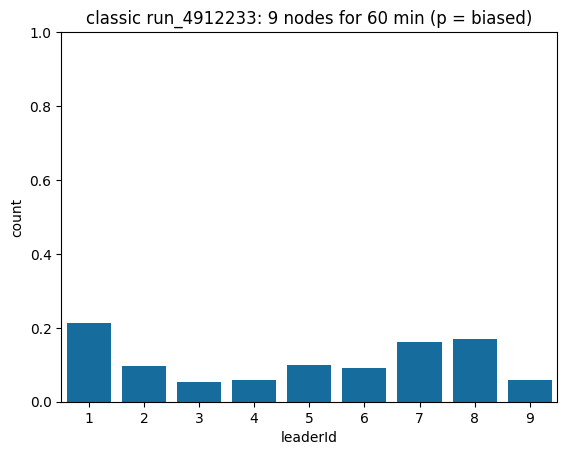

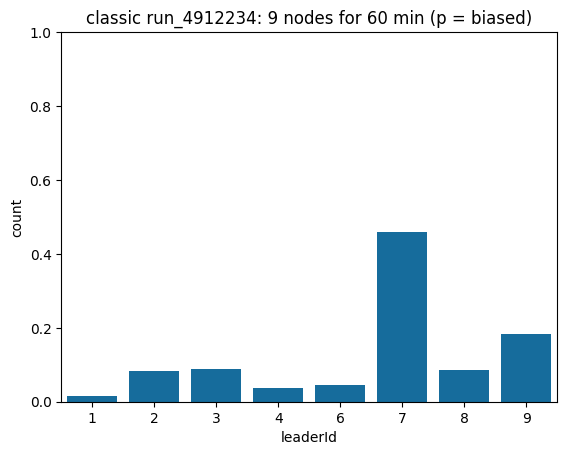

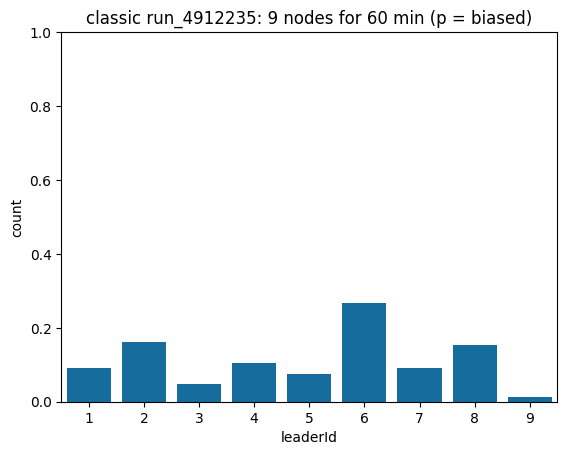

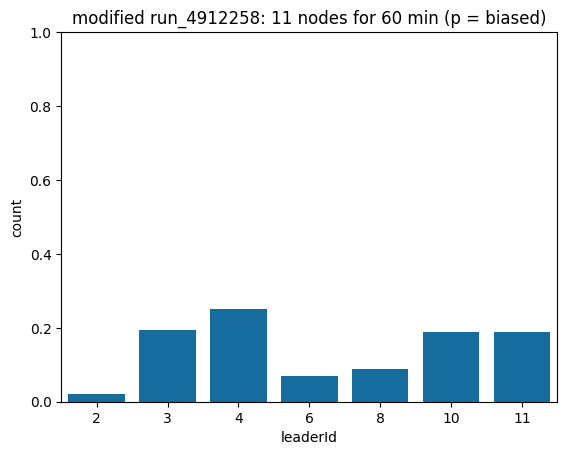

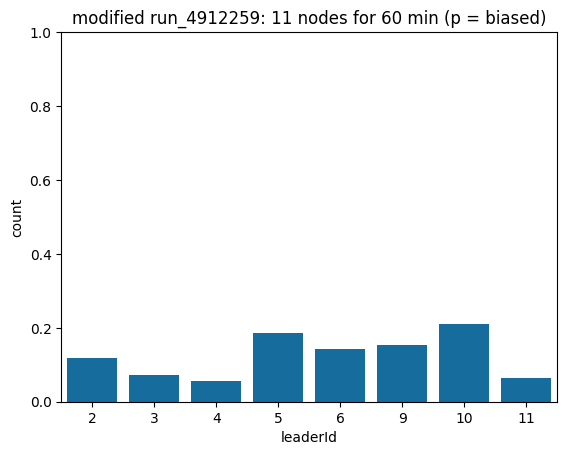

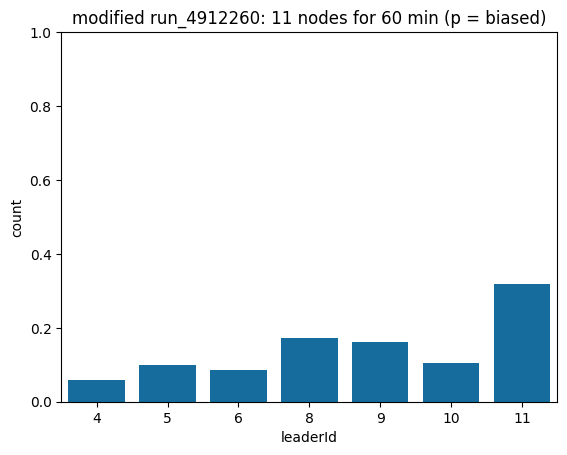

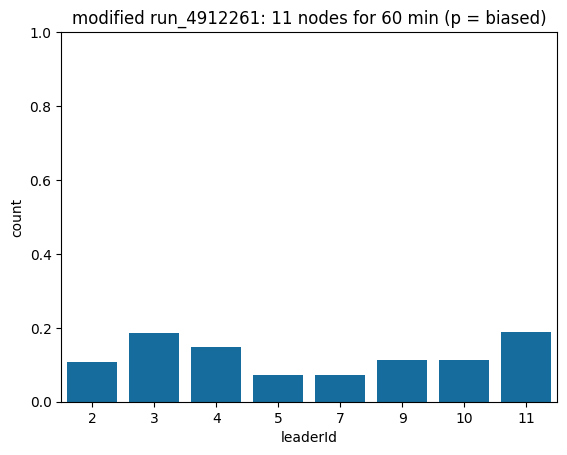

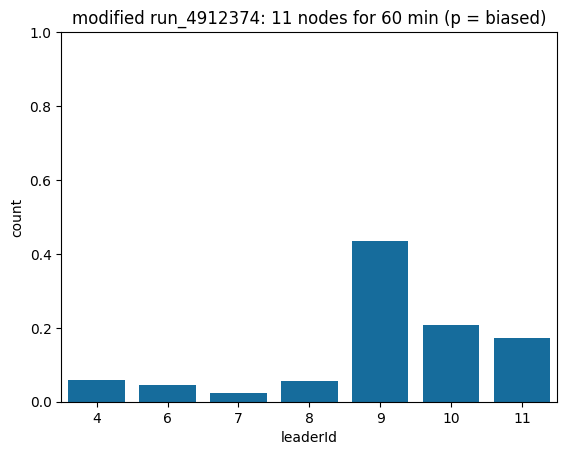

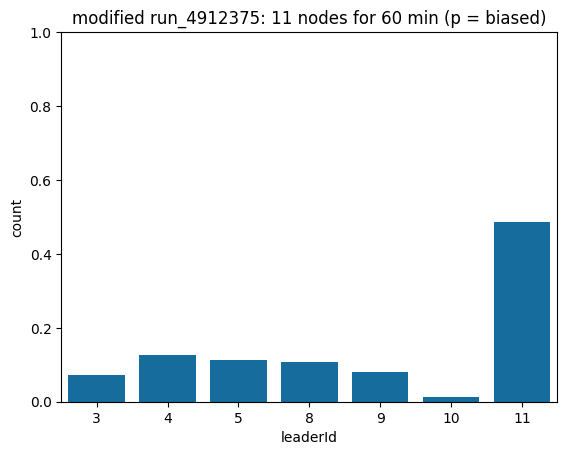

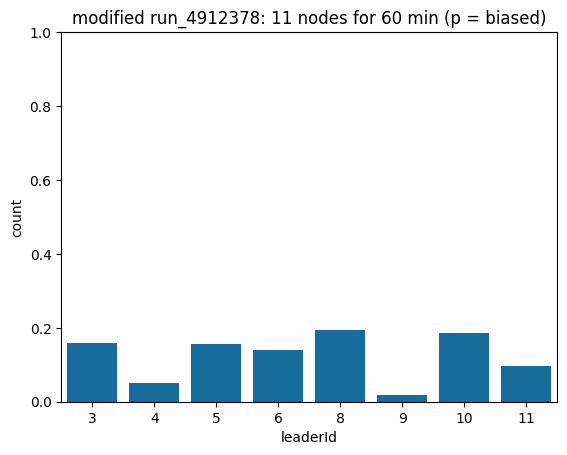

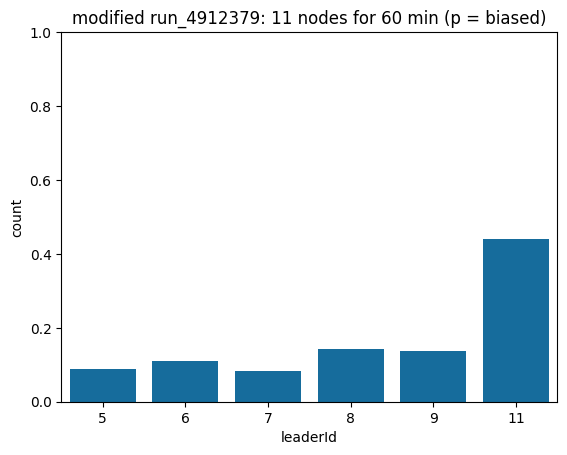

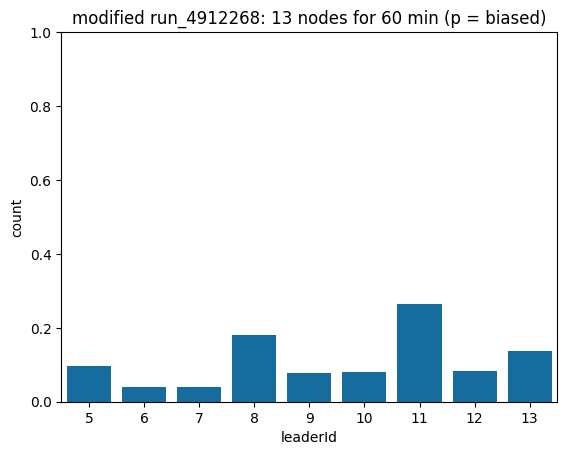

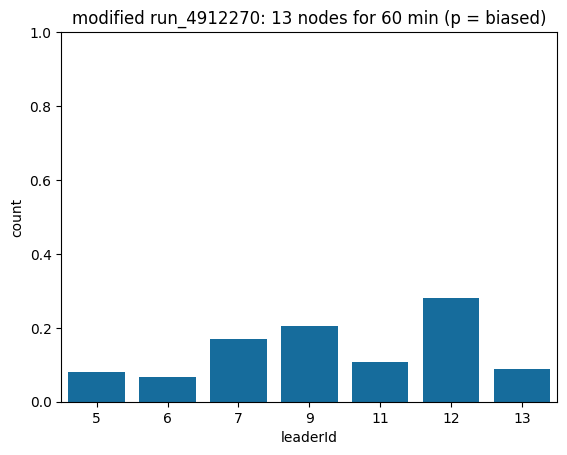

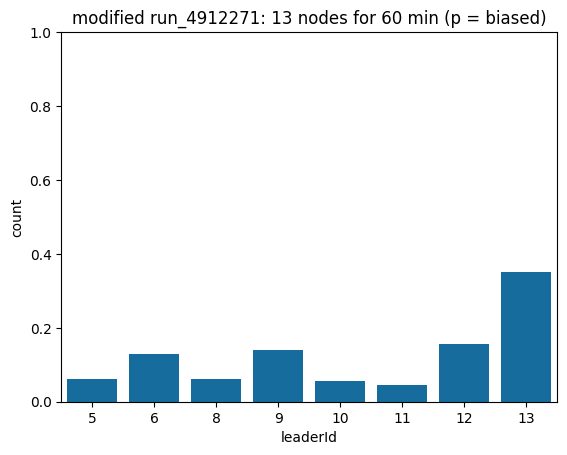

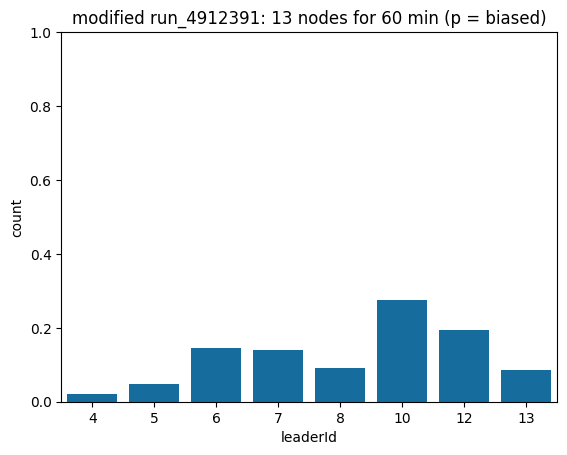

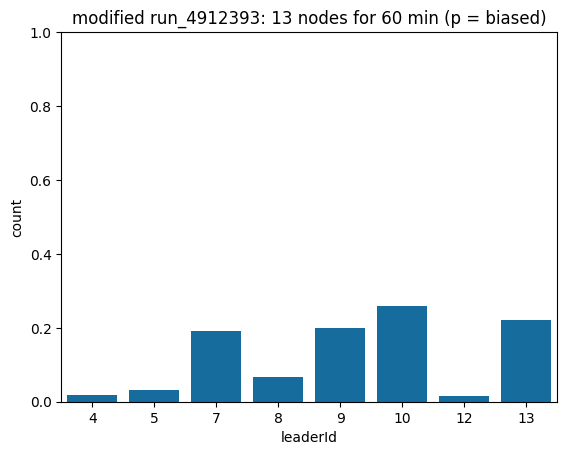

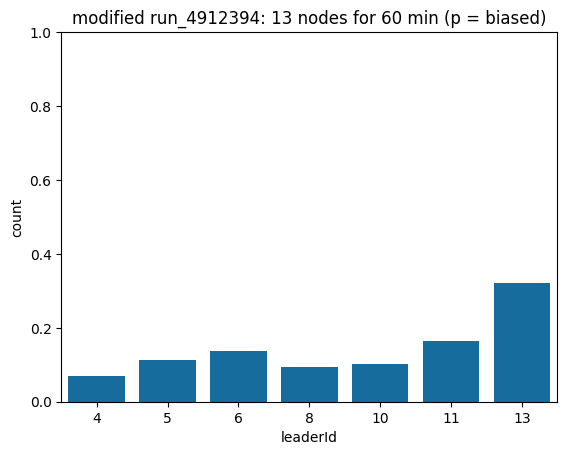

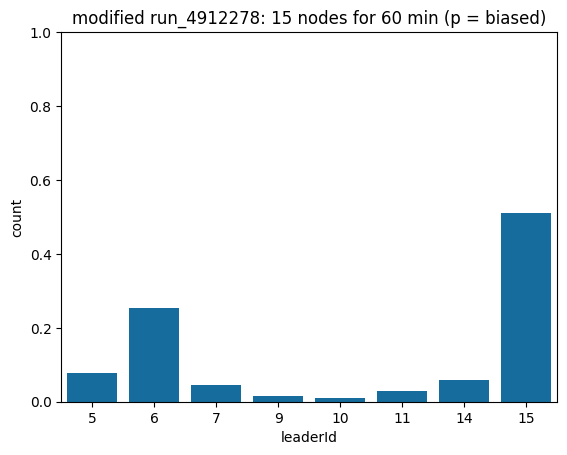

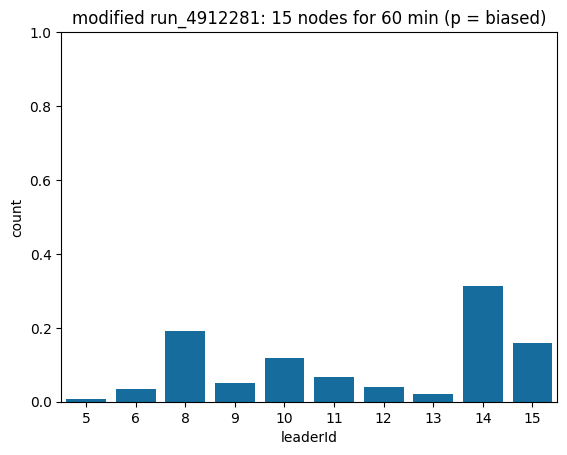

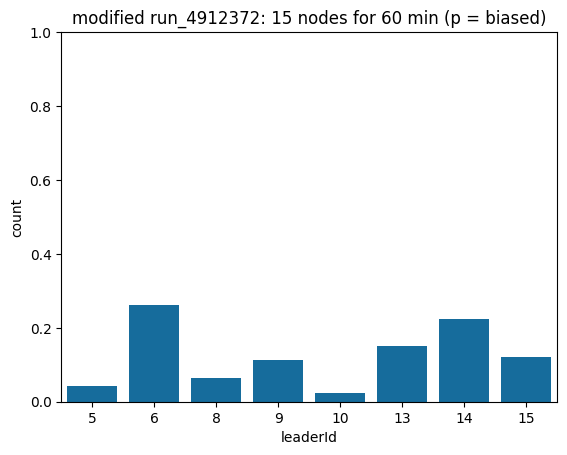

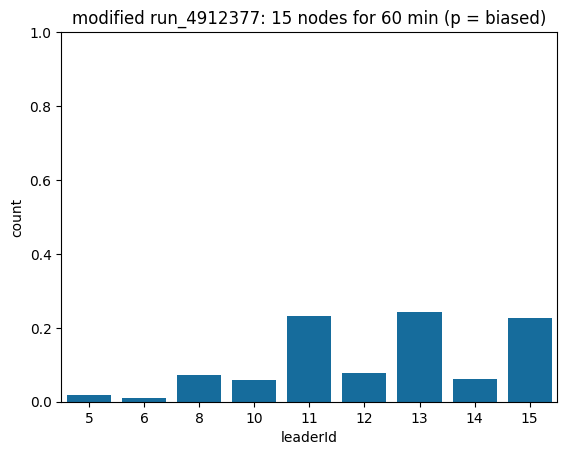

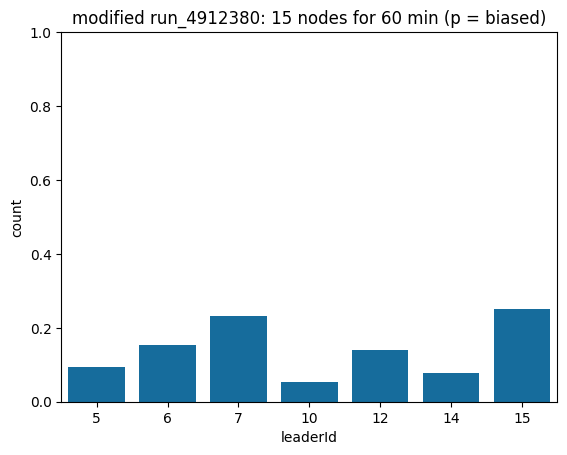

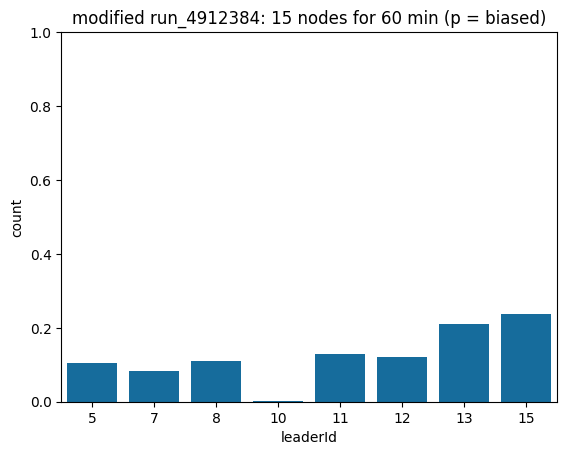

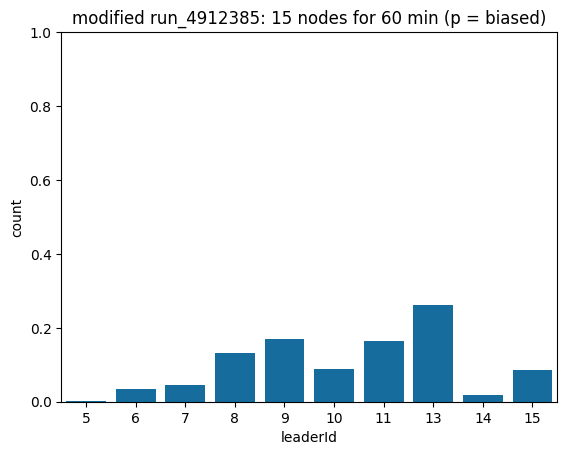

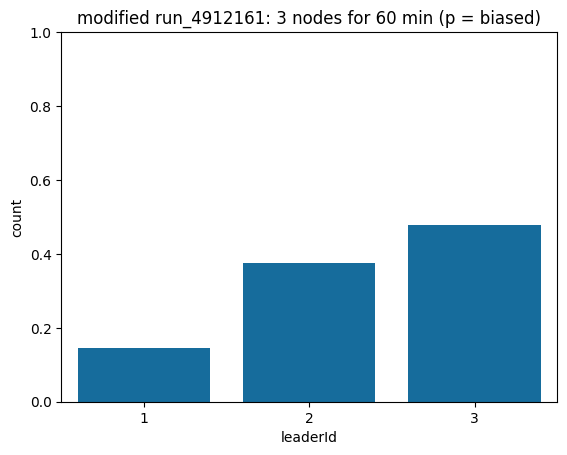

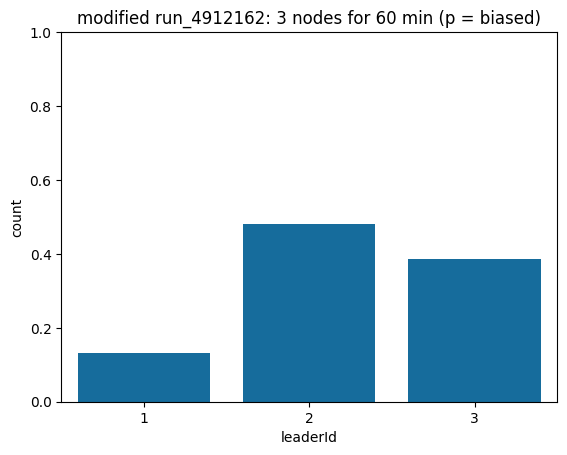

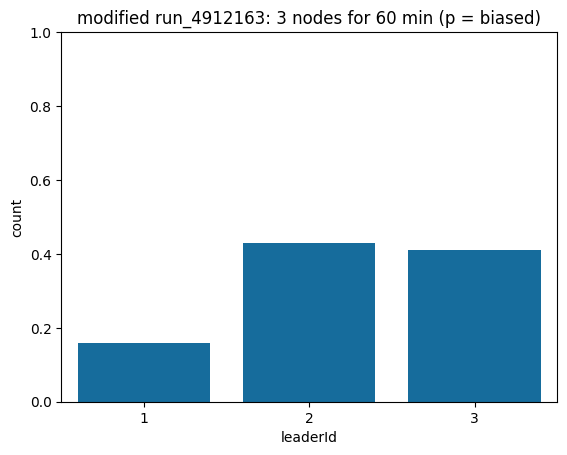

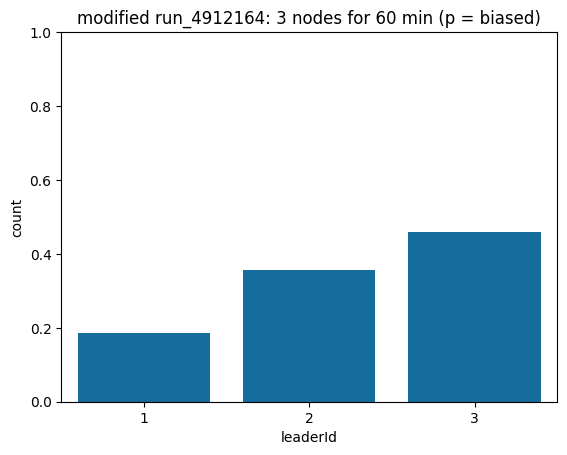

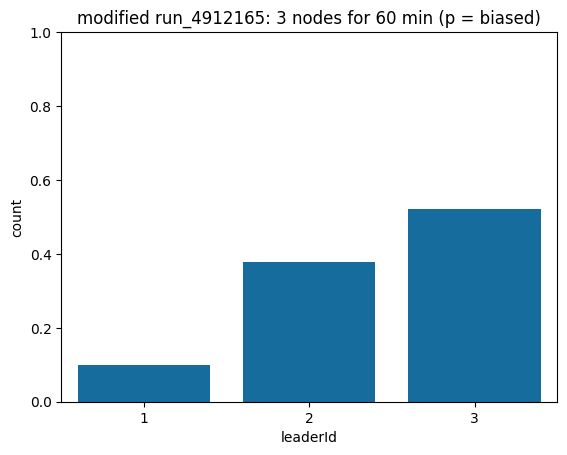

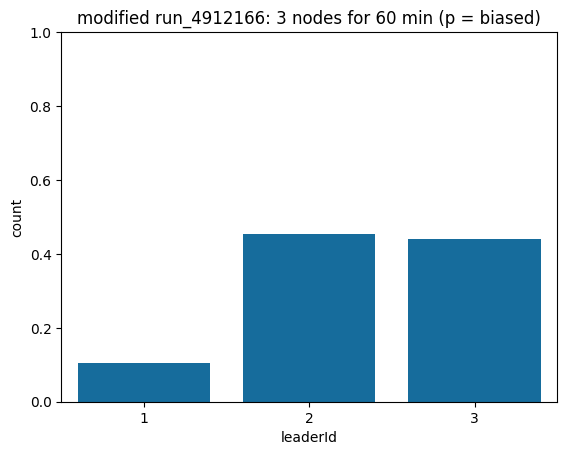

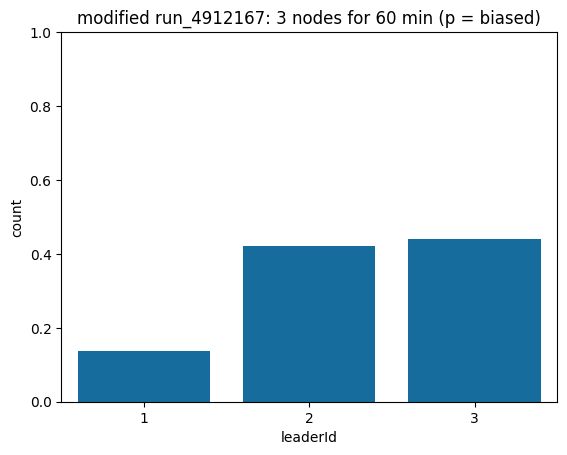

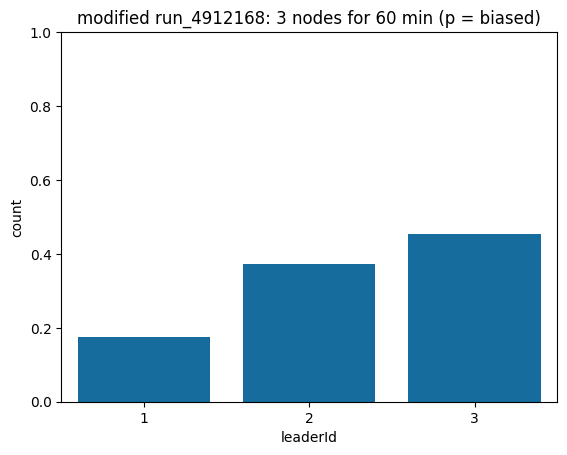

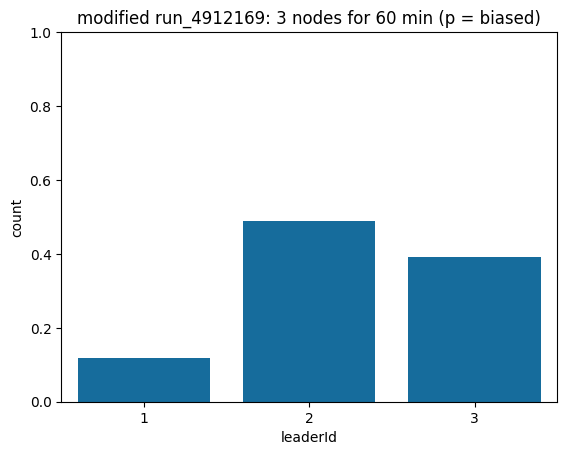

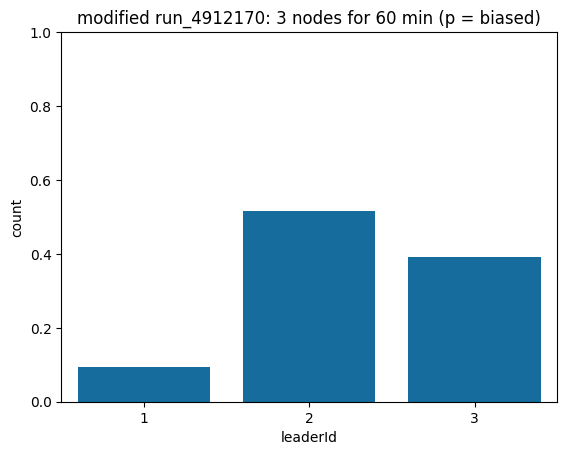

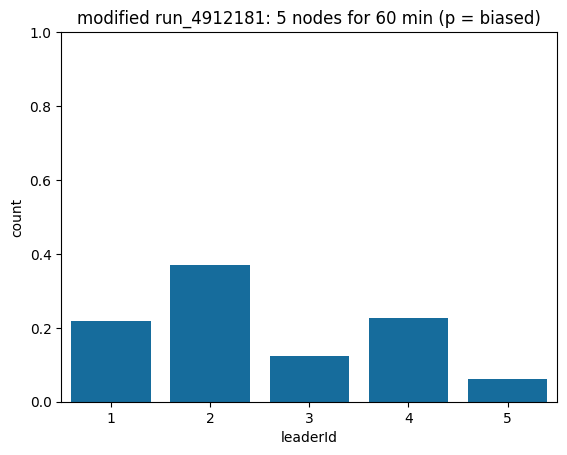

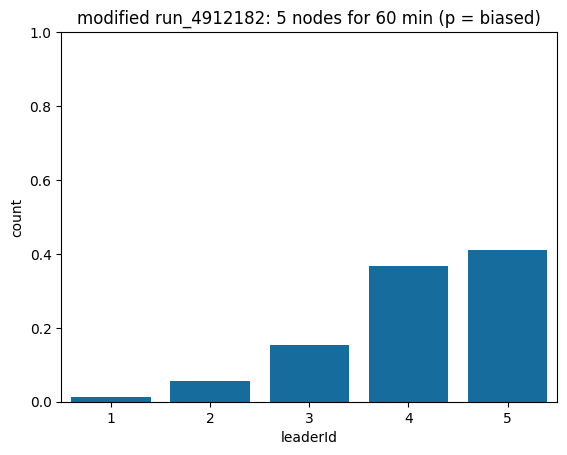

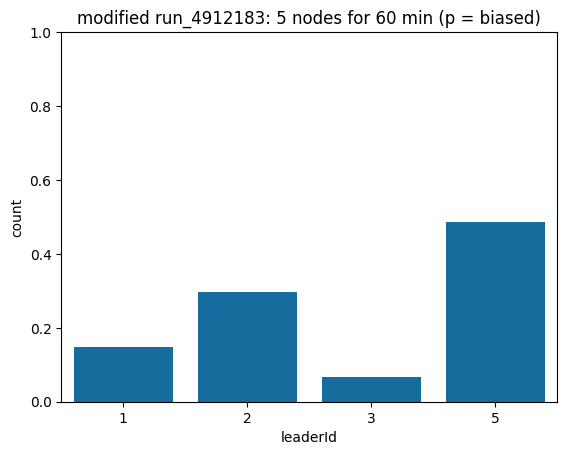

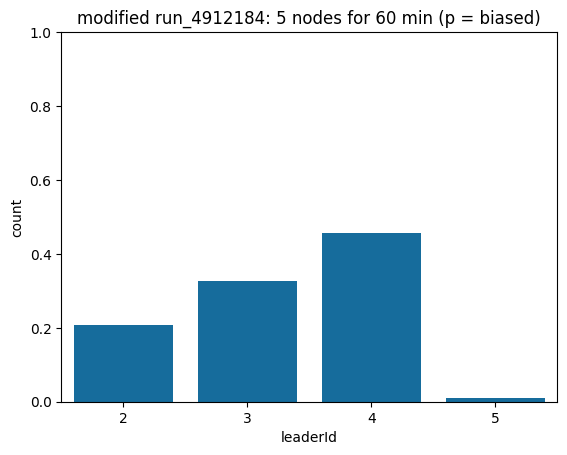

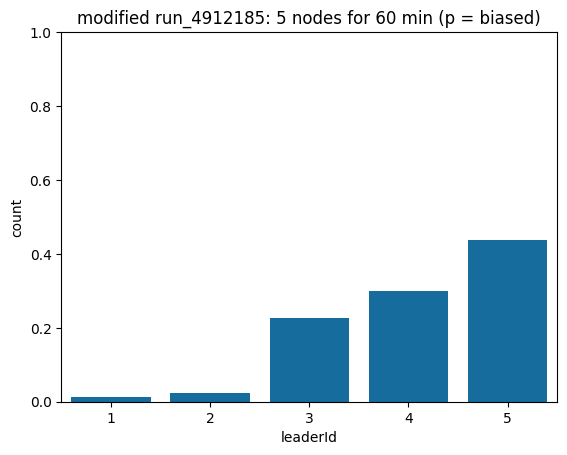

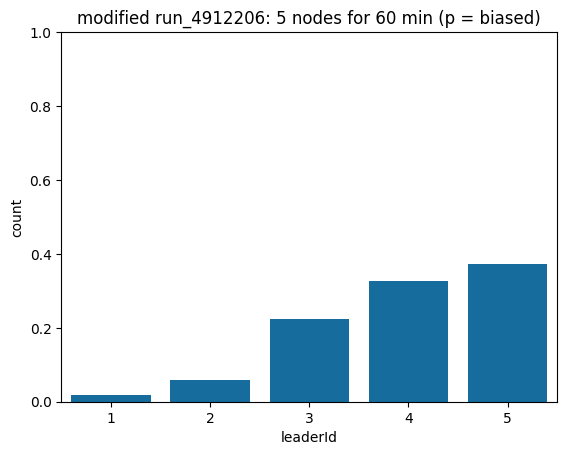

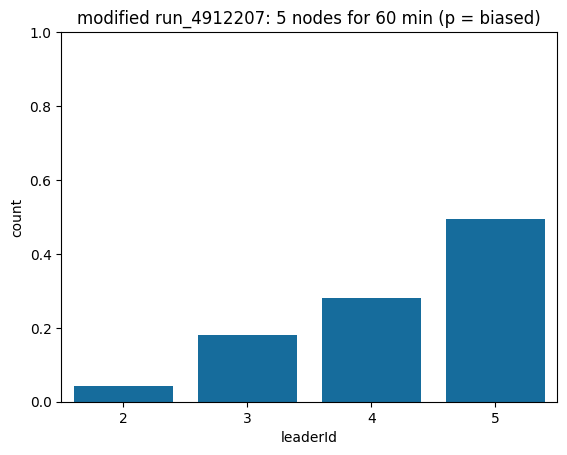

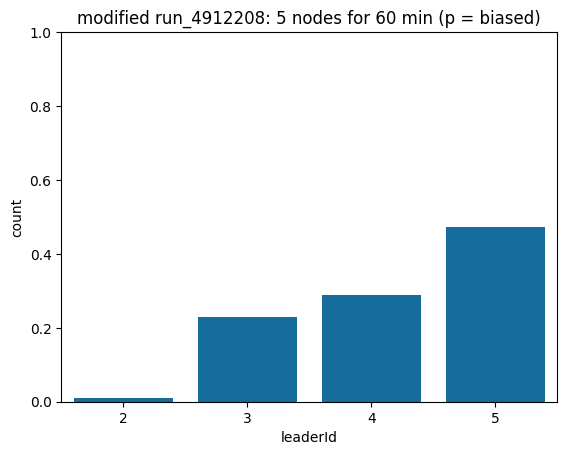

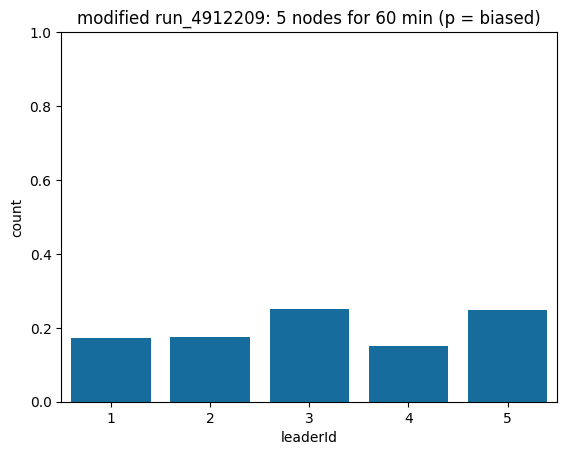

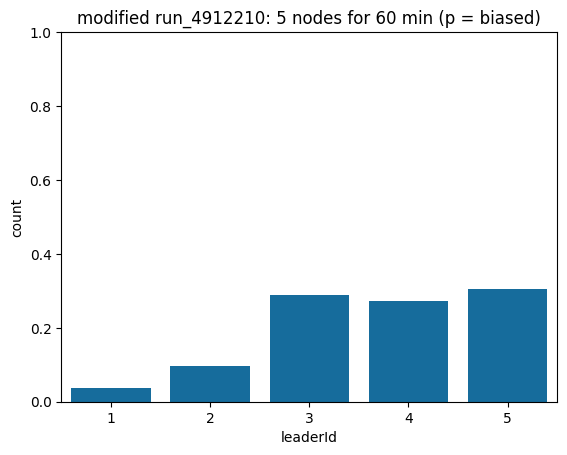

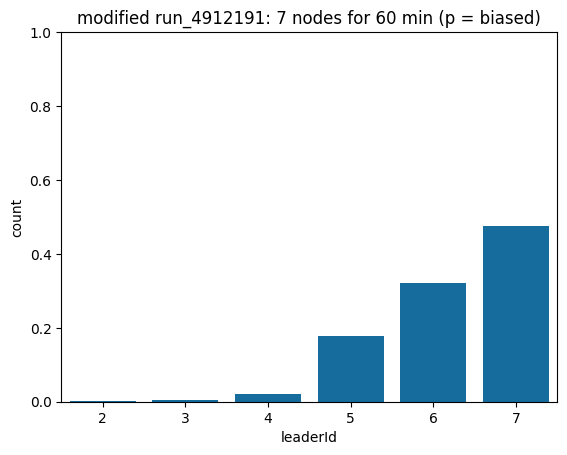

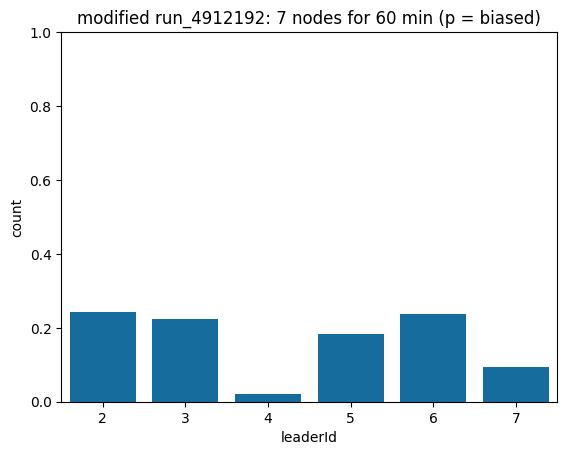

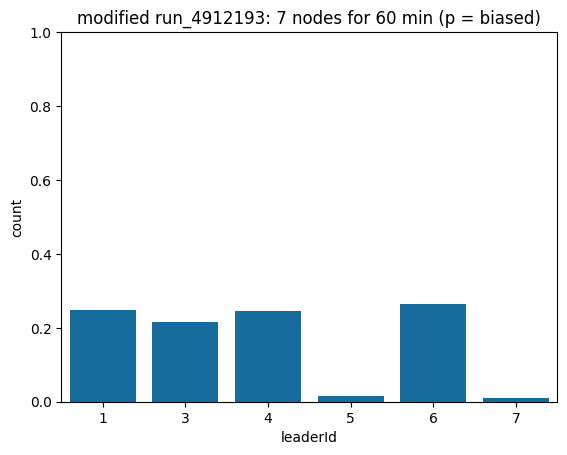

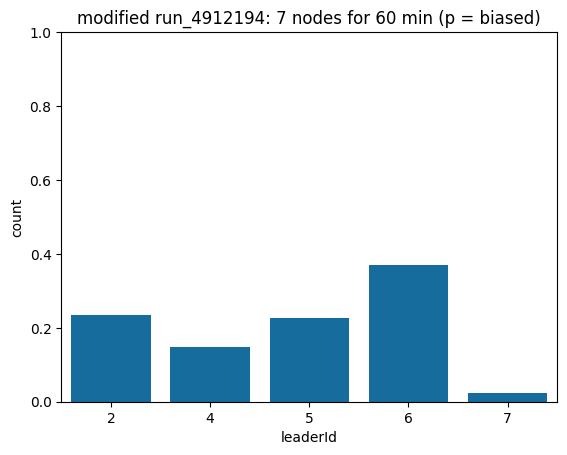

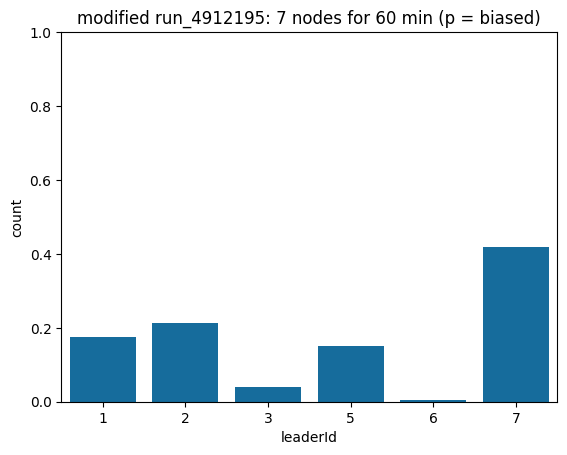

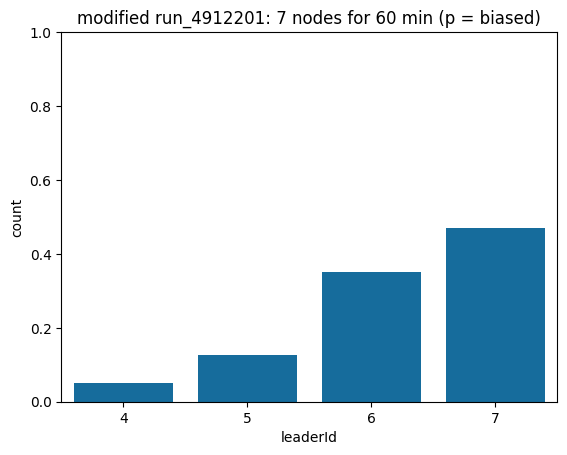

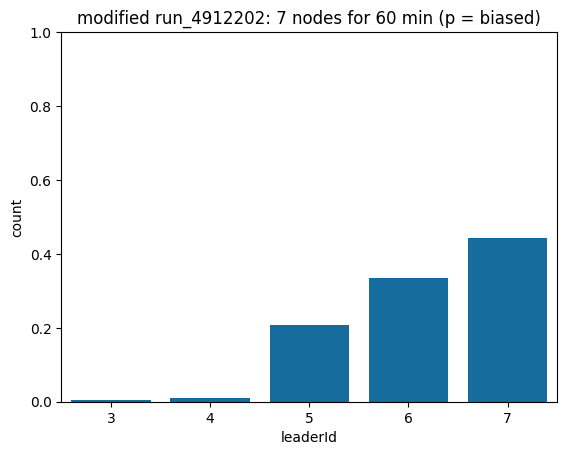

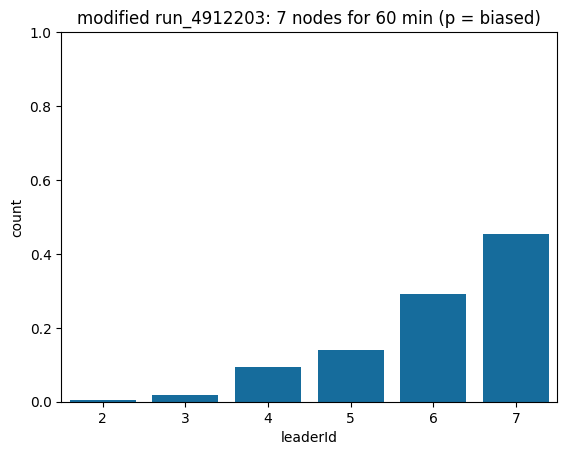

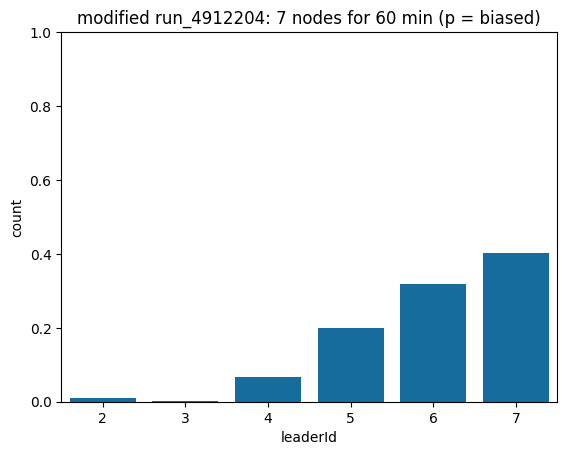

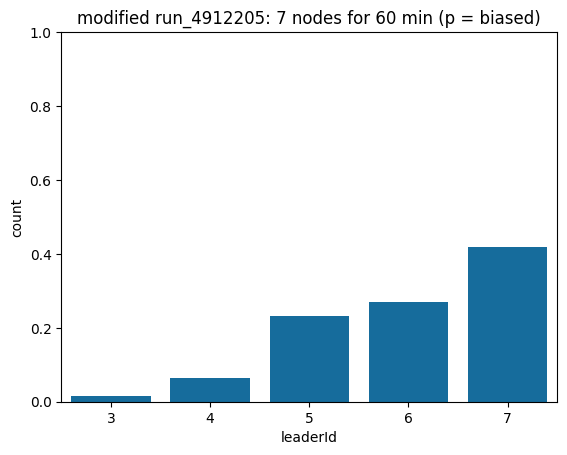

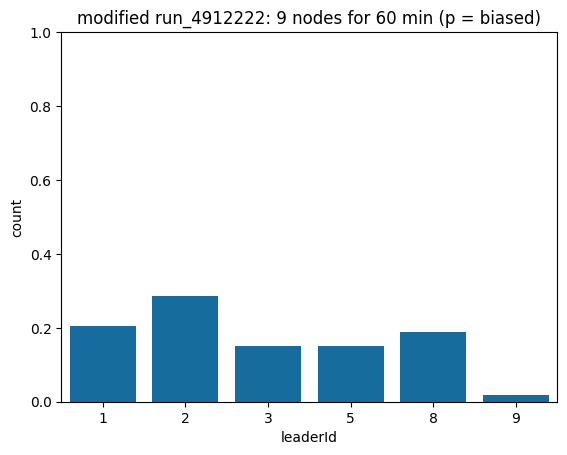

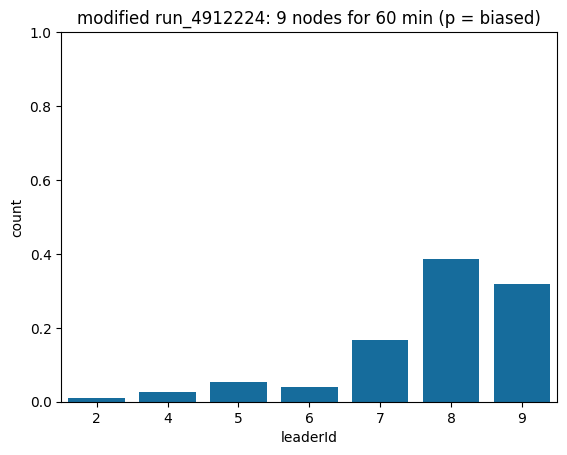

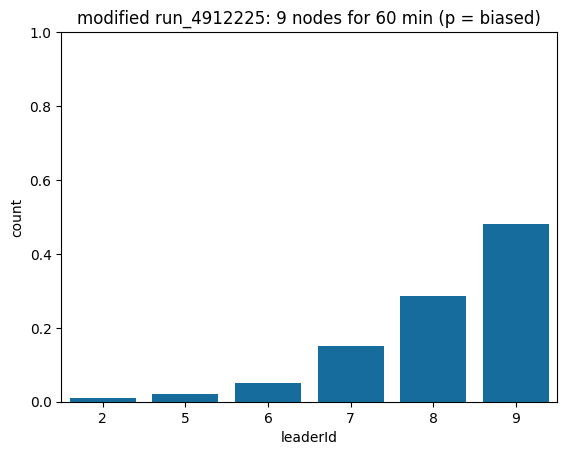

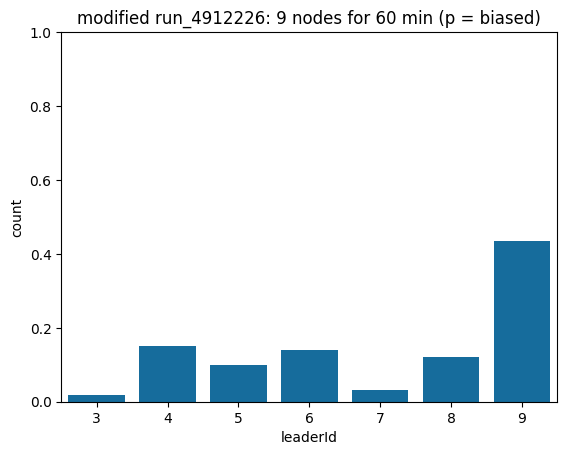

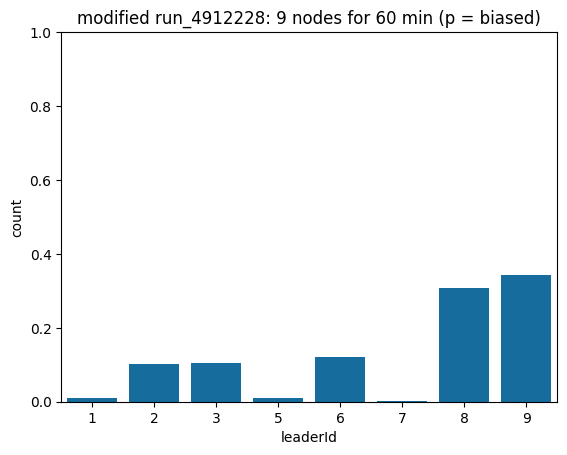

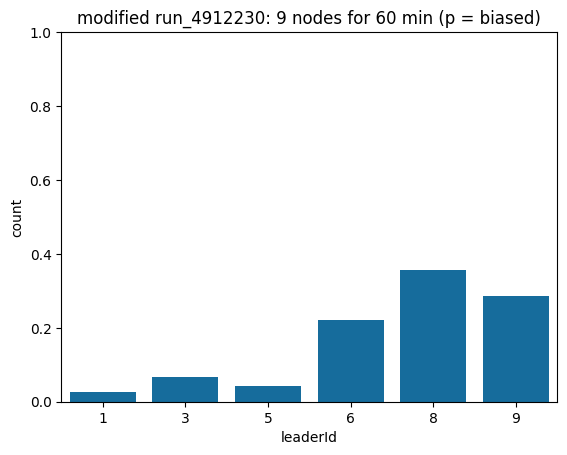

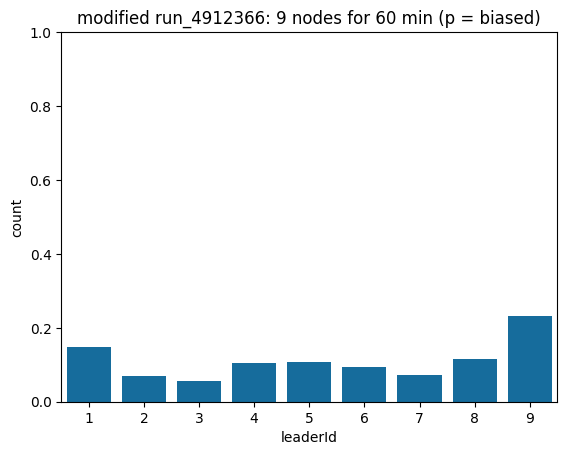

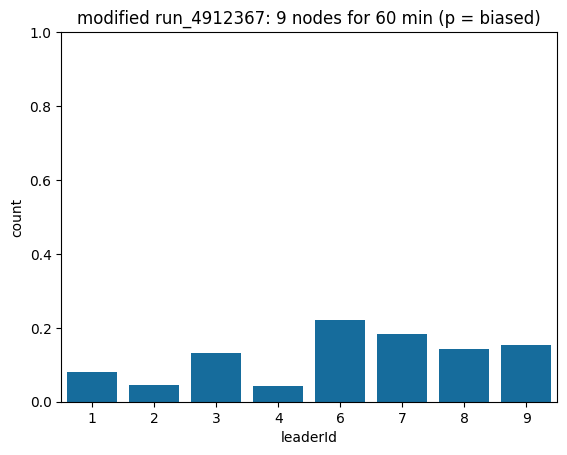

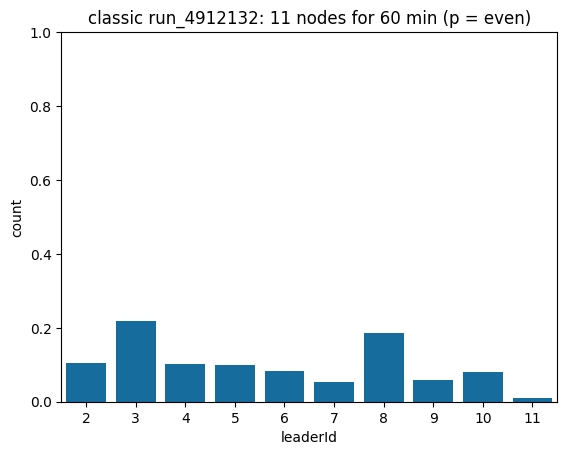

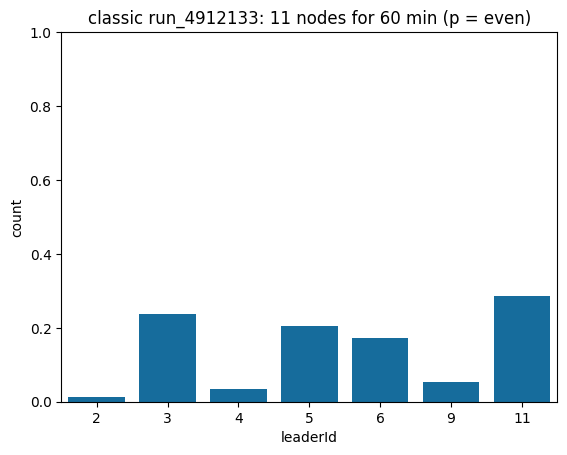

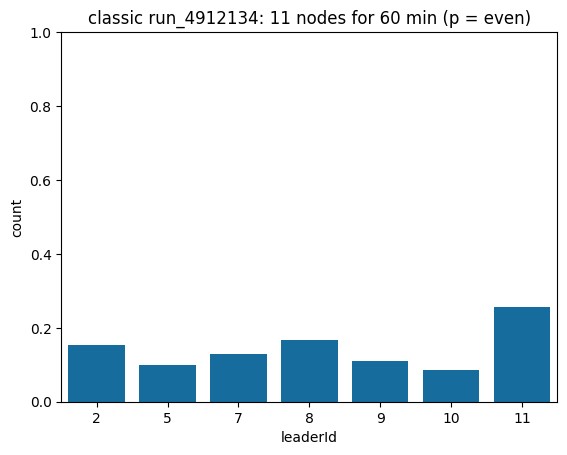

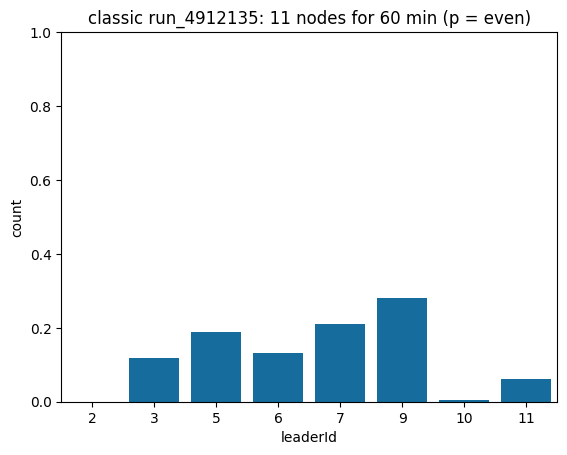

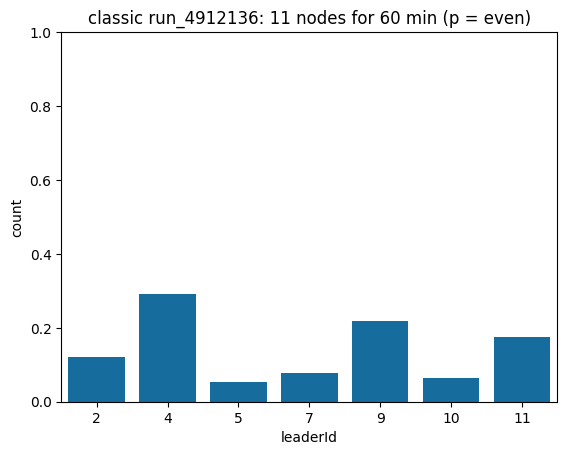

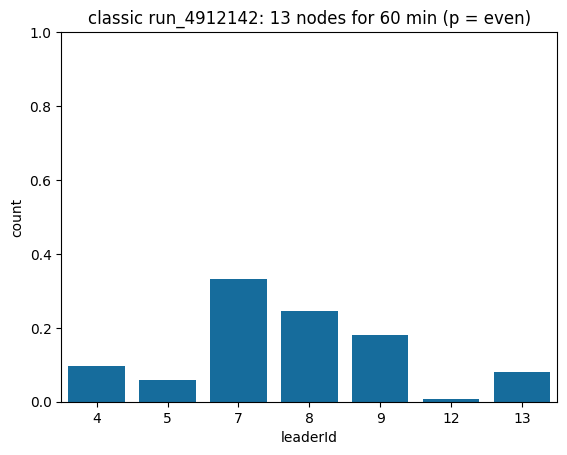

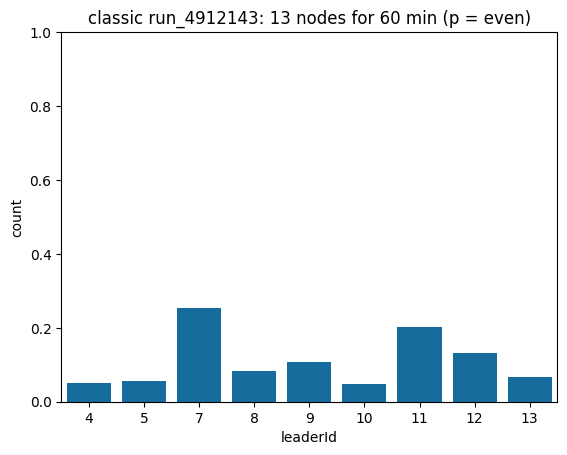

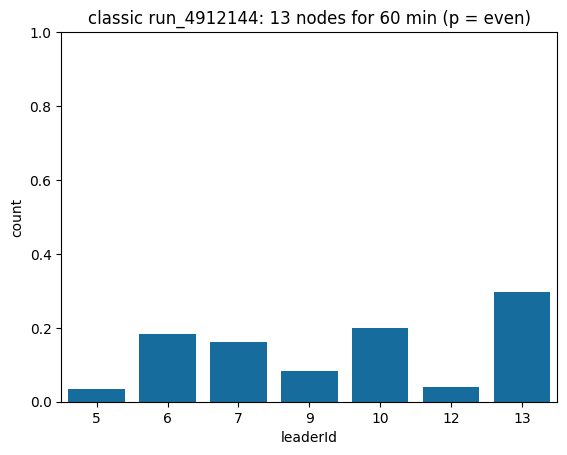

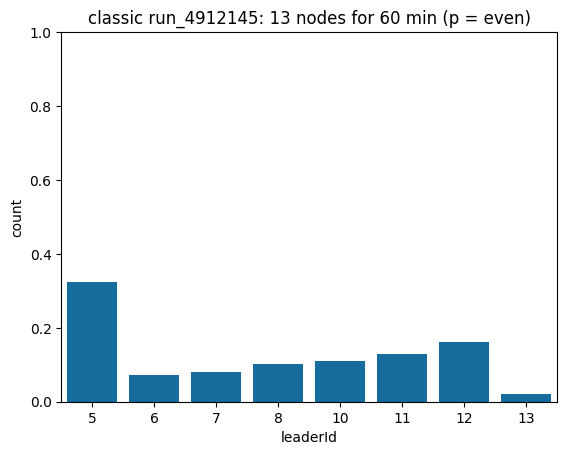

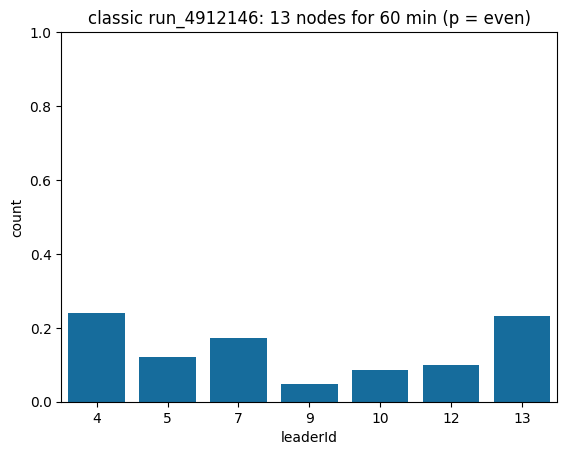

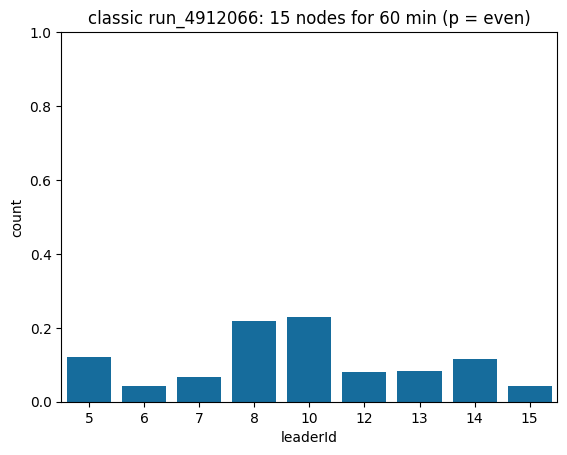

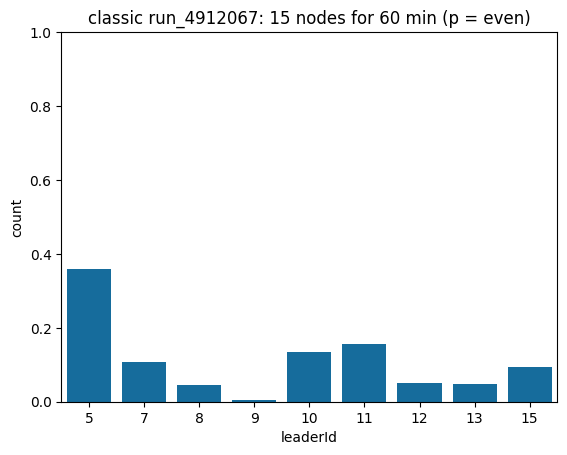

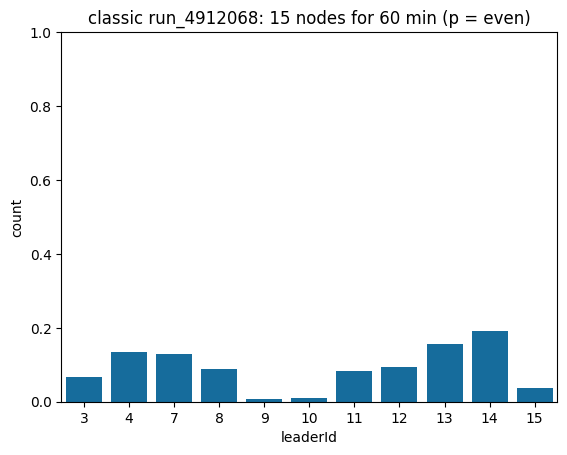

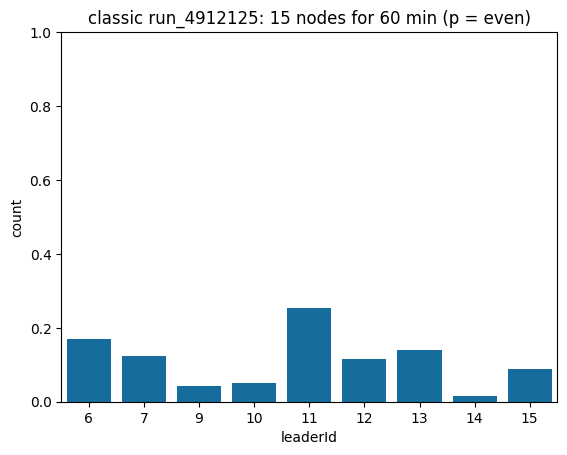

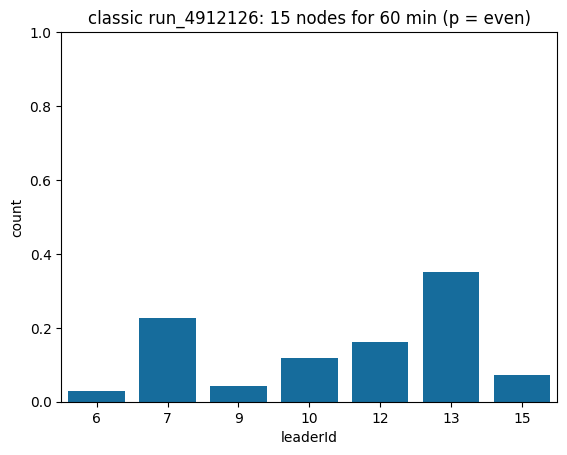

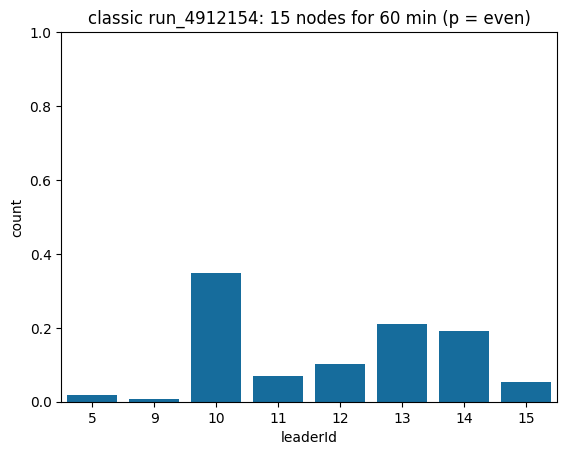

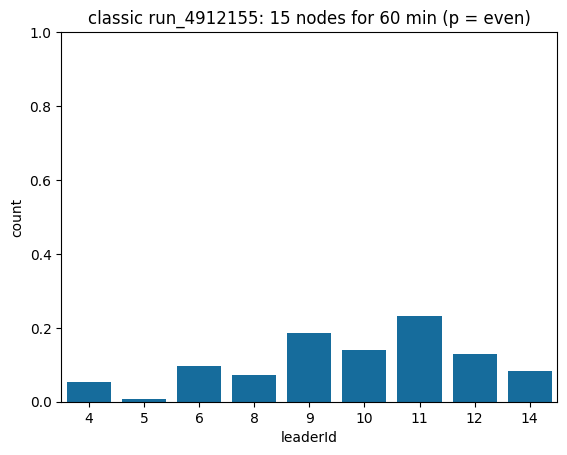

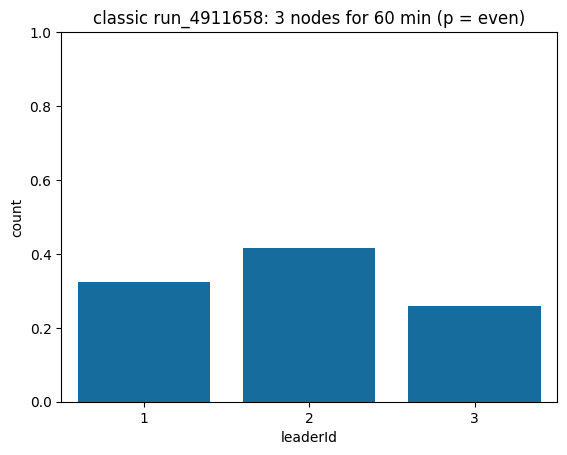

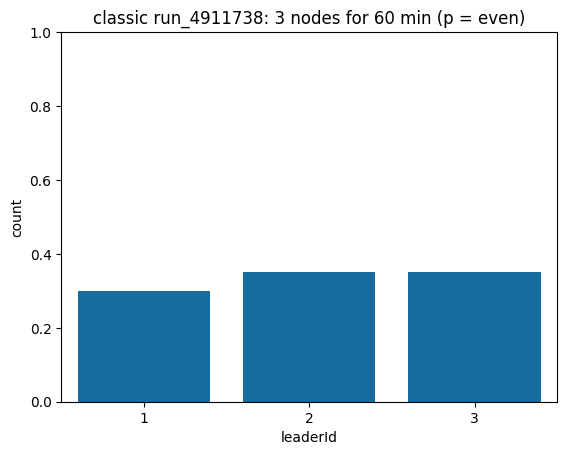

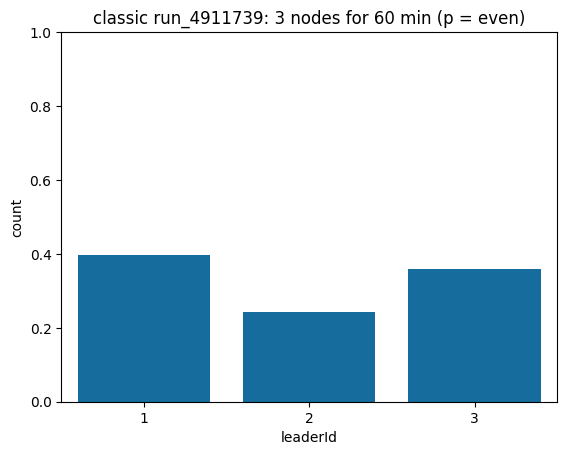

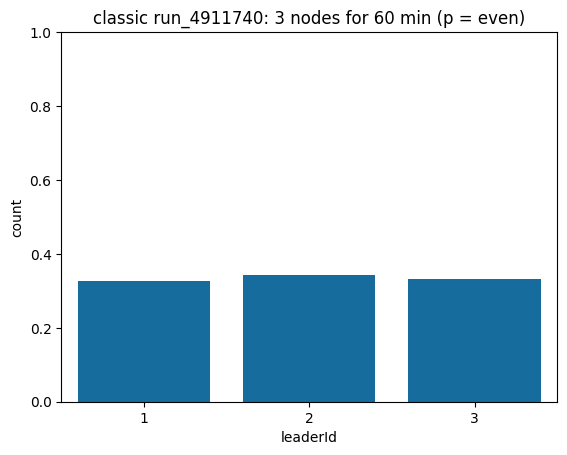

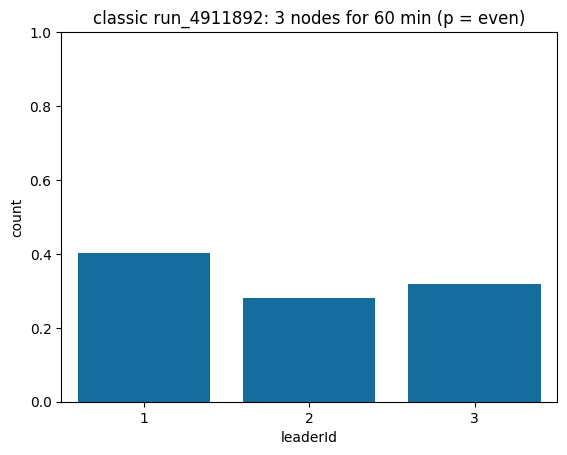

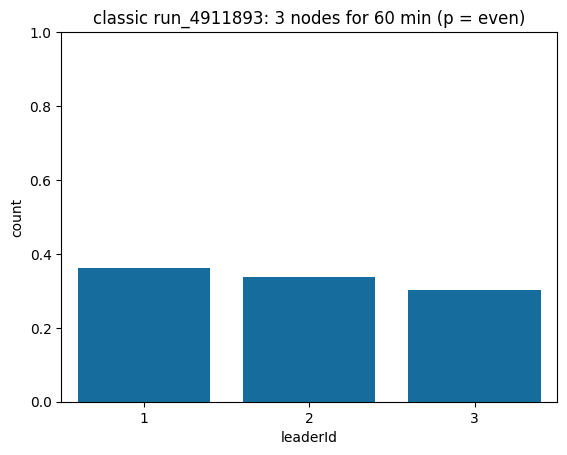

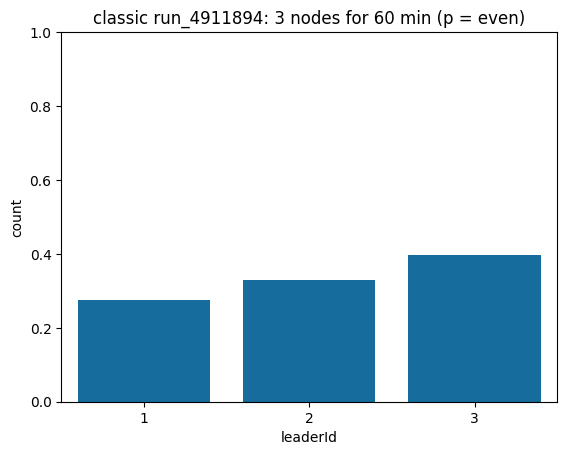

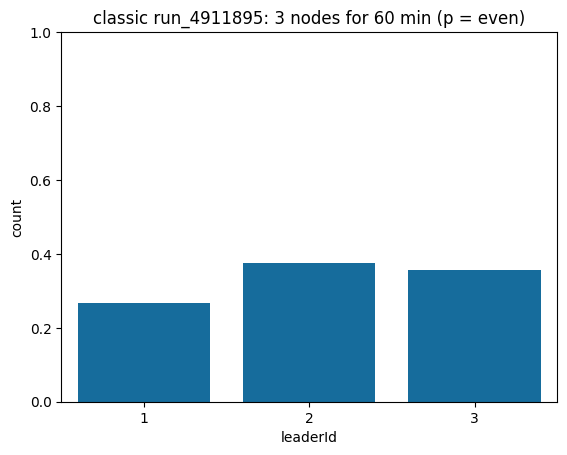

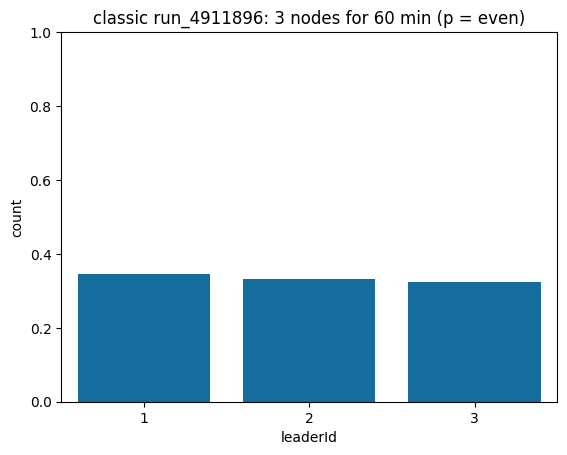

KeyboardInterrupt: 

In [111]:
for file in find_all_csvs("../bench_data/"):
    algo = get_algorithm_type(file)
    nodes = get_node_count(file)
    minutes = get_duration_minutes(file)
    run = get_run_id(file)
    crash_probability = get_probability_type(file)
    plot_leader_commit_counts(open_csv(file), f"{algo} {run}: {nodes} nodes for {minutes} min (p = {crash_probability})")

# Performance

## Entry Throughput

In [ ]:
def find_replicated_count(df : pd.DataFrame, node_count : int) -> int:
    entry_counts = df.groupby('serverId').size()
    committed = []
    for count in entry_counts:
        replicated_count = sum(map(lambda x: x >= count, entry_counts))
        if replicated_count >= node_count:
            committed.append(count)
    return max(committed) if len(committed) > 0 else 0

def find_committed_count(df : pd.DataFrame) -> int:
    return find_replicated_count(df, find_quorum_size(df))

def find_fully_replicated_count(df : pd.DataFrame) -> int:
    return find_replicated_count(df, find_node_count(df))

In [ ]:
def split_logs_by(df : pd.DataFrame, column : str) -> pd.DataFrame:
    logs : list[pd.DataFrame] = []
    for val in df[column].unique():
        logs.append(df[df[column] == val])
    return logs


In [ ]:
def find_replication_delays(df : pd.DataFrame, num_nodes : int):
    logs = split_logs_by(df, "serverId")

    last_replicated = find_replicated_count(df, num_nodes)
    
    delays = []

    for i in range(last_replicated):
        creation_time = min([log.iloc[i]["creationTime"] for log in logs if len(log) > i])
        storage_times = [log.iloc[i]["storageTime"] for log in logs if len(log) > i]
        
        if len(storage_times) < num_nodes:
            delays.append(None)
            print(f"None at {i}. Need {num_nodes}, have {len(storage_times)}")
        else:
            storage_times.sort()
            delays.append(storage_times[num_nodes - 1] - creation_time)
    return delays
        

In [ ]:
import concurrent.futures

def process_data(paths : list[str]) -> pd.DataFrame:
   unprocessed_paths = []
   unprocessed_paths = paths
   existing_df = None

   algorithms = []
   node_counts = []
   durations_minutes = []
   run_ids = []
   dataframes = []
   full_replication_delays = []
   commit_delays = []
   committed_counts = []
   fully_replicated_counts = []
   committed_rates = []
   fully_replicated_rates = []
   longest_logs = []
   crash_probabilities = []


   for file in tqdm(unprocessed_paths):
      df = open_csv(file)

      algorithms.append(get_algorithm_type(file))
      node_counts.append(get_node_count(file))
      durations_minutes.append(get_duration_minutes(file))
      run_ids.append(get_run_id(file))
      dataframes.append(df)
      crash_probabilities.append(get_probability_type(file))
      commit_delays.append(find_replication_delays(df, find_quorum_size(df)))
      committed_counts.append(find_committed_count(df))
      fully_replicated_counts.append(find_fully_replicated_count(df))

      fully_replicated_rates = np.array(fully_replicated_counts) / RUNTIME_SECONDS
      committed_rates = np.array(committed_counts) / RUNTIME_SECONDS

   columns = {"path": paths, 
            "algorithm": algorithms, 
            "crashProbability": crash_probabilities,
            "nodeCount": node_counts, 
            "duration": durations_minutes, 
            "runId": run_ids, 
            "commitDelays": commit_delays,
            "fullReplicationCount": fully_replicated_counts, 
            "commitCount": committed_counts, 
            "fullReplicationRate": fully_replicated_rates,
            "commitRate": committed_rates,
            }
   new_entries = pd.DataFrame(columns)

   if existing_df is None:
      new_entries = new_entries.sort_values(by=["crashProbability", "algorithm", "nodeCount", "runId"])
      return new_entries
   else:
      result = pd.concat([existing_df, new_entries]).sort_values(by=["crashProbability", "algorithm", "nodeCount", "runId"]).reindex()
      return result


paths = find_all_csvs("../bench_data/")
DATA = process_data(paths)
display(DATA)


# with concurrent.futures.ThreadPoolExecutor() as executor:
#     futures = [executor.submit(process_data, [path]) for path in paths]
#     results = [f.result() for f in futures]
#     DATA_EVEN = pd.concat(results)


  0%|          | 0/248 [00:00<?, ?it/s]

100%|██████████| 248/248 [11:31<00:00,  2.79s/it]


path algorithm  \
29   c:\Users\cursa\Documents\University\MSc CS\The...   classic   
30   c:\Users\cursa\Documents\University\MSc CS\The...   classic   
31   c:\Users\cursa\Documents\University\MSc CS\The...   classic   
32   c:\Users\cursa\Documents\University\MSc CS\The...   classic   
33   c:\Users\cursa\Documents\University\MSc CS\The...   classic   
..                                                 ...       ...   
199  c:\Users\cursa\Documents\University\MSc CS\The...  modified   
200  c:\Users\cursa\Documents\University\MSc CS\The...  modified   
201  c:\Users\cursa\Documents\University\MSc CS\The...  modified   
202  c:\Users\cursa\Documents\University\MSc CS\The...  modified   
203  c:\Users\cursa\Documents\University\MSc CS\The...  modified   

    crashProbability  nodeCount  duration        runId  \
29            biased          3        60  run_4912156   
30            biased          3        60  run_4912157   
31            biased          3        60  run_4912158   
32            biased          3        60  run_4912159   
33            biased          3        60  run_4912160   
..               ...        ...       ...          ...   
199             even         13        60  run_4912149   
200             even         13        60  run_4912151   
201             even         15        60  run_4912071   
202             even         15        60  run_4912152   
203             even         15        60  run_4912153   

                                          commitDelays  fullReplicationCount  \
29   [0.027445316314697266, 0.0022003650665283203, ...                 34233   
30   [0.04612588882446289, 0.01931929588317871, 0.0...                 26013   
31   [0.025681734085083008, 0.0023658275604248047, ...                 33572   
32   [0.02800130844116211, 0.0023620128631591797, 0...                 32926   
33   [0.06799817085266113, 0.03813672065734863, 0.0...                 25122   
..                                                 ...                   ...   
199  [0.040947914123535156, 0.011287450790405273, 0...                    98   
200  [0.04176640510559082, 0.008436918258666992, 0....                   119   
201  [0.05054450035095215, 0.013065338134765625, 0....                   116   
202  [0.045465707778930664, 0.008148431777954102, 0...                   130   
203  [0.0456695556640625, 0.009067535400390625, 0.0...                   132   

     commitCount  fullReplicationRate  commitRate  
29         34233             9.509167    9.509167  
30         26013             7.225833    7.225833  
31         33597             9.325556    9.332500  
32         32927             9.146111    9.146389  
33         25122             6.978333    6.978333  
..           ...                  ...         ...  
199         7598             0.027222    2.110556  
200         6110             0.033056    1.697222  
201         6395             0.032222    1.776389  
202         4344             0.036111    1.206667  
203         5596             0.036667    1.554444  

[248 rows x 11 columns]

In [ ]:
for file in FILES:
    df = open_csv(file)
    print(f"{file.split("bench_data", maxsplit=1)[1]}:\t committed {find_committed_count(df)}/{find_replicated_count(df, 1)},\t fully replicated {find_fully_replicated_count(df)}/{find_replicated_count(df, 1)}")

\biased\classic\11_nodes\60_minutes\run_4912262\data_run_4912262.csv:	 committed 11575/12573,	 fully replicated 413/12573
\biased\classic\11_nodes\60_minutes\run_4912263\data_run_4912263.csv:	 committed 8806/10392,	 fully replicated 143/10392
\biased\classic\11_nodes\60_minutes\run_4912264\data_run_4912264.csv:	 committed 9891/11011,	 fully replicated 165/11011
\biased\classic\11_nodes\60_minutes\run_4912265\data_run_4912265.csv:	 committed 8486/9827,	 fully replicated 313/9827
\biased\classic\11_nodes\60_minutes\run_4912266\data_run_4912266.csv:	 committed 8226/9082,	 fully replicated 208/9082
\biased\classic\11_nodes\60_minutes\run_4912382\data_run_4912382.csv:	 committed 6868/11492,	 fully replicated 193/11492
\biased\classic\11_nodes\60_minutes\run_4912383\data_run_4912383.csv:	 committed 26280/29789,	 fully replicated 23317/29789
\biased\classic\11_nodes\60_minutes\run_4912386\data_run_4912386.csv:	 committed 3918/9032,	 fully replicated 147/9032
\biased\classic\11_nodes\60_minute

In [ ]:
def get_col_from_all(data : pd.DataFrame, colname : str, algo : str = None, nodes : str = None, crashProb = None):
    filtered = data
    if not algo is None:
        filtered = filtered[filtered["algorithm"] == algo]
    if not crashProb is None:
        filtered = filtered[filtered["crashProbability"] == crashProb]
    if not nodes is None:
        filtered = filtered[filtered["nodeCount"] == nodes]
    
    if colname in ["fullReplicationDelays", "commitDelays"]:
        nested_lists = filtered[colname].tolist()
        return sum(nested_lists, start=[])
    else:
        return filtered[colname]

# Commit Latency Plots

In [206]:
def plot_commit_latencies(df : pd.DataFrame, algos = None, nodes = None, probs = None, size : tuple[int, int] = (10,5)):
    if algos is None or len(algos) == 0:
        algos = df["algorithm"].unique().tolist()
    if nodes is None or len(nodes) == 0:
        nodes = df["nodeCount"].unique().tolist()
    if probs is None or len(probs) == 0:
        probs = df["crashProbability"].unique().tolist()
    
    lines = len(algos) * len(nodes) * len(probs)
    colors_needed = lines // 2 if len(algos) > 1 or len(probs) > 1 else lines
    palette = COLOR_PALETTE[ : colors_needed]

    sns.set_palette(sns.color_palette(palette))
    plt.figure(figsize=size)
    line_label_elements = []
    for idx_algo, algo in enumerate(algos):
        for idx_prob, crash_prob in enumerate(probs):
            for idx_node, node in enumerate(nodes):
                line_label_elements = []
                if len(algos) > 1:
                    line_label_elements.append(algo)
                if len(probs) > 1:
                    line_label_elements.append(crash_prob)
                if len(nodes) > 1:
                    line_label_elements.append(f"{node} nodes")
                
                line_label = " ".join(line_label_elements)
                line_color = palette[ (idx_algo + idx_node + idx_prob) % len(palette) ]

                data = get_col_from_all(df, "commitDelays", algo, node, crash_prob)
                sns.ecdfplot(data, label=line_label)

                dashed = False
                if (len(algos) > 1 and algo == 'modified'):
                    dashed = True
                elif (len(probs) > 1 and crash_prob == 'even'):
                    dashed = True
                if dashed:
                    [line.set_linestyle("--") for line in plt.gca().lines if line.get_label() == line_label]
                        
    

    title_elements = []
    if len(algos) == 1:
        title_elements.append(algo)
    if len(probs) == 1:
        title_elements.append(crash_prob)
    if len(nodes) == 1:
        title_elements.append(f"{node} nodes")


    # plt.axhline(y=0.5, color='r', linestyle=':')
    # plt.axhline(y=0.05, color='r', linestyle='--')

        

    plt.title(f'{" ".join(title_elements)} commit latencies')
    plt.xlabel("Latency [seconds]")

    plt.yscale('log')
    plt.xscale('log')
    plt.xticks([10**exp for exp in range(-7, 3)])
    plt.ylim(10**(-3), 1)

    plt.grid(visible=True)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, length=7)
    ax.tick_params(axis='both', which='minor', width=1, length=5)
    plt.legend()
    plt.show()

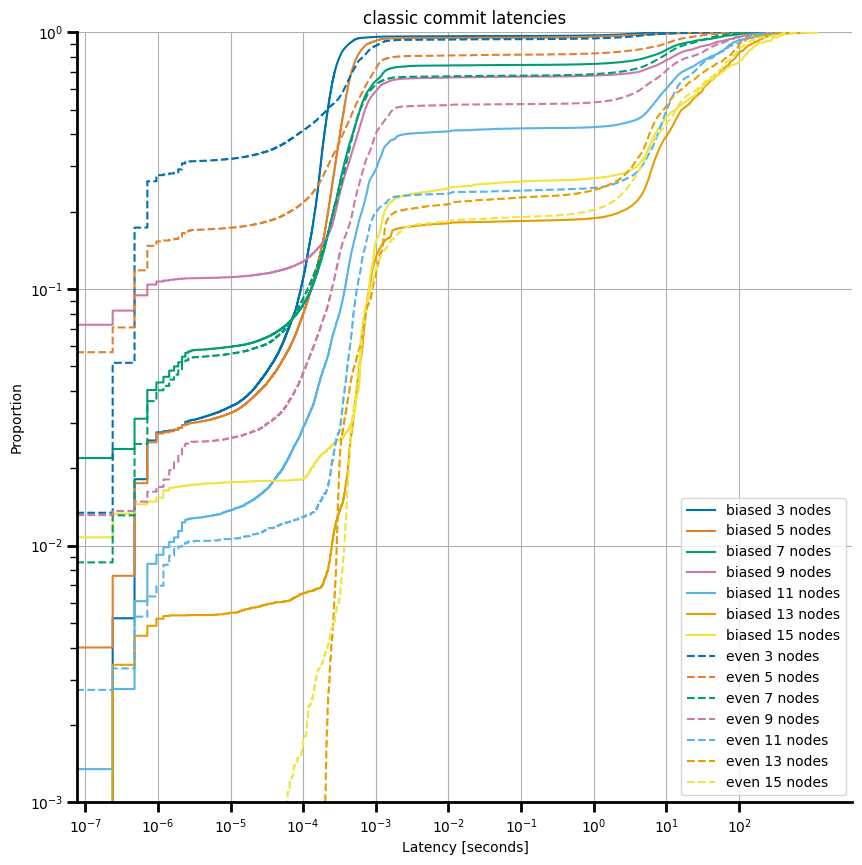

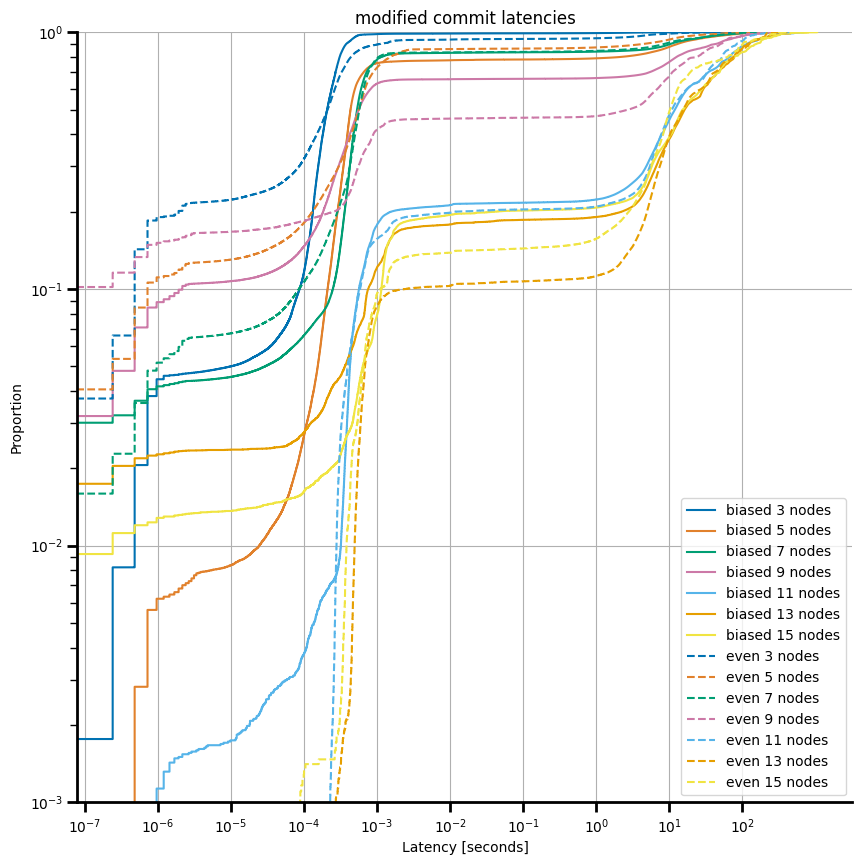

In [207]:
plot_commit_latencies(DATA, nodes=[], algos=["classic"], probs=None, size=(10,10))
plot_commit_latencies(DATA, nodes=[], algos=["modified"], probs=None, size=(10,10))


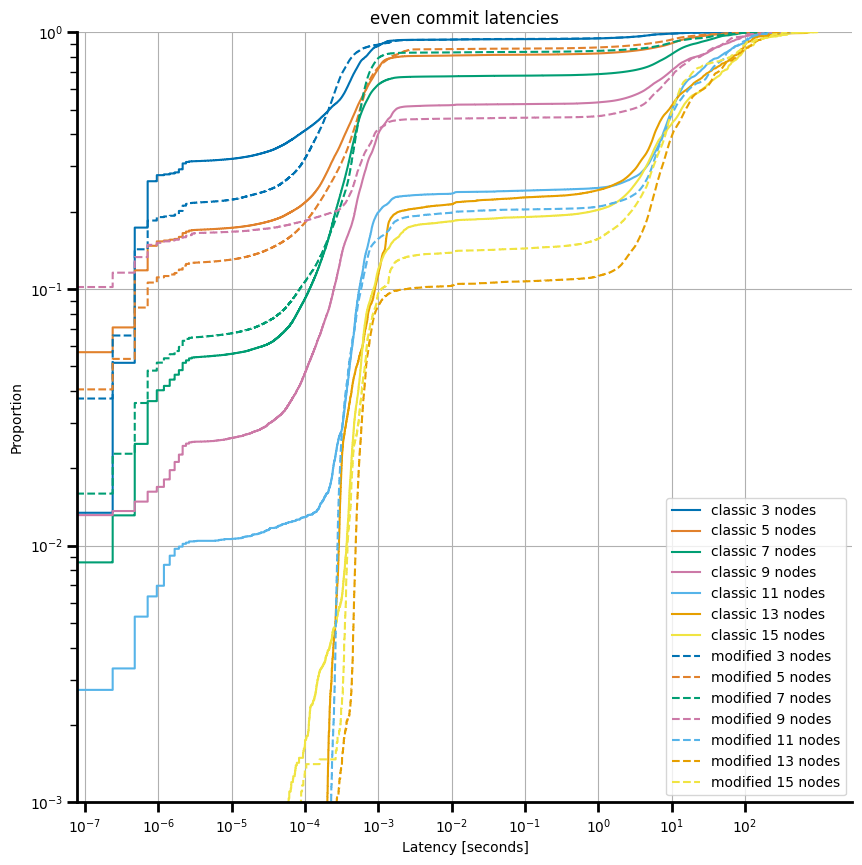

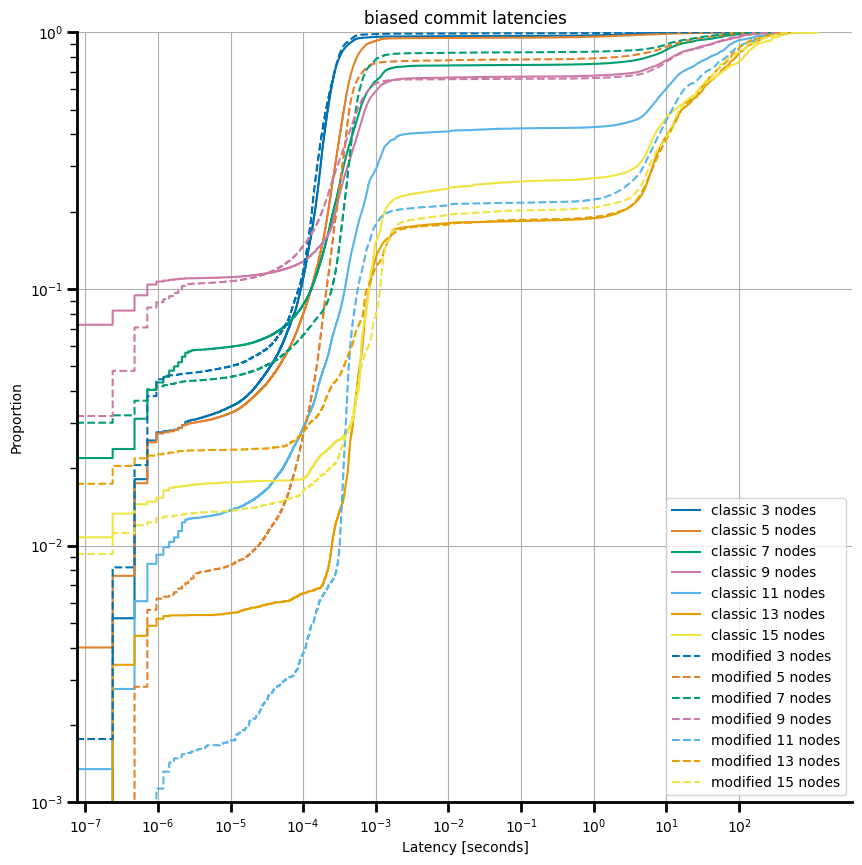

In [208]:
plot_commit_latencies(DATA, nodes=[], algos=None, probs=['even'], size=(10,10))
plot_commit_latencies(DATA, nodes=[], algos=None, probs=['biased'], size=(10,10))

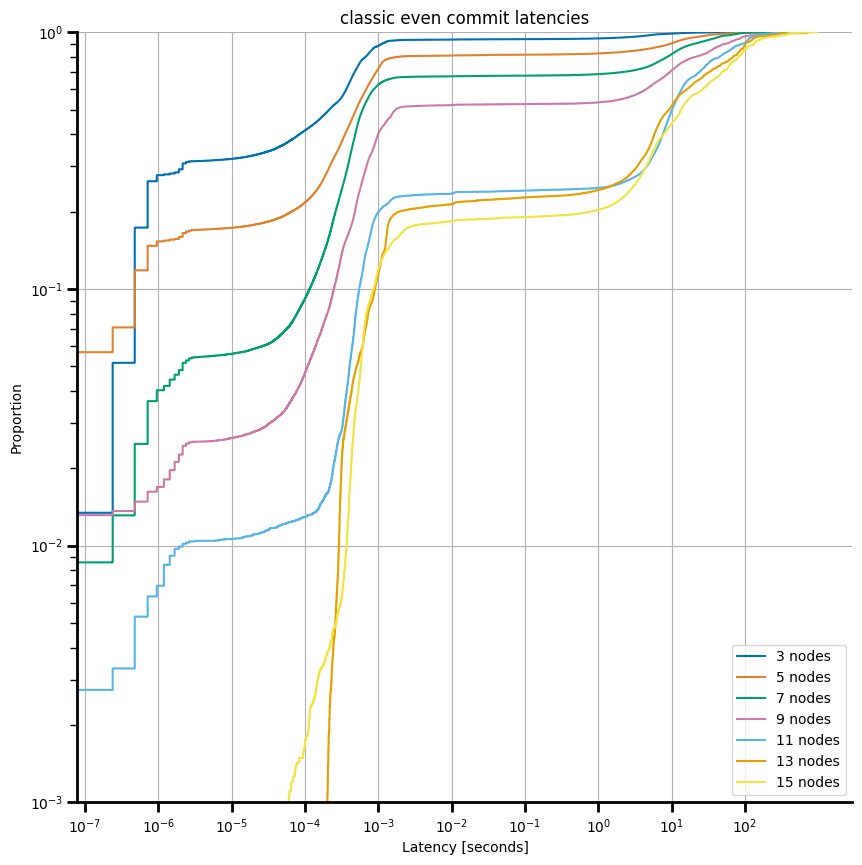

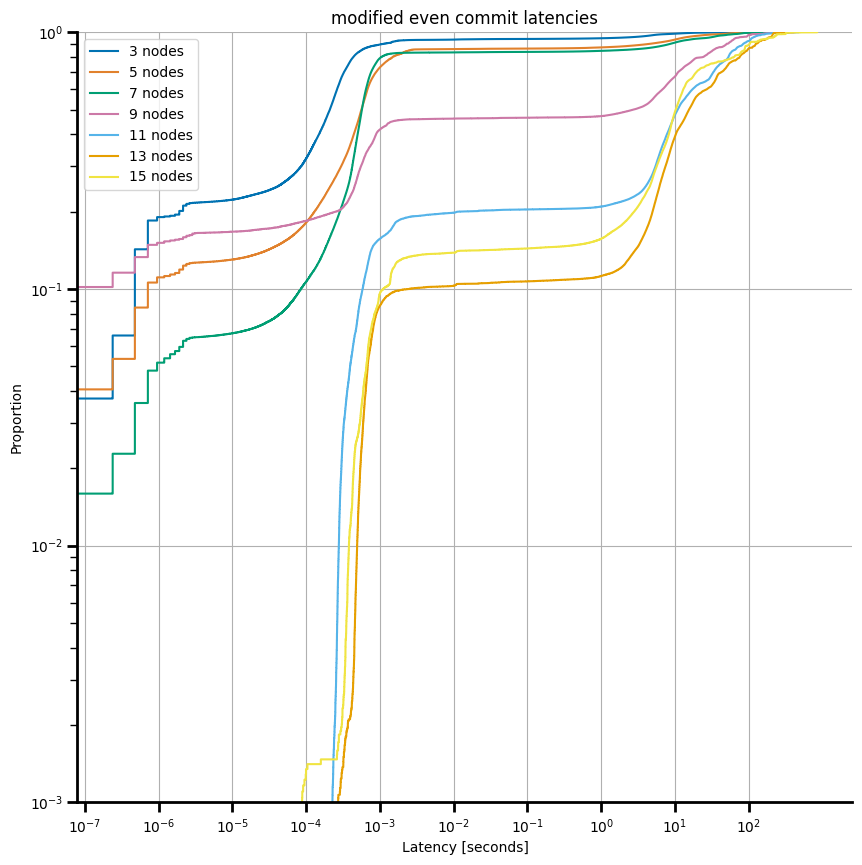

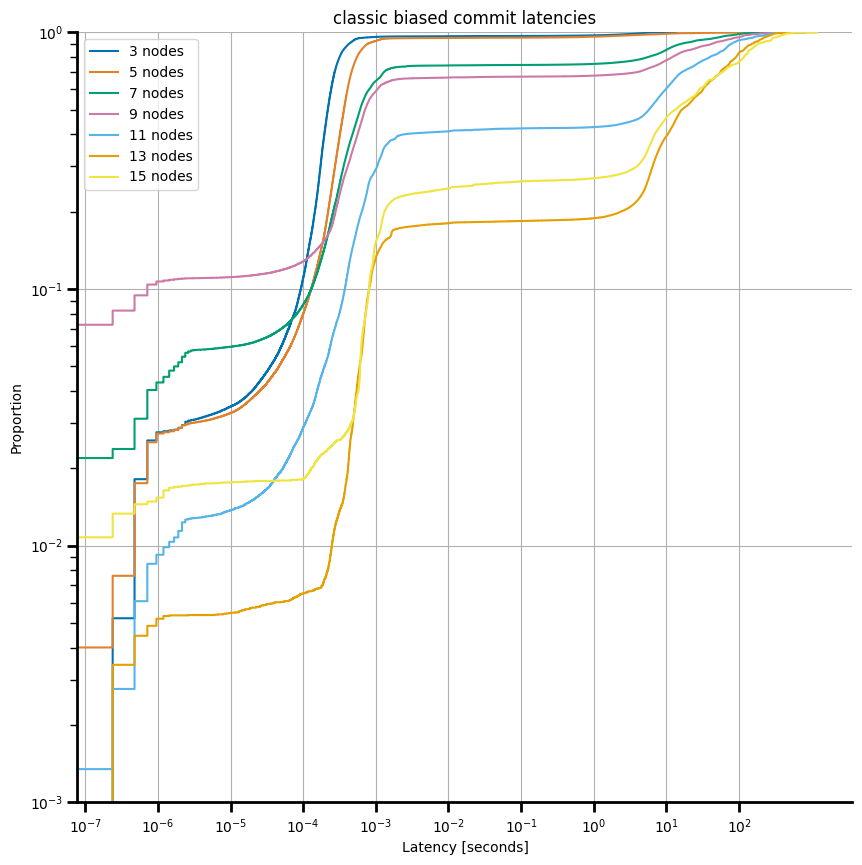

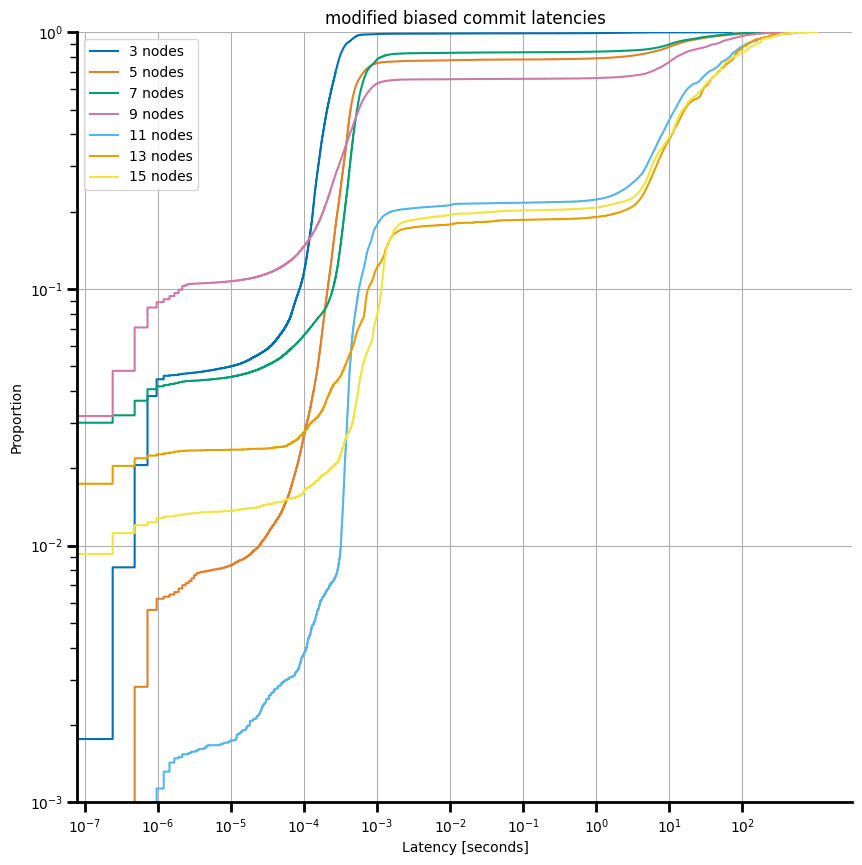

In [209]:
plot_commit_latencies(DATA, nodes=[], algos=["classic"], probs=['even'], size=(10,10))
plot_commit_latencies(DATA, nodes=[], algos=["modified"], probs=['even'], size=(10,10))
plot_commit_latencies(DATA, nodes=[], algos=["classic"], probs=['biased'], size=(10,10))
plot_commit_latencies(DATA, nodes=[], algos=["modified"], probs=['biased'], size=(10,10))

# Commit Rate Plots

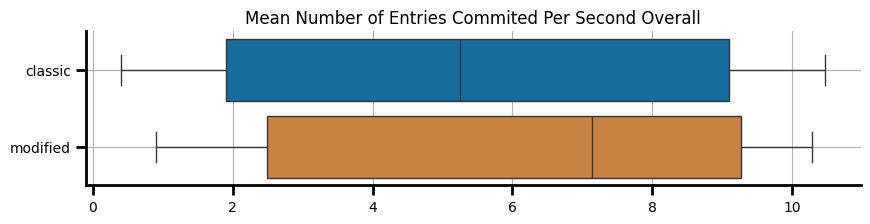

In [210]:
classic = get_col_from_all(DATA, "commitRate", algo="classic")
modified = get_col_from_all(DATA, "commitRate", algo="modified")

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

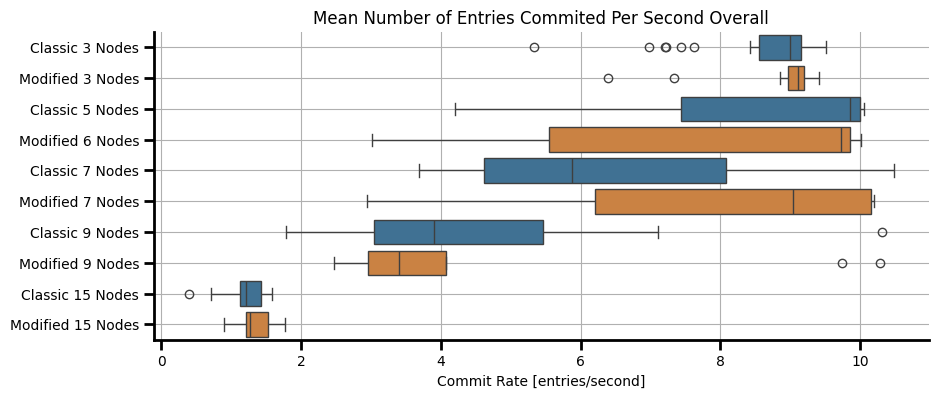

In [211]:
data = pd.DataFrame({
    "Classic 3 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=3),
    "Modified 3 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=3),
    "Classic 5 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=5),
    "Modified 6 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=5),
    "Classic 7 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=7),
    "Modified 7 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=7),
    "Classic 9 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=9),
    "Modified 9 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=9),
    "Classic 15 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=15),
    "Modified 15 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=15)
})

alternatic_palette = ['#3274A1', '#E1812C'] * 5

plt.figure(figsize=(10,4))
sns.boxplot(data, orient='h', palette=alternatic_palette)
plt.title("Mean Number of Entries Commited Per Second Overall")
plt.xlabel("Commit Rate [entries/second]")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

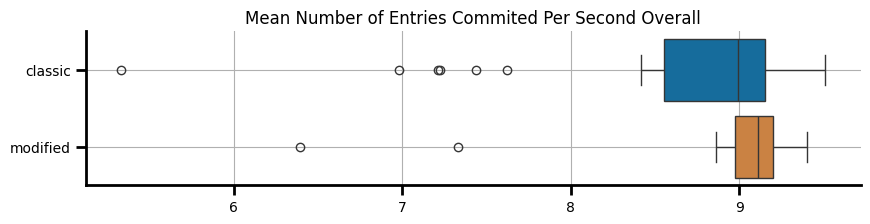

In [212]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=3)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=3)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

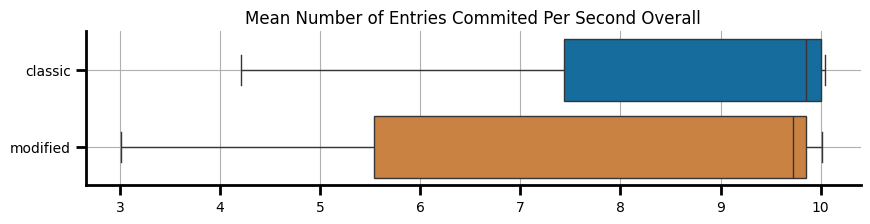

In [213]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=5)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=5)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

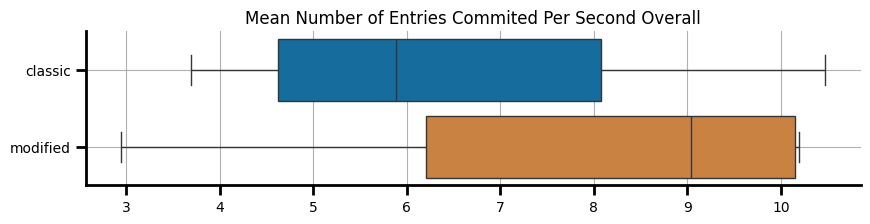

In [214]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=7)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=7)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

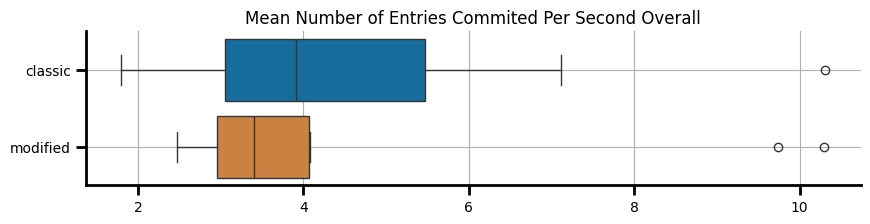

In [215]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=9)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=9)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

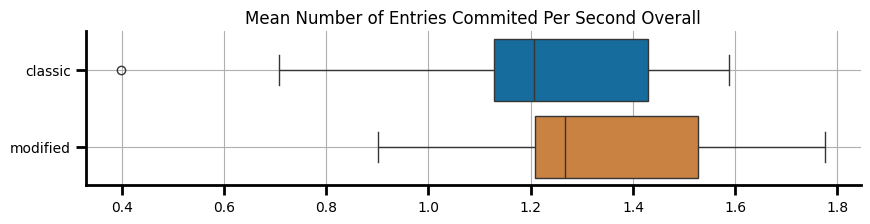

In [216]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=15)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=15)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

# Term Count Plots

In [217]:
def count_terms(file : str) -> tuple[int, int]:
    df = open_csv(file)
    terms_seen = df["term"].unique()
    num_productive_terms = len(terms_seen)
    num_empty_terms = terms_seen.max() - num_productive_terms
    return num_productive_terms, num_empty_terms


def get_terms(file : str) -> tuple[list[int], list[int]]:
    df = open_csv(file)
    terms_seen = df["term"].unique().tolist()
    terms_missed = [term for term in range(max(terms_seen)) if not term in terms_seen]
    return terms_seen, terms_missed

In [218]:
#TODO change this to actuall make plots for this not ECDFs 

def plot_term_counts(df : pd.DataFrame, term_type : str, algos = None, nodes = None, probs = None, size : tuple[int, int] = (10,5)):
    if algos is None or len(algos) == 0:
        algos = df["algorithm"].unique().tolist()
    if nodes is None or len(nodes) == 0:
        nodes = df["nodeCount"].unique().tolist()
    if probs is None or len(probs) == 0:
        probs = df["crashProbability"].unique().tolist()
    
    lines = len(algos) * len(nodes) * len(probs)
    palette = COLOR_PALETTE[ : (lines//2)]

    data_to_plot = {}

    sns.set_palette(sns.color_palette(palette))
    plt.figure(figsize=size)
    line_label_elements = []
    for idx_algo, algo in enumerate(algos):
        for idx_prob, crash_prob in enumerate(probs):
            for idx_node, node in enumerate(nodes):
                line_label_elements = []
                if len(algos) > 1:
                    line_label_elements.append(algo)
                if len(probs) > 1:
                    line_label_elements.append(crash_prob)
                if len(nodes) > 1:
                    line_label_elements.append(f"{node} nodes")
                
                line_label = " ".join(line_label_elements)

                files = df[(df["algorithm"] == algo) & (df["nodeCount"] == node) & (df["crashProbability"] == crash_prob)]["path"]
                term_counts = [count_terms(file)[0] if term_type == 'productive' else count_terms(file)[1] for file in files]
                data_to_plot[line_label] = term_counts
                
                sns.boxplot(data_to_plot, orient='h')
    

    title_elements = []
    if len(algos) == 1:
        title_elements.append(algo)
    if len(probs) == 1:
        title_elements.append(crash_prob)
    if len(nodes) == 1:
        title_elements.append(f"{node} nodes")

    plt.title(f'{" ".join(title_elements)} {term_type} term counts')
    plt.xlabel("Productive Terms")

    data_max = max(sum(list(data_to_plot.values()), []))
    plt.xlim(0, min(data_max + 25, 800))

    plt.grid(visible=True)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, length=7)
    ax.tick_params(axis='both', which='minor', width=1, length=5)
    plt.show()

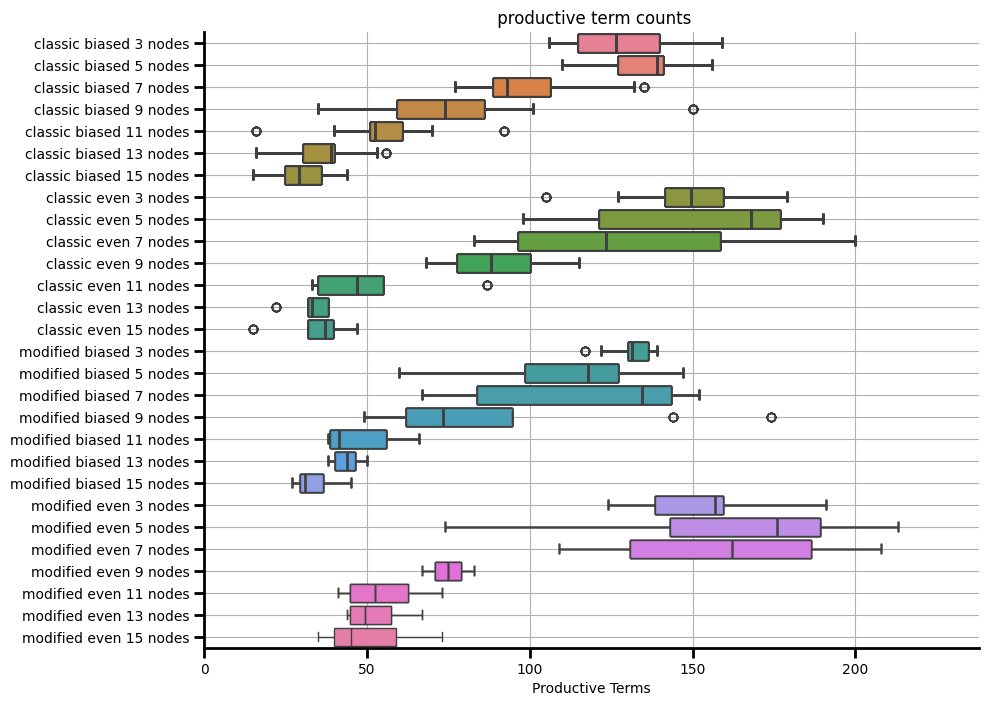

In [219]:
plot_term_counts(DATA, probs = [], algos = [], nodes = [], size=(10,8), term_type='productive') # All everything

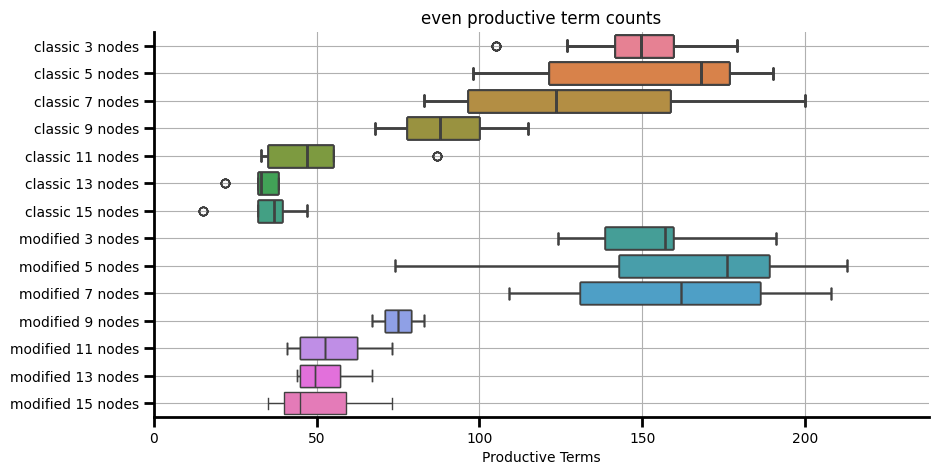

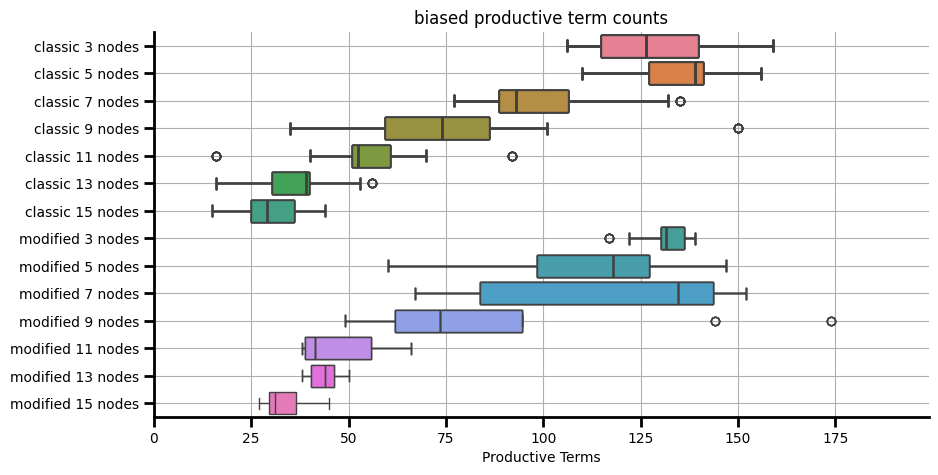

In [220]:
plot_term_counts(DATA, probs = ["even"], algos = [], nodes = [], term_type='productive')
plot_term_counts(DATA, probs = ["biased"], algos = [], nodes = [], term_type='productive')

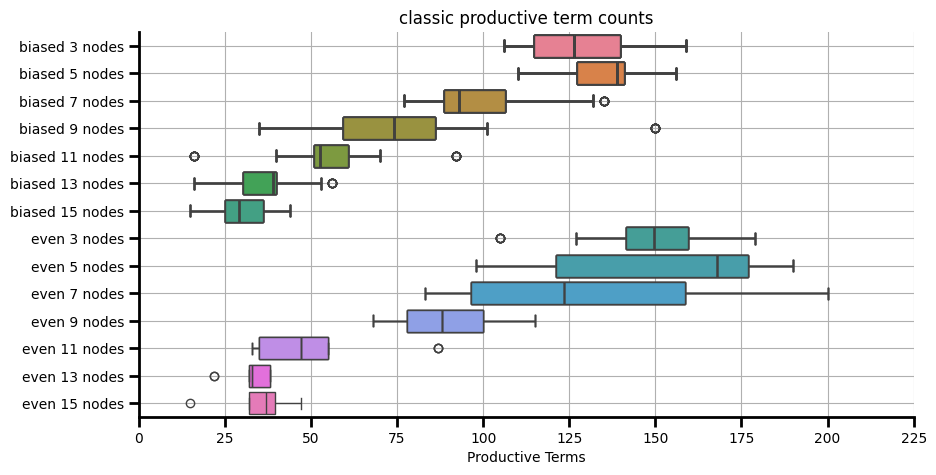

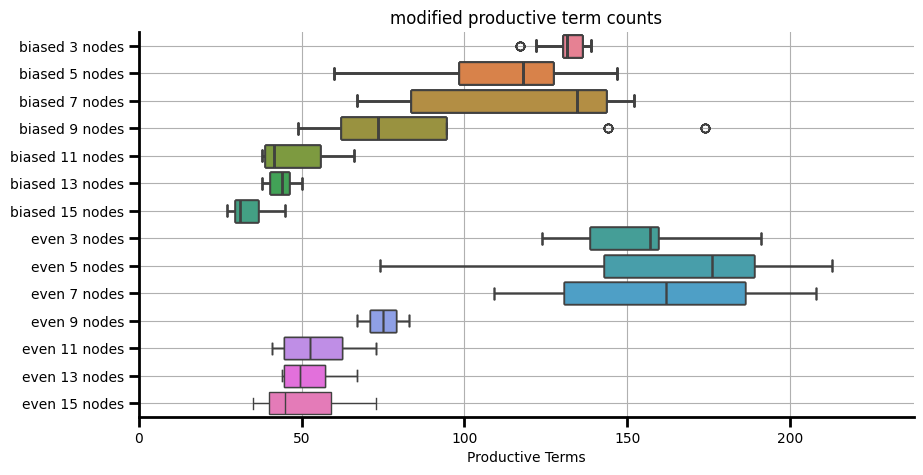

In [221]:
plot_term_counts(DATA, probs = [], algos = ["classic"], nodes = [], term_type='productive') 
plot_term_counts(DATA, probs = [], algos = ["modified"], nodes = [], term_type='productive') 

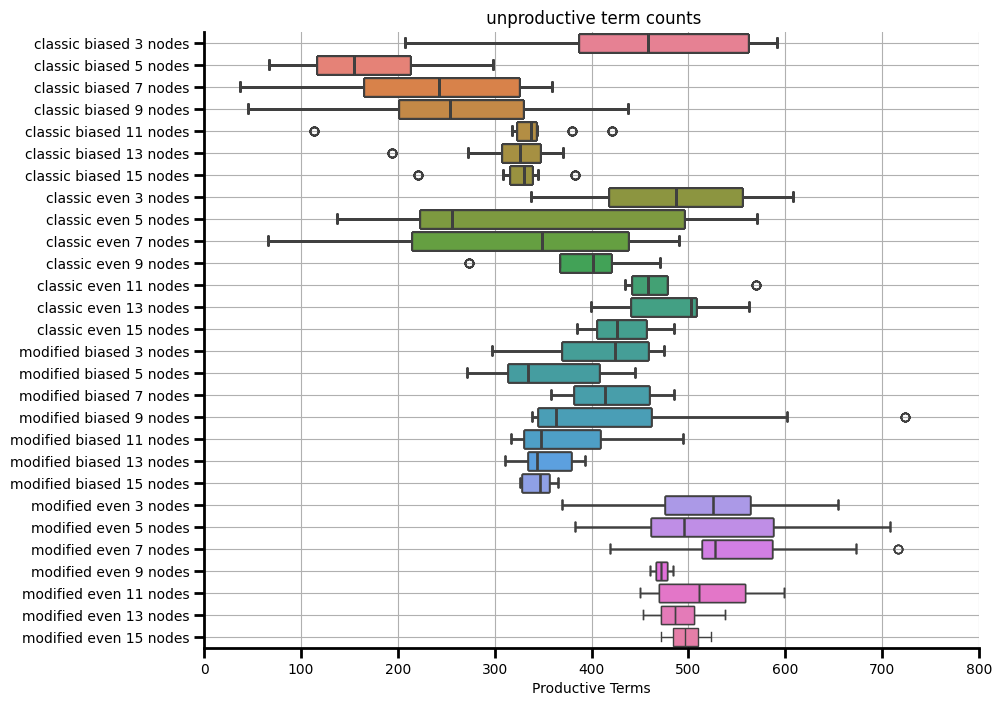

In [222]:
plot_term_counts(DATA, probs = [], algos = [], nodes = [], size=(10,8), term_type='unproductive') # All everything

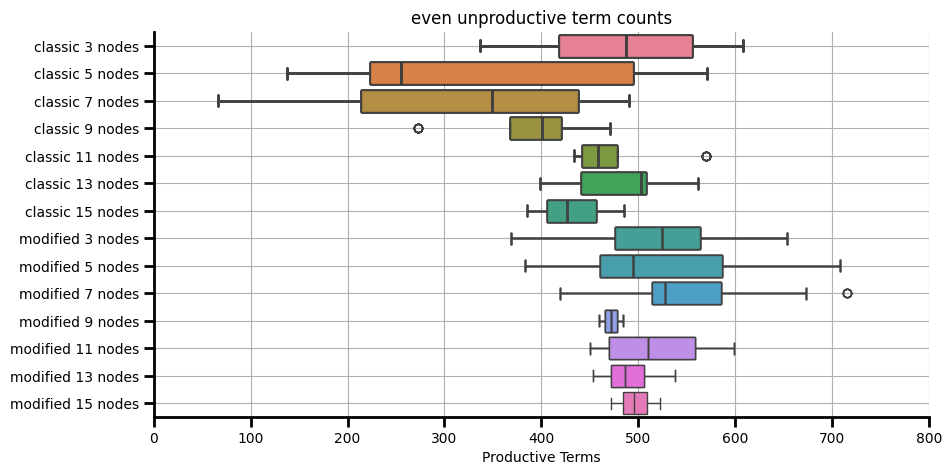

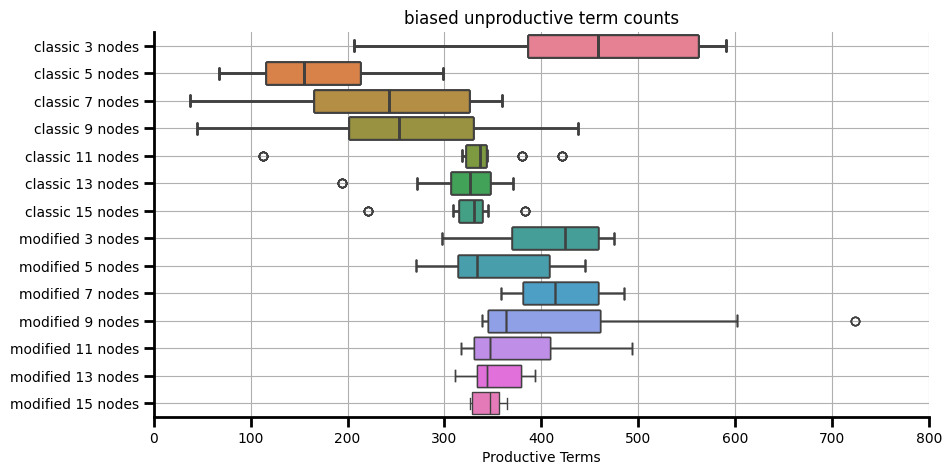

In [223]:
plot_term_counts(DATA, probs = ["even"], algos = [], nodes = [], term_type='unproductive')
plot_term_counts(DATA, probs = ["biased"], algos = [], nodes = [], term_type='unproductive')

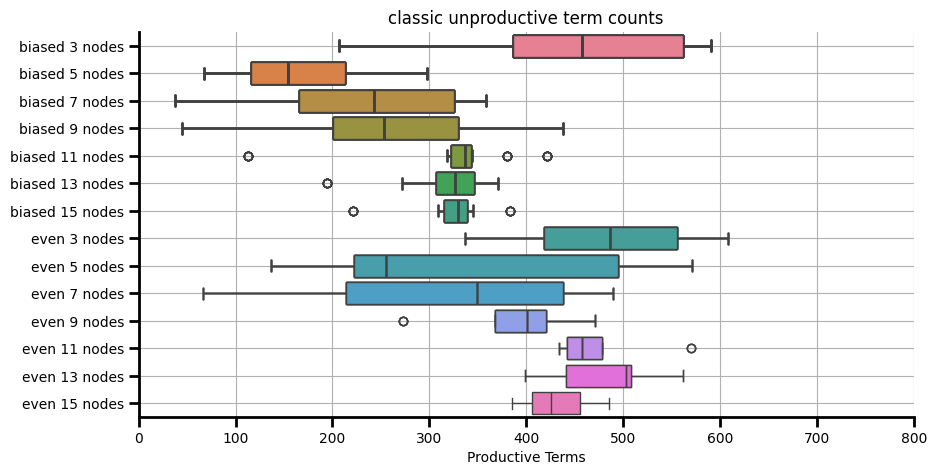

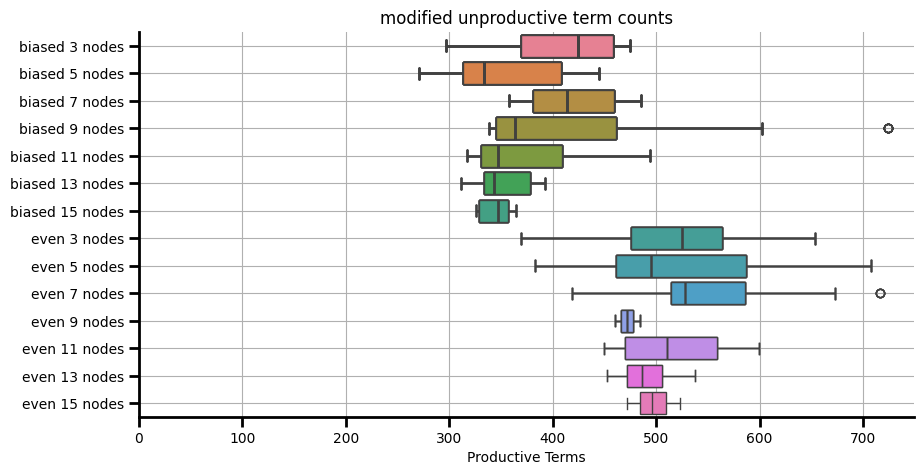

In [224]:
plot_term_counts(DATA, probs = [], algos = ["classic"], nodes = [], term_type='unproductive') 
plot_term_counts(DATA, probs = [], algos = ["modified"], nodes = [], term_type='unproductive') 

# Term Duration Plots

In [301]:
def get_term_durations(file : str) -> list[float]:
    df = open_csv(file)
    productive_terms, _ = get_terms(file)
    durations = []
    for term in productive_terms:
        try:
            term_entries = df[(df["term"] == term) & (df["leaderId"] == df["serverId"])]
            first_entry_time = term_entries.iloc[0]["storageTime"]
            last_entry_time = term_entries.iloc[-1]["storageTime"]
            term_duration = last_entry_time - first_entry_time
            if term_duration > 0.1:
                durations.append(term_duration)
        except:
            # print(f"Could not get term durations for term {term} in file {file}.")
            continue
    return durations

In [328]:
def plot_term_durations(df : pd.DataFrame, algos = None, nodes = None, probs = None, size : tuple[int, int] = (10,5)):
    if algos is None or len(algos) == 0:
        algos = df["algorithm"].unique().tolist()
    if nodes is None or len(nodes) == 0:
        nodes = df["nodeCount"].unique().tolist()
    if probs is None or len(probs) == 0:
        probs = df["crashProbability"].unique().tolist()
    
    lines = len(algos) * len(nodes) * len(probs)
    colors_needed = lines // 2 if len(algos) > 1 or len(probs) > 1 else lines
    palette = COLOR_PALETTE[ : colors_needed]
    
    data_to_plot = {}

    sns.set_palette(sns.color_palette(palette))
    plt.figure(figsize=size)
    line_label_elements = []
    for idx_algo, algo in enumerate(algos):
        for idx_prob, crash_prob in enumerate(probs):
            for idx_node, node in enumerate(nodes):
                line_label_elements = []
                if len(algos) > 1:
                    line_label_elements.append(algo)
                if len(probs) > 1:
                    line_label_elements.append(crash_prob)
                if len(nodes) > 1:
                    line_label_elements.append(f"{node} nodes")
                
                line_label = " ".join(line_label_elements)

                files = df[(df["algorithm"] == algo) & (df["nodeCount"] == node) & (df["crashProbability"] == crash_prob)]["path"]
                term_counts = [get_term_durations(file) for file in files]
                data = sum(term_counts, [])
                data_to_plot[line_label] = data
                
                sns.ecdfplot(data, label=line_label)

                dashed = False
                if (len(algos) > 1 and algo == 'modified'):
                    dashed = True
                elif (len(probs) > 1 and crash_prob == 'even'):
                    dashed = True
                if dashed:
                    [line.set_linestyle("--") for line in plt.gca().lines if line.get_label() == line_label]
    

    title_elements = []
    if len(algos) == 1:
        title_elements.append(algo)
    if len(probs) == 1:
        title_elements.append(crash_prob)
    if len(nodes) == 1:
        title_elements.append(f"{node} nodes")

    plt.title(f'{" ".join(title_elements)} term durations')
    plt.xlabel("Term Duration [seconds]")

    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(10**-2,1)
    # plt.xticks([10**exp for exp in range(1, 3)])
    

    plt.grid(visible=True)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, length=7)
    ax.tick_params(axis='both', which='minor', width=1, length=5)
    plt.legend()
    plt.show()

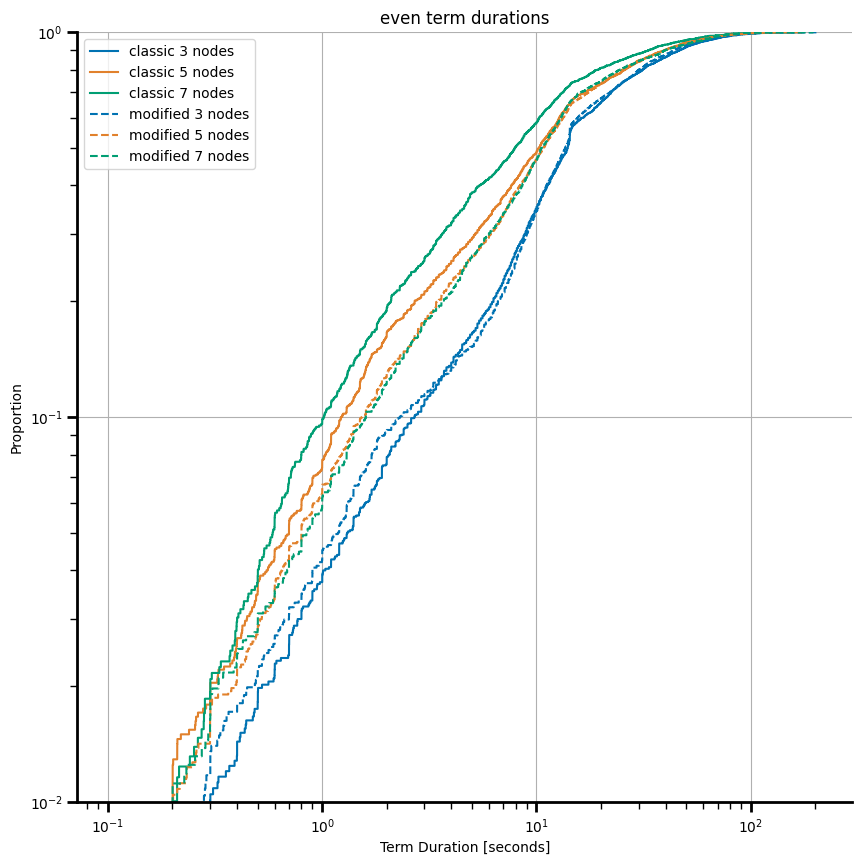

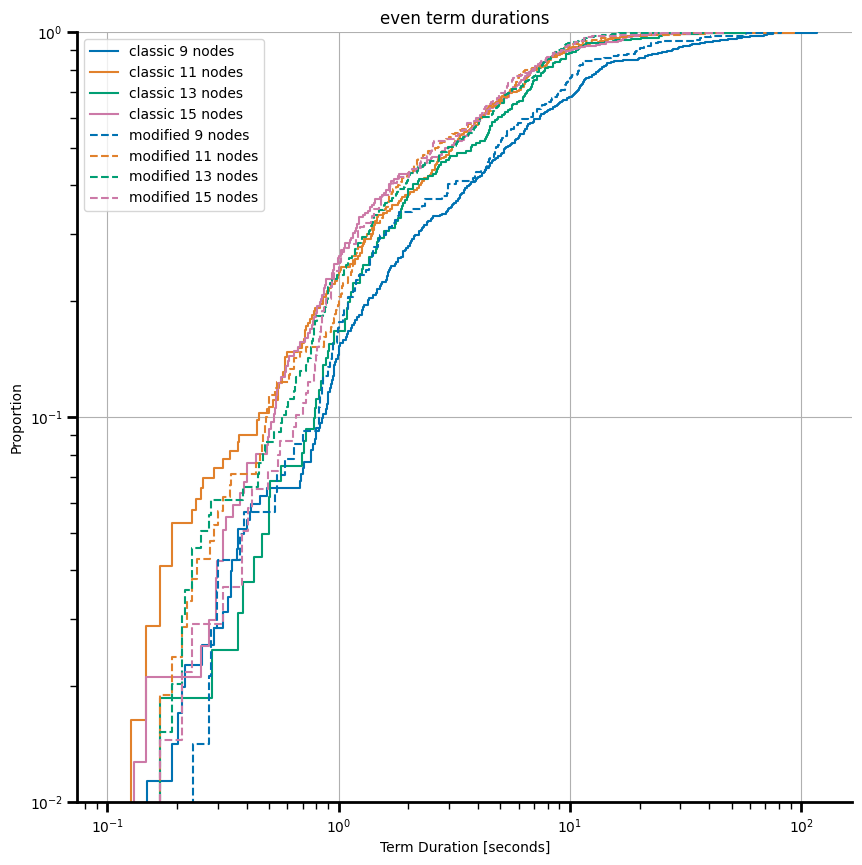

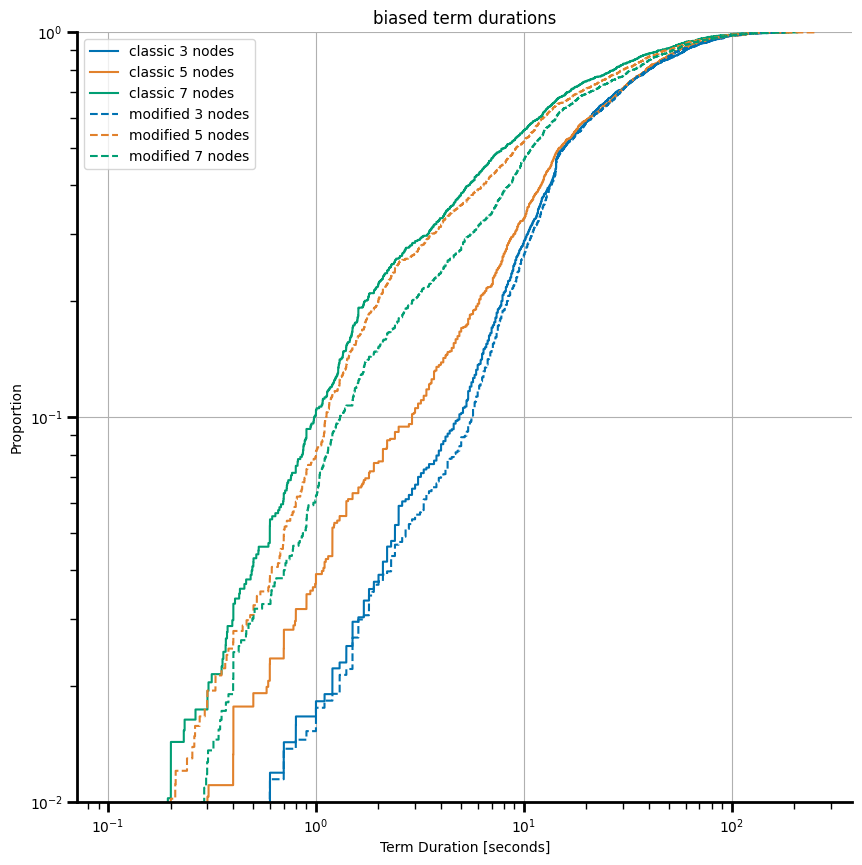

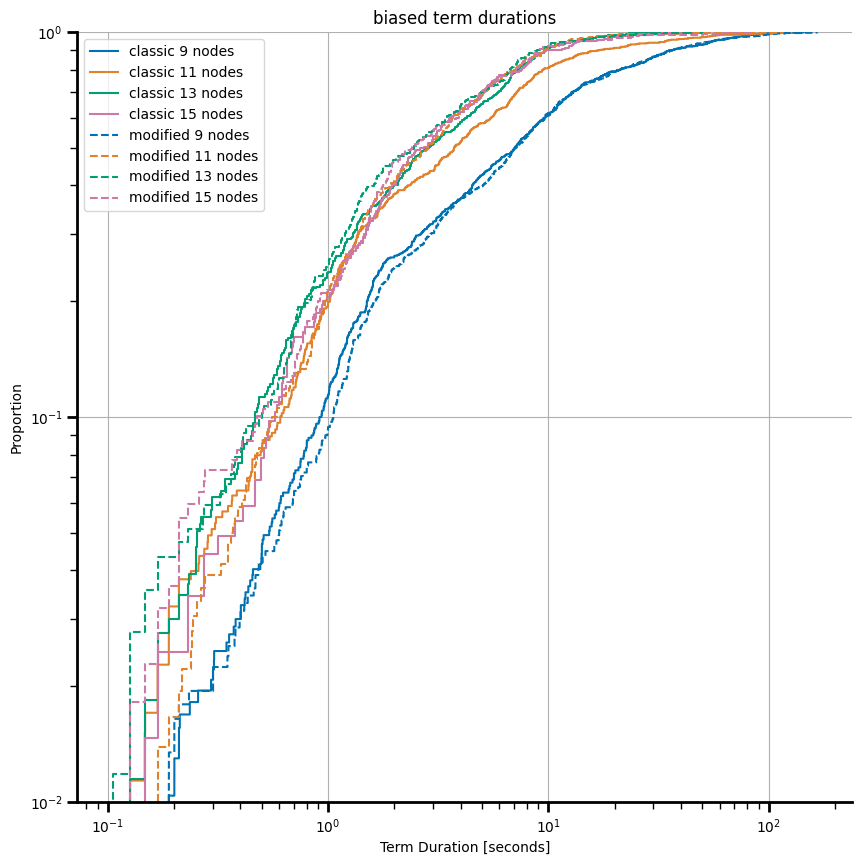

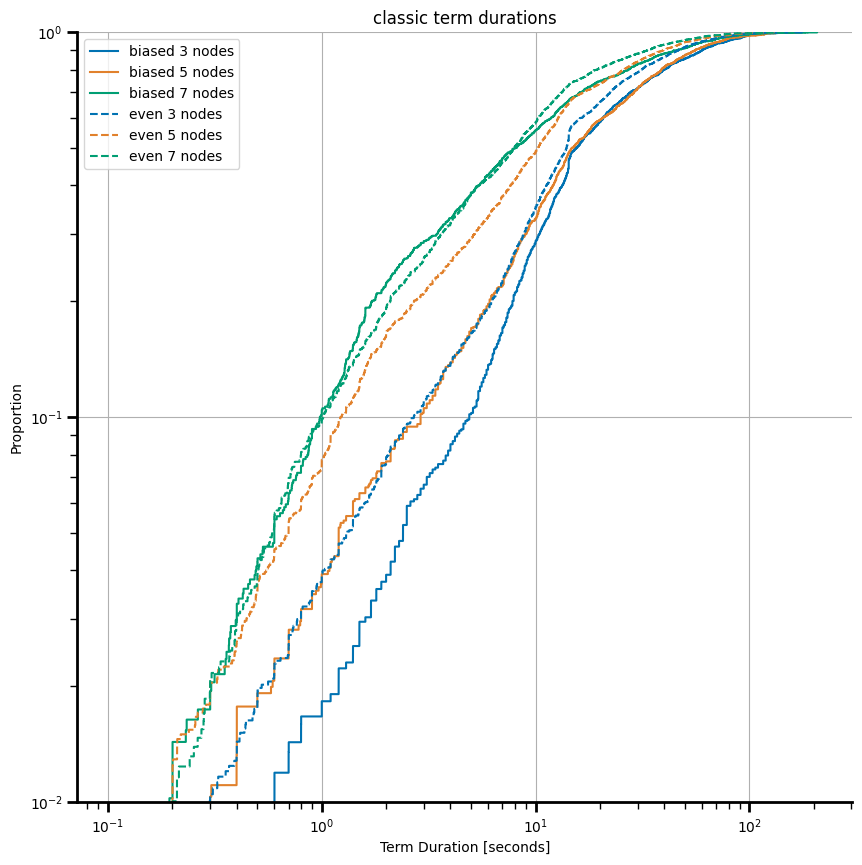

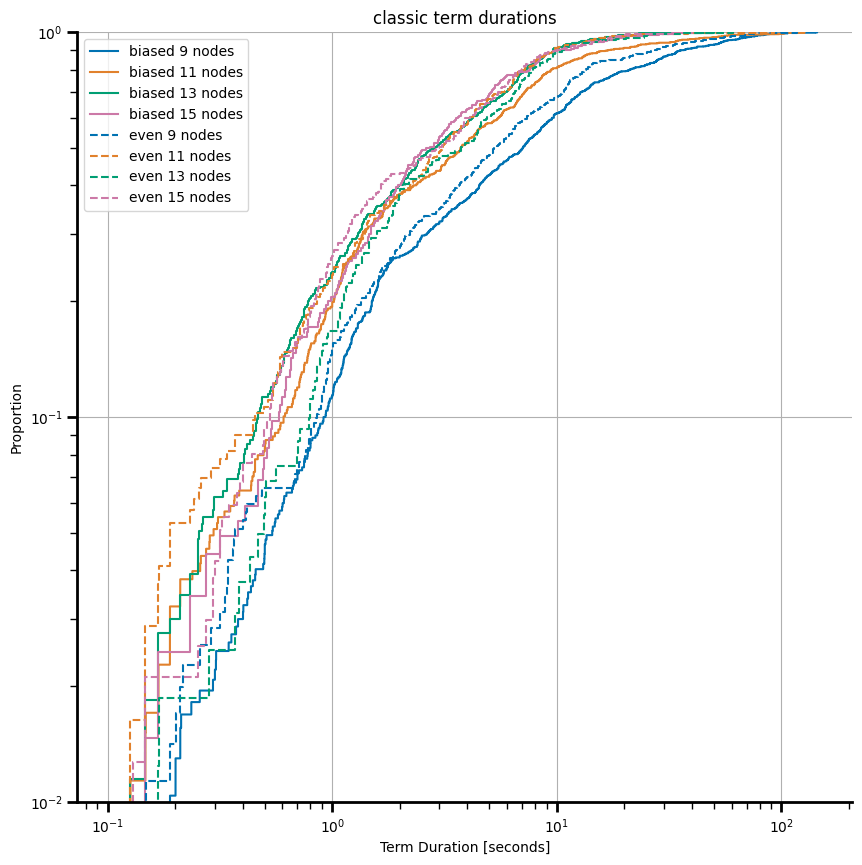

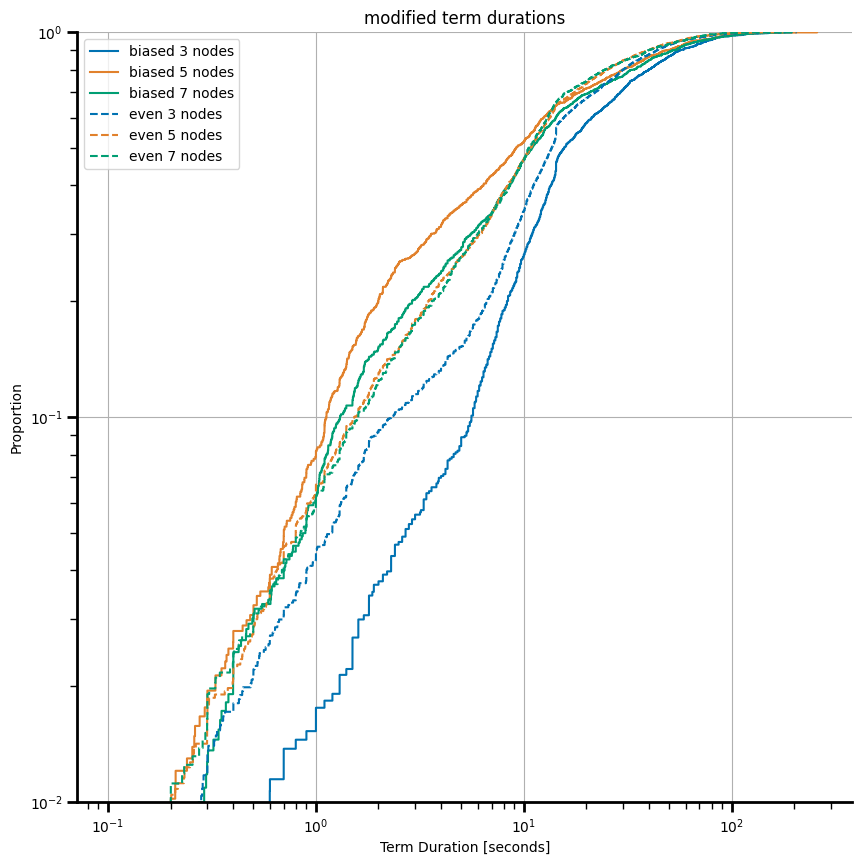

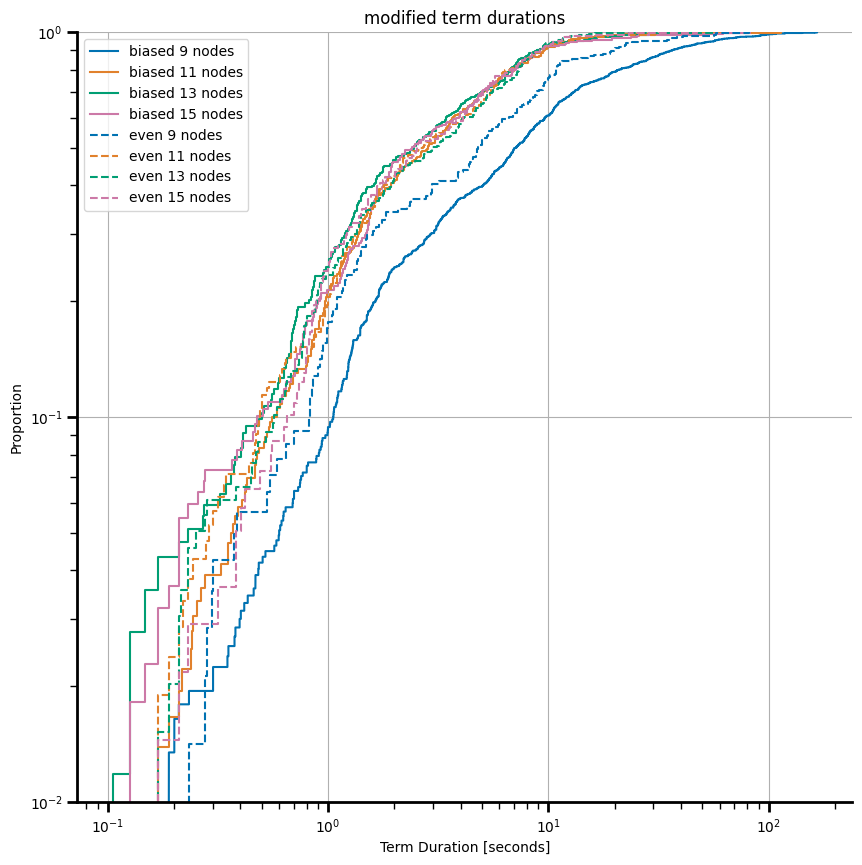

In [329]:
plot_term_durations(DATA, probs = ["even"], algos = [], nodes = [3,5,7], size=(10,10))
plot_term_durations(DATA, probs = ["even"], algos = [], nodes = [9,11,13,15], size=(10,10))

plot_term_durations(DATA, probs = ["biased"], algos = [], nodes = [3,5,7], size=(10,10))
plot_term_durations(DATA, probs = ["biased"], algos = [], nodes = [9,11,13,15], size=(10,10))

plot_term_durations(DATA, probs = [], algos = ["classic"], nodes = [3,5,7], size=(10,10))
plot_term_durations(DATA, probs = [], algos = ["classic"], nodes = [9,11,13,15], size=(10,10))

plot_term_durations(DATA, probs = [], algos = ["modified"], nodes = [3,5,7], size=(10,10))
plot_term_durations(DATA, probs = [], algos = ["modified"], nodes = [9,11,13,15], size=(10,10))

# Election Duration Plots

In [336]:
def get_election_durations(file : str) -> list[float]:
    df = open_csv(file)
    productive_terms, _ = get_terms(file)
    durations = []
    for term_idx, term in enumerate(productive_terms[:-1]):
        try:
            term_entries = df[(df["term"] == term) & (df["leaderId"] == df["serverId"])]
            next_term_entries = df[(df["term"] == productive_terms[term_idx + 1]) & (df["leaderId"] == df["serverId"])]
            first_term_end = term_entries.iloc[-1]["storageTime"]
            # print(f"Term ends at {first_term_end}")

            next_term_start = next_term_entries.iloc[0]["storageTime"]
            # print(f"Next term starts at {next_term_start}")


            term_duration = next_term_start - first_term_end
            if term_duration > 0.0:
                durations.append(term_duration)
        except Exception as e:
            continue

    return durations

In [342]:
def plot_election_durations(df : pd.DataFrame, algos = None, nodes = None, probs = None, size : tuple[int, int] = (10,5)):
    if algos is None or len(algos) == 0:
        algos = df["algorithm"].unique().tolist()
    if nodes is None or len(nodes) == 0:
        nodes = df["nodeCount"].unique().tolist()
    if probs is None or len(probs) == 0:
        probs = df["crashProbability"].unique().tolist()
    
    lines = len(algos) * len(nodes) * len(probs)
    colors_needed = lines // 2 if len(algos) > 1 or len(probs) > 1 else lines
    palette = COLOR_PALETTE[ : colors_needed]
    
    data_to_plot = {}

    sns.set_palette(sns.color_palette(palette))
    plt.figure(figsize=size)
    line_label_elements = []
    for idx_algo, algo in enumerate(algos):
        for idx_prob, crash_prob in enumerate(probs):
            for idx_node, node in enumerate(nodes):
                line_label_elements = []
                if len(algos) > 1:
                    line_label_elements.append(algo)
                if len(probs) > 1:
                    line_label_elements.append(crash_prob)
                if len(nodes) > 1:
                    line_label_elements.append(f"{node} nodes")
                
                line_label = " ".join(line_label_elements)

                files = df[(df["algorithm"] == algo) & (df["nodeCount"] == node) & (df["crashProbability"] == crash_prob)]["path"]
                term_counts = [get_election_durations(file) for file in files]
                data = sum(term_counts, [])
                data_to_plot[line_label] = data
                
                sns.ecdfplot(data, label=line_label)

                dashed = False
                if (len(algos) > 1 and algo == 'modified'):
                    dashed = True
                elif (len(probs) > 1 and crash_prob == 'even'):
                    dashed = True
                if dashed:
                    [line.set_linestyle("--") for line in plt.gca().lines if line.get_label() == line_label]
    

    title_elements = []
    if len(algos) == 1:
        title_elements.append(algo)
    if len(probs) == 1:
        title_elements.append(crash_prob)
    if len(nodes) == 1:
        title_elements.append(f"{node} nodes")

    plt.title(f'{" ".join(title_elements)} election durations')
    plt.xlabel("Election Duration [seconds]")

    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(10**-2,1)
    plt.xlim(0.2, 1000)
    # plt.xticks([10**exp for exp in range(1, 3)])
    

    plt.grid(visible=True)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, length=7)
    ax.tick_params(axis='both', which='minor', width=1, length=5)
    plt.legend()
    plt.show()

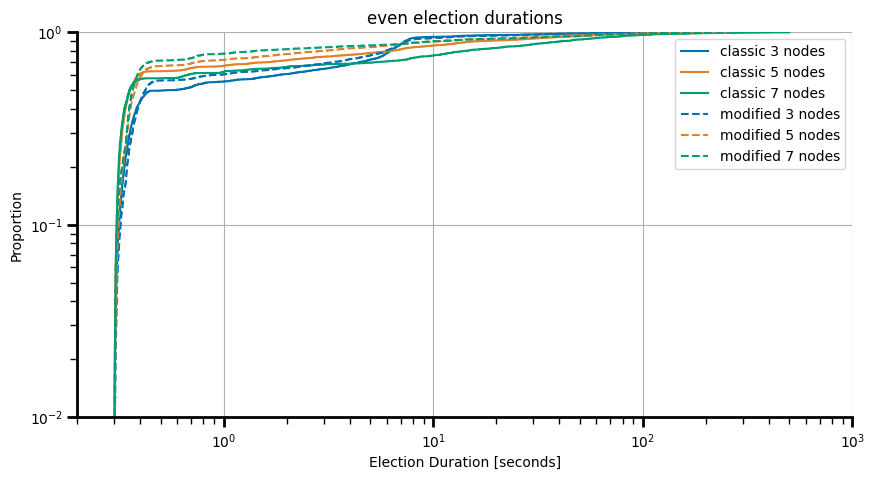

In [347]:
plot_election_durations(DATA, probs = ["even"], algos = [], nodes = [3,5,7], size = (10,5))

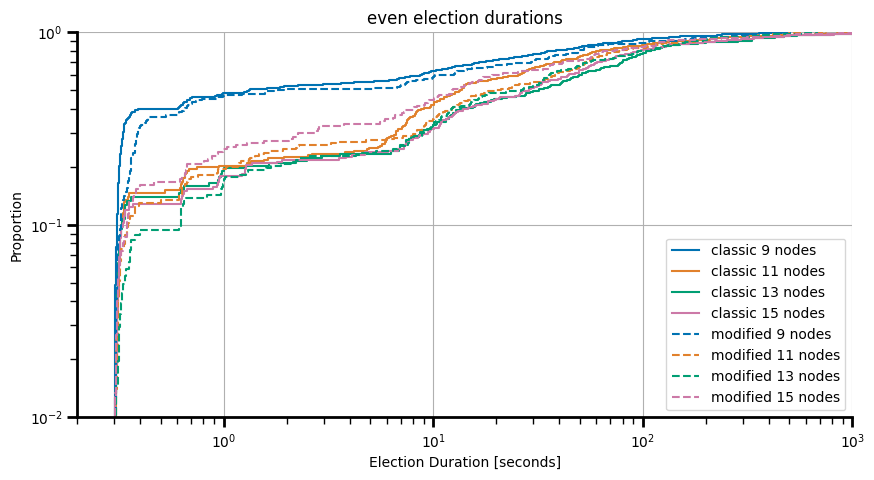

In [348]:
plot_election_durations(DATA, probs = ["even"], algos = [], nodes = [9,11,13,15], size = (10,5))

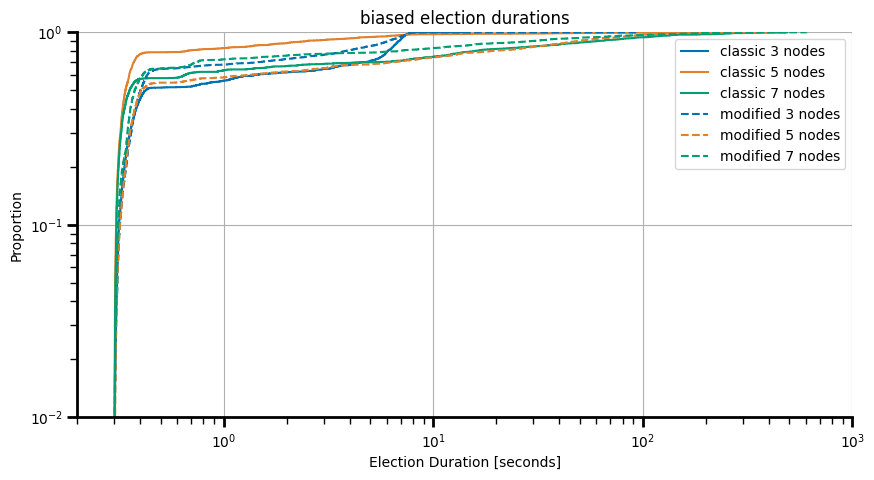

In [349]:
plot_election_durations(DATA, probs = ["biased"], algos = [], nodes = [3,5,7], size = (10,5))

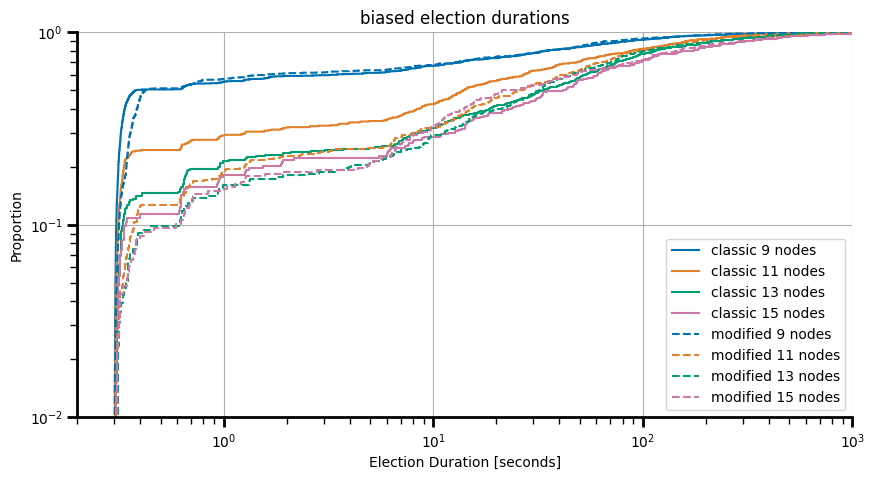

In [350]:
plot_election_durations(DATA, probs = ["biased"], algos = [], nodes = [9,11,13,15], size = (10,5))

# Uptime Plots

In [355]:
def plot_uptime(df : pd.DataFrame, algos = None, nodes = None, probs = None, size : tuple[int, int] = (10,5)):
    if algos is None or len(algos) == 0:
        algos = df["algorithm"].unique().tolist()
    if nodes is None or len(nodes) == 0:
        nodes = df["nodeCount"].unique().tolist()
    if probs is None or len(probs) == 0:
        probs = df["crashProbability"].unique().tolist()
    
    lines = len(algos) * len(nodes) * len(probs)
    palette = COLOR_PALETTE[ : (lines//2)]

    data_to_plot = {}

    sns.set_palette(sns.color_palette(palette))
    plt.figure(figsize=size)
    line_label_elements = []
    for idx_algo, algo in enumerate(algos):
        for idx_prob, crash_prob in enumerate(probs):
            for idx_node, node in enumerate(nodes):
                line_label_elements = []
                if len(algos) > 1:
                    line_label_elements.append(algo)
                if len(probs) > 1:
                    line_label_elements.append(crash_prob)
                if len(nodes) > 1:
                    line_label_elements.append(f"{node} nodes")
                
                line_label = " ".join(line_label_elements)

                files = df[(df["algorithm"] == algo) & (df["nodeCount"] == node) & (df["crashProbability"] == crash_prob)]["path"]
                data = [3600 - sum(get_election_durations(file)) for file in files]
                data_to_plot[line_label] = data
                
    
    sns.boxplot(data_to_plot, orient='h')
    

    title_elements = []
    if len(algos) == 1:
        title_elements.append(algo)
    if len(probs) == 1:
        title_elements.append(crash_prob)
    if len(nodes) == 1:
        title_elements.append(f"{node} nodes")

    plt.title(f'{" ".join(title_elements)} uptime')
    plt.xlabel("Uptime [seconds]")

    plt.grid(visible=True)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, length=7)
    ax.tick_params(axis='both', which='minor', width=1, length=5)
    plt.show()

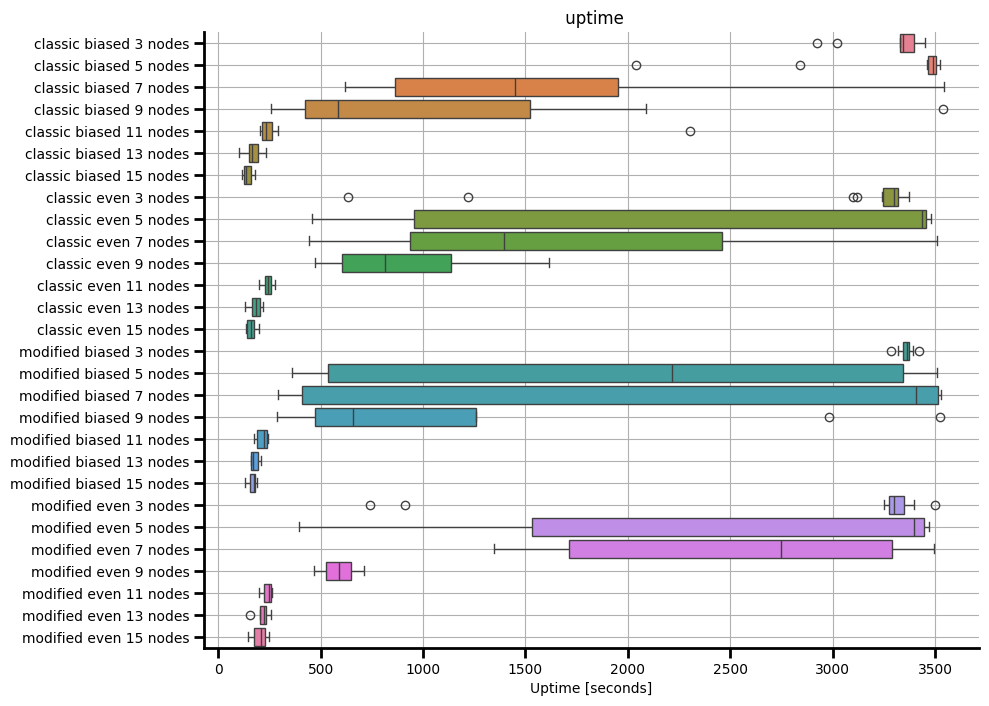

In [357]:
plot_uptime(DATA, size=(10,8))